In [ ]:
# CELL 1: Environment Setup - 
# ============================================

import subprocess
import sys

packages = [
    "pandas",
    "numpy", 
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "xgboost",
    "catboost",
    "lightgbm",
    "optuna",
    "shap",
    "lime",
    "imbalanced-learn",
    "scipy",
    "statsmodels",
    "missingno",
    "sweetviz",
    "ydata-profiling",  # formerly pandas-profiling
    "openpyxl",
    "joblib",
    "pyyaml",
    "streamlit",
    "fpdf2",
    "plotly",
    "kaleido"
]

def install_packages(packages):
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
            print(f"✅ {package}")
        except:
            print(f"❌ {package} - Manual install needed")

print("🔧 Installing packages for Elite CVD System...")
print("=" * 50)
install_packages(packages)
print("\n✅ Environment Setup Complete!")

🔧 Installing packages for Elite CVD System...
✅ pandas
✅ numpy
✅ matplotlib
✅ seaborn
✅ scikit-learn
✅ xgboost
✅ catboost
✅ lightgbm
✅ optuna
✅ shap
✅ lime
✅ imbalanced-learn
✅ scipy
✅ statsmodels
✅ missingno
✅ sweetviz
✅ ydata-profiling
✅ openpyxl
✅ joblib
✅ pyyaml
✅ streamlit
✅ fpdf2
✅ plotly
✅ kaleido

✅ Environment Setup Complete!


In [6]:
# CELL 2: Master Configuration & Imports
# ============================================

# ===== CORE LIBRARIES =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import os
from datetime import datetime

# ===== STATISTICAL LIBRARIES =====
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, spearmanr, pearsonr

# ===== ML LIBRARIES =====
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# ===== CONFIGURATION =====
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# ===== STYLE =====
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ===== PROJECT PATHS =====
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
MODELS_PATH = PROJECT_ROOT / 'models' / 'saved_models'
REPORTS_PATH = PROJECT_ROOT / 'reports' / 'figures'

# Create directories if they don't exist
for path in [DATA_RAW, DATA_PROCESSED, MODELS_PATH, REPORTS_PATH]:
    path.mkdir(parents=True, exist_ok=True)

# ===== RANDOM SEED (REPRODUCIBILITY) =====
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ===== PROJECT METADATA =====
PROJECT_INFO = {
    "name": "Elite CVD Prediction System",
    "version": "1.0.0",
    "author": "Clinical ML Engineer",
    "date_started": datetime.now().strftime("%Y-%m-%d"),
    "objective": "High-Recall CVD Risk Stratification",
    "primary_metric": "Recall (Sensitivity)"
}

print("=" * 60)
print(f"🏥 {PROJECT_INFO['name']} v{PROJECT_INFO['version']}")
print(f"📅 Started: {PROJECT_INFO['date_started']}")
print(f"🎯 Objective: {PROJECT_INFO['objective']}")
print(f"📊 Primary Metric: {PROJECT_INFO['primary_metric']}")
print("=" * 60)
print(f"\n📁 Project Root: {PROJECT_ROOT}")
print(f"📁 Raw Data Path: {DATA_RAW}")
print(f"📁 Processed Data: {DATA_PROCESSED}")
print("\n✅ Configuration Loaded Successfully!")

🏥 Elite CVD Prediction System v1.0.0
📅 Started: 2025-12-17
🎯 Objective: High-Recall CVD Risk Stratification
📊 Primary Metric: Recall (Sensitivity)

📁 Project Root: c:\Users\abhis\CVD_PREDICTION_SYSTEM
📁 Raw Data Path: c:\Users\abhis\CVD_PREDICTION_SYSTEM\data\raw
📁 Processed Data: c:\Users\abhis\CVD_PREDICTION_SYSTEM\data\processed

✅ Configuration Loaded Successfully!


## Step 1.2: Data Loading Cell

In [7]:
DATASET_FILENAME = "CVD Dataset.csv"
# Load the dataset
file_path = DATA_RAW / DATASET_FILENAME

# Check if file exists
if not file_path.exists():
    print(f"❌ File not found at: {file_path}")
    print(f"\n📁 Files in {DATA_RAW}:")
    for f in DATA_RAW.iterdir():
        print(f"   - {f.name}")
    raise FileNotFoundError("Please check the filename and path")


In [8]:
# Load data
df_raw = pd.read_csv(file_path)

In [10]:
# Create a working copy (never modify raw data)
df = df_raw.copy()

In [11]:
print("=" * 70)
print("📊 STEP 1: DATA LOADING & INITIAL RECONNAISSANCE")
print("=" * 70) 
print(f"""
📁 Source File: {DATASET_FILENAME}
📏 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns
💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB
""")

📊 STEP 1: DATA LOADING & INITIAL RECONNAISSANCE

📁 Source File: CVD Dataset.csv
📏 Dataset Shape: 1,529 rows × 22 columns
💾 Memory Usage: 0.88 MB



In [12]:
# ===== 1.2 COLUMN OVERVIEW =====
print("\n" + "─" * 70)
print("📋 1.2 COLUMN SCHEMA OVERVIEW")
print("─" * 70)

schema_df = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.notna().sum().values,
    'Null Count': df.isna().sum().values,
    'Null %': (df.isna().sum().values / len(df) * 100).round(2),
    'Unique Values': df.nunique().values,
    'Sample Value': [df[col].dropna().iloc[0] if df[col].notna().any() else 'N/A' for col in df.columns]
})

print(schema_df.to_string(index=False))


──────────────────────────────────────────────────────────────────────
📋 1.2 COLUMN SCHEMA OVERVIEW
──────────────────────────────────────────────────────────────────────
                      Column Data Type  Non-Null Count  Null Count  Null %  Unique Values Sample Value
                         Sex    object            1529           0   0.000              2            F
                         Age   float64            1451          78   5.100             55       32.000
                 Weight (kg)   float64            1448          81   5.300           1019       69.100
                  Height (m)   float64            1462          67   4.380            346        1.710
                         BMI   float64            1465          64   4.190            787       23.600
Abdominal Circumference (cm)   float64            1462          67   4.380            865       86.200
       Blood Pressure (mmHg)    object            1529           0   0.000           1254       125/79
   T

In [13]:
# ===== 1.3 FIRST LOOK AT DATA =====
print("\n" + "─" * 70)
print("👀 1.3 FIRST 5 ROWS (HEAD)")
print("─" * 70)
display(df.head())


──────────────────────────────────────────────────────────────────────
👀 1.3 FIRST 5 ROWS (HEAD)
──────────────────────────────────────────────────────────────────────


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,CVD Risk Level,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
0,F,32.000,69.100,1.710,23.600,86.200,125/79,248.000,78.000,111.000,N,Y,Low,N,INTERMEDIARY,171.000,0.504,125.000,79.000,Elevated,140.000,17.930
1,F,55.000,118.700,1.690,41.600,82.500,139/70,162.000,50.000,135.000,Y,Y,High,Y,HIGH,169.000,0.488,139.000,70.000,Hypertension Stage 1,82.000,20.510
2,M,NaN,NaN,1.830,26.900,106.700,104/77,103.000,73.000,114.000,N,N,High,Y,INTERMEDIARY,183.000,0.583,104.000,77.000,Normal,0.000,12.640
3,M,44.000,108.300,1.800,33.400,96.600,140/83,134.000,46.000,91.000,N,N,High,Y,INTERMEDIARY,NaN,0.537,140.000,83.000,Hypertension Stage 1,58.000,16.360
4,F,32.000,99.500,1.860,28.800,102.700,144/83,146.000,64.000,141.000,Y,Y,High,N,INTERMEDIARY,186.000,0.552,144.000,83.000,Hypertension Stage 1,52.000,17.880


In [14]:
print("\n" + "─" * 70)
print("👀 1.4 LAST 5 ROWS (TAIL)")
print("─" * 70)
display(df.tail())


──────────────────────────────────────────────────────────────────────
👀 1.4 LAST 5 ROWS (TAIL)
──────────────────────────────────────────────────────────────────────


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,CVD Risk Level,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
1524,F,40.000,72.070,1.889,NaN,95.326,119/66,157.000,60.000,93.000,N,N,Moderate,Y,LOW,188.894,0.505,119.000,66.000,Normal,67.000,14.300
1525,F,78.000,85.877,1.825,24.426,112.340,102/115,241.000,84.000,NaN,Y,N,Low,N,INTERMEDIARY,182.485,0.616,102.000,115.000,Hypertension Stage 2,127.000,14.805
1526,M,39.000,98.626,1.521,20.055,77.193,150/90,237.000,82.000,147.000,N,Y,High,N,INTERMEDIARY,152.119,0.507,150.000,90.000,Hypertension Stage 2,125.000,18.251
1527,M,71.000,116.163,1.841,29.279,114.197,112/63,193.000,84.000,123.000,N,N,High,Y,INTERMEDIARY,184.059,0.620,112.000,63.000,Normal,79.000,15.316
1528,F,78.000,111.627,1.867,22.017,97.692,134/67,218.000,68.000,166.000,N,N,High,N,HIGH,186.735,0.523,134.000,67.000,Hypertension Stage 1,120.000,15.463


In [15]:
print("\n" + "─" * 70)
print("🎲 1.5 RANDOM SAMPLE (5 ROWS)")
print("─" * 70)
display(df.sample(5, random_state=RANDOM_STATE))


──────────────────────────────────────────────────────────────────────
🎲 1.5 RANDOM SAMPLE (5 ROWS)
──────────────────────────────────────────────────────────────────────


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,CVD Risk Level,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
439,M,47.000,NaN,1.880,29.100,78.400,119/99,213.000,54.000,NaN,N,Y,Moderate,Y,HIGH,188.000,0.417,119.000,99.000,Hypertension Stage 2,129.000,18.030
76,F,51.000,52.500,1.780,16.600,75.800,98/63,119.000,50.000,128.000,Y,Y,High,Y,HIGH,178.000,0.426,98.000,63.000,Normal,39.000,12.600
1270,F,65.000,112.076,1.883,37.784,83.952,141/81,107.000,80.000,161.000,Y,N,High,Y,HIGH,188.311,0.446,141.000,81.000,Hypertension Stage 1,-3.000,16.747
661,M,41.000,59.200,1.650,NaN,90.400,150/98,114.000,56.000,134.000,Y,N,High,Y,INTERMEDIARY,165.000,0.548,150.000,98.000,Hypertension Stage 2,28.000,14.120
1036,F,79.000,103.359,1.943,28.357,95.531,162/114,190.000,35.000,84.000,Y,N,Moderate,Y,INTERMEDIARY,194.298,0.492,162.000,114.000,Hypertension Stage 2,125.000,17.571


## 📊 STEP 1 (Continued): DEEP DATA FORENSICS

### Step 1.4: Target Variable & Leakage Investigation

🎯 STEP 1.4: TARGET VARIABLE ANALYSIS

📌 Target Variable: 'CVD Risk Level'
──────────────────────────────────────────────────

📊 Target Distribution:
                Count  Percentage
CVD Risk Level                   
HIGH              728      47.610
INTERMEDIARY      581      38.000
LOW               220      14.390


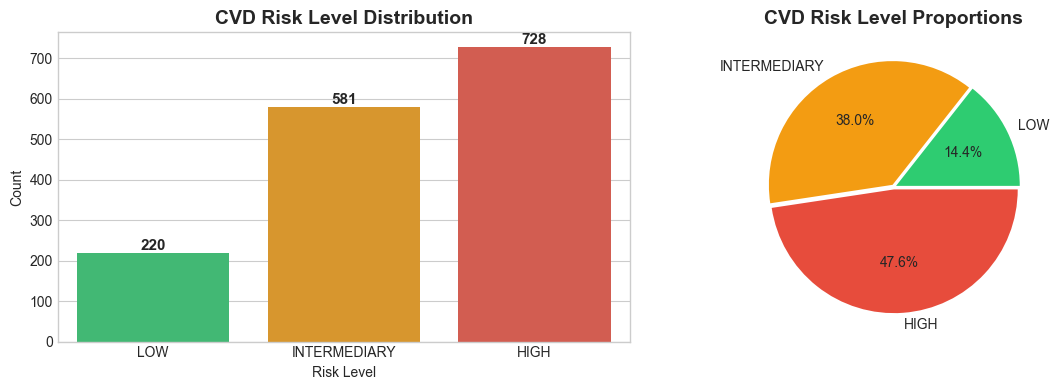


──────────────────────────────────────────────────
⚖️ CLASS IMBALANCE ASSESSMENT
──────────────────────────────────────────────────
Majority Class Count: 728
Minority Class Count: 220
Imbalance Ratio: 3.31:1
⚠️ SEVERE IMBALANCE - Will need SMOTE or class weights


In [16]:
# CELL 4: Target Variable Analysis & Leakage Detection
# ============================================

print("=" * 70)
print("🎯 STEP 1.4: TARGET VARIABLE ANALYSIS")
print("=" * 70)

# ===== IDENTIFY TARGET COLUMN =====
TARGET_COLUMN = 'CVD Risk Level'

print(f"\n📌 Target Variable: '{TARGET_COLUMN}'")
print("─" * 50)

# Target Distribution
print("\n📊 Target Distribution:")
target_dist = df[TARGET_COLUMN].value_counts()
target_pct = df[TARGET_COLUMN].value_counts(normalize=True) * 100

target_summary = pd.DataFrame({
    'Count': target_dist,
    'Percentage': target_pct.round(2)
})
print(target_summary)

# Visualize Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red for LOW, INTER, HIGH
order = ['LOW', 'INTERMEDIARY', 'HIGH']
ax1 = sns.countplot(data=df, x=TARGET_COLUMN, order=order, palette=colors, ax=axes[0])
axes[0].set_title('CVD Risk Level Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Count')

# Add count labels on bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(target_dist[order], labels=order, autopct='%1.1f%%', colors=colors, explode=[0.02]*3)
axes[1].set_title('CVD Risk Level Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_PATH / '01_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== CLASS IMBALANCE ASSESSMENT =====
print("\n" + "─" * 50)
print("⚖️ CLASS IMBALANCE ASSESSMENT")
print("─" * 50)

majority_class = target_dist.max()
minority_class = target_dist.min()
imbalance_ratio = majority_class / minority_class

print(f"Majority Class Count: {majority_class}")
print(f"Minority Class Count: {minority_class}")
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("⚠️ SEVERE IMBALANCE - Will need SMOTE or class weights")
elif imbalance_ratio > 1.5:
    print("⚠️ MODERATE IMBALANCE - Class weights recommended")
else:
    print("✅ BALANCED - Standard training approach")

### Step 1.5: CRITICAL - Leakage Detection

🚨 STEP 1.5: TARGET LEAKAGE DETECTION

⚠️ LEAKAGE occurs when information from the target "leaks" into features.
   This creates artificially high accuracy that won't work in production.


──────────────────────────────────────────────────
🔍 INVESTIGATION: 'CVD Risk Score' vs 'CVD Risk Level'
──────────────────────────────────────────────────

CVD Risk Score Statistics by Risk Level:
                 mean    min    max   std
CVD Risk Level                           
LOW            17.006 10.860 23.797 2.732
INTERMEDIARY   16.133 10.530 23.510 2.346
HIGH           17.611 10.890 24.170 2.209


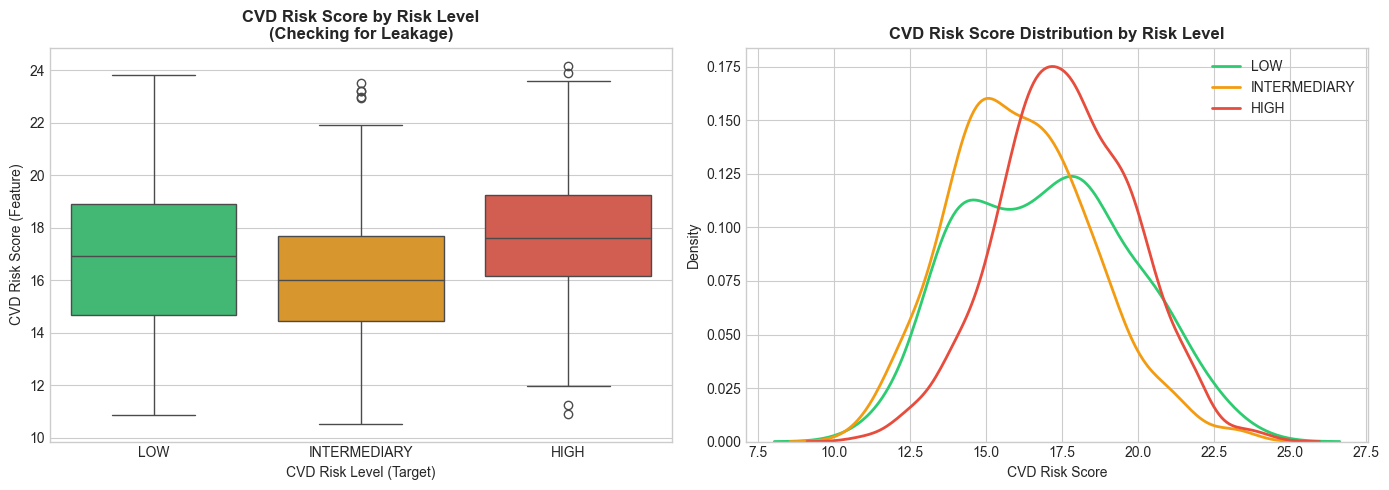


──────────────────────────────────────────────────
📈 CORRELATION: CVD Risk Score ↔ Risk Level
──────────────────────────────────────────────────
Pearson Correlation: -0.1764
ANOVA F-statistic: 61.8917
ANOVA p-value: 1.59e-26

──────────────────────────────────────────────────
🏛️ LEAKAGE VERDICT
──────────────────────────────────────────────────

🔴 HIGH PROBABILITY OF TARGET LEAKAGE DETECTED!

   The 'CVD Risk Score' appears to be directly used to derive 'CVD Risk Level'.

   DECISION OPTIONS:
   ├── Option A: REMOVE 'CVD Risk Score' from features (Recommended)
   ├── Option B: Use 'CVD Risk Score' as target instead (Regression task)
   └── Option C: Use 'CVD Risk Score' as BENCHMARK to beat

   📋 For a TRUE predictive model, we will use Option A.



In [17]:
# CELL 5: Target Leakage Detection (CRITICAL!)
# ============================================

print("=" * 70)
print("🚨 STEP 1.5: TARGET LEAKAGE DETECTION")
print("=" * 70)

print("""
⚠️ LEAKAGE occurs when information from the target "leaks" into features.
   This creates artificially high accuracy that won't work in production.
""")

# ===== CHECK: CVD Risk Score vs CVD Risk Level =====
print("\n" + "─" * 50)
print("🔍 INVESTIGATION: 'CVD Risk Score' vs 'CVD Risk Level'")
print("─" * 50)

# Group Risk Score by Risk Level
leakage_check = df.groupby('CVD Risk Level')['CVD Risk Score'].agg(['mean', 'min', 'max', 'std'])
leakage_check = leakage_check.reindex(['LOW', 'INTERMEDIARY', 'HIGH'])
print("\nCVD Risk Score Statistics by Risk Level:")
print(leakage_check.round(3))

# Visualize the relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
order = ['LOW', 'INTERMEDIARY', 'HIGH']
sns.boxplot(data=df, x='CVD Risk Level', y='CVD Risk Score', order=order, palette=colors, ax=axes[0])
axes[0].set_title('CVD Risk Score by Risk Level\n(Checking for Leakage)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('CVD Risk Level (Target)')
axes[0].set_ylabel('CVD Risk Score (Feature)')

# Distribution plot
for level, color in zip(order, colors):
    subset = df[df['CVD Risk Level'] == level]['CVD Risk Score'].dropna()
    sns.kdeplot(subset, ax=axes[1], label=level, color=color, linewidth=2)

axes[1].set_title('CVD Risk Score Distribution by Risk Level', fontsize=12, fontweight='bold')
axes[1].set_xlabel('CVD Risk Score')
axes[1].legend()

plt.tight_layout()
plt.savefig(REPORTS_PATH / '02_leakage_investigation.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== CORRELATION CHECK =====
print("\n" + "─" * 50)
print("📈 CORRELATION: CVD Risk Score ↔ Risk Level")
print("─" * 50)

# Encode target for correlation
from sklearn.preprocessing import LabelEncoder
le_temp = LabelEncoder()
df['Risk_Level_Encoded'] = le_temp.fit_transform(df['CVD Risk Level'])

correlation = df['CVD Risk Score'].corr(df['Risk_Level_Encoded'])
print(f"Pearson Correlation: {correlation:.4f}")

# Statistical Test: ANOVA
from scipy.stats import f_oneway

groups = [df[df['CVD Risk Level'] == level]['CVD Risk Score'].dropna() for level in order]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA p-value: {p_value:.2e}")

# Verdict
print("\n" + "─" * 50)
print("🏛️ LEAKAGE VERDICT")
print("─" * 50)

if abs(correlation) > 0.8 or p_value < 0.001:
    print("""
🔴 HIGH PROBABILITY OF TARGET LEAKAGE DETECTED!
   
   The 'CVD Risk Score' appears to be directly used to derive 'CVD Risk Level'.
   
   DECISION OPTIONS:
   ├── Option A: REMOVE 'CVD Risk Score' from features (Recommended)
   ├── Option B: Use 'CVD Risk Score' as target instead (Regression task)
   └── Option C: Use 'CVD Risk Score' as BENCHMARK to beat
   
   📋 For a TRUE predictive model, we will use Option A.
""")
    LEAKAGE_DETECTED = True
else:
    print("✅ No obvious leakage detected. Proceed with caution.")
    LEAKAGE_DETECTED = False

# Clean up temp column
df.drop('Risk_Level_Encoded', axis=1, inplace=True)

### Step 1.6: Data Quality - Impossible Values Detection

In [18]:
# CELL 6: Clinical Data Quality - Impossible Values
# ============================================

print("=" * 70)
print("🏥 STEP 1.6: CLINICAL DATA QUALITY AUDIT")
print("=" * 70)

print("""
Medical data has HARD CONSTRAINTS based on physiology.
We must flag and handle impossible values.
""")

# ===== PHYSIOLOGICAL SANITY CHECKS =====
print("\n" + "─" * 50)
print("🔬 PHYSIOLOGICAL SANITY CHECKS")
print("─" * 50)

# Initialize anomaly tracker
anomalies = {}

# CHECK 1: Diastolic > Systolic (IMPOSSIBLE)
check_bp = df[df['Diastolic BP'] > df['Systolic BP']]
anomalies['Diastolic > Systolic'] = len(check_bp)
print(f"\n❌ Diastolic BP > Systolic BP: {len(check_bp)} rows")
if len(check_bp) > 0:
    print("   Sample problematic rows:")
    display(check_bp[['Systolic BP', 'Diastolic BP', 'Blood Pressure (mmHg)']].head())

# CHECK 2: Negative LDL (IMPOSSIBLE)
check_ldl = df[df['Estimated LDL (mg/dL)'] < 0]
anomalies['Negative LDL'] = len(check_ldl)
print(f"\n❌ Negative LDL values: {len(check_ldl)} rows")
if len(check_ldl) > 0:
    display(check_ldl[['Estimated LDL (mg/dL)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)']].head())

# CHECK 3: Zero LDL (Suspicious)
check_ldl_zero = df[df['Estimated LDL (mg/dL)'] == 0]
anomalies['Zero LDL'] = len(check_ldl_zero)
print(f"\n⚠️ Zero LDL values: {len(check_ldl_zero)} rows")

# CHECK 4: BMI Extremes
check_bmi_low = df[df['BMI'] < 12]  # Lowest survivable BMI ~12-13
check_bmi_high = df[df['BMI'] > 60]  # Extreme obesity
anomalies['BMI < 12'] = len(check_bmi_low)
anomalies['BMI > 60'] = len(check_bmi_high)
print(f"\n❌ BMI < 12 (impossibly low): {len(check_bmi_low)} rows")
print(f"❌ BMI > 60 (extreme): {len(check_bmi_high)} rows")

# CHECK 5: Age Extremes
check_age_low = df[df['Age'] < 18]
check_age_high = df[df['Age'] > 120]
anomalies['Age < 18'] = len(check_age_low)
anomalies['Age > 120'] = len(check_age_high)
print(f"\n⚠️ Age < 18: {len(check_age_low)} rows")
print(f"❌ Age > 120 (impossible): {len(check_age_high)} rows")

# CHECK 6: Blood Pressure Extremes
check_bp_sys_high = df[df['Systolic BP'] > 250]
check_bp_sys_low = df[df['Systolic BP'] < 60]
check_bp_dia_high = df[df['Diastolic BP'] > 150]
check_bp_dia_low = df[df['Diastolic BP'] < 30]
anomalies['Systolic > 250'] = len(check_bp_sys_high)
anomalies['Systolic < 60'] = len(check_bp_sys_low)
anomalies['Diastolic > 150'] = len(check_bp_dia_high)
anomalies['Diastolic < 30'] = len(check_bp_dia_low)
print(f"\n❌ Systolic BP > 250: {len(check_bp_sys_high)} rows")
print(f"❌ Systolic BP < 60: {len(check_bp_sys_low)} rows")
print(f"❌ Diastolic BP > 150: {len(check_bp_dia_high)} rows")
print(f"❌ Diastolic BP < 30: {len(check_bp_dia_low)} rows")

# CHECK 7: Height consistency
df['Height_Diff'] = abs(df['Height (m)'] * 100 - df['Height (cm)'])
check_height = df[df['Height_Diff'] > 5]  # More than 5cm difference
anomalies['Height Mismatch'] = len(check_height)
print(f"\n⚠️ Height (m) vs Height (cm) mismatch > 5cm: {len(check_height)} rows")
df.drop('Height_Diff', axis=1, inplace=True)

# ===== SUMMARY TABLE =====
print("\n" + "─" * 50)
print("📊 ANOMALY SUMMARY TABLE")
print("─" * 50)

anomaly_df = pd.DataFrame({
    'Issue': anomalies.keys(),
    'Count': anomalies.values(),
    'Percentage': [v/len(df)*100 for v in anomalies.values()]
})
anomaly_df['Percentage'] = anomaly_df['Percentage'].round(2)
anomaly_df = anomaly_df.sort_values('Count', ascending=False)
print(anomaly_df.to_string(index=False))

# Total affected rows
total_anomalies = sum(anomalies.values())
print(f"\n📌 Total Anomaly Flags: {total_anomalies}")
print(f"   (Note: Same row may have multiple issues)")

🏥 STEP 1.6: CLINICAL DATA QUALITY AUDIT

Medical data has HARD CONSTRAINTS based on physiology.
We must flag and handle impossible values.


──────────────────────────────────────────────────
🔬 PHYSIOLOGICAL SANITY CHECKS
──────────────────────────────────────────────────

❌ Diastolic BP > Systolic BP: 59 rows
   Sample problematic rows:


,Systolic BP,Diastolic BP,Blood Pressure (mmHg)
24,98.000,99.000,98/99
29,91.000,95.000,91/95
78,90.000,95.000,90/95
189,90.000,92.000,90/92
431,95.000,97.000,95/97



❌ Negative LDL values: 13 rows


,Estimated LDL (mg/dL),Total Cholesterol (mg/dL),HDL (mg/dL)
58,-1.000,103.000,74.000
120,-2.000,108.000,80.000
654,-6.000,102.000,78.000
761,-7.000,101.000,78.000
1086,-18.000,100.000,88.000



⚠️ Zero LDL values: 1 rows

❌ BMI < 12 (impossibly low): 0 rows
❌ BMI > 60 (extreme): 0 rows

⚠️ Age < 18: 0 rows
❌ Age > 120 (impossible): 0 rows

❌ Systolic BP > 250: 0 rows
❌ Systolic BP < 60: 0 rows
❌ Diastolic BP > 150: 0 rows
❌ Diastolic BP < 30: 0 rows

⚠️ Height (m) vs Height (cm) mismatch > 5cm: 0 rows

──────────────────────────────────────────────────
📊 ANOMALY SUMMARY TABLE
──────────────────────────────────────────────────
               Issue  Count  Percentage
Diastolic > Systolic     59       3.860
        Negative LDL     13       0.850
            Zero LDL      1       0.070
            BMI < 12      0       0.000
            BMI > 60      0       0.000
            Age < 18      0       0.000
           Age > 120      0       0.000
      Systolic > 250      0       0.000
       Systolic < 60      0       0.000
     Diastolic > 150      0       0.000
      Diastolic < 30      0       0.000
     Height Mismatch      0       0.000

📌 Total Anomaly Flags: 73
   (Note: Sa

### Step 1.7: Numeric Feature Distribution Analysis

📊 STEP 1.7: NUMERIC FEATURE DISTRIBUTIONS

📋 Found 14 numeric columns:
    1. Age
    2. Weight (kg)
    3. Height (m)
    4. BMI
    5. Abdominal Circumference (cm)
    6. Total Cholesterol (mg/dL)
    7. HDL (mg/dL)
    8. Fasting Blood Sugar (mg/dL)
    9. Height (cm)
   10. Waist-to-Height Ratio
   11. Systolic BP
   12. Diastolic BP
   13. Estimated LDL (mg/dL)
   14. CVD Risk Score

──────────────────────────────────────────────────
📈 STATISTICAL SUMMARY
──────────────────────────────────────────────────


,count,mean,std,min,25%,50%,75%,max,missing,missing_%,skewness,kurtosis
Age,1451.000,47.025,12.421,25.000,37.000,46.000,55.000,79.000,78,5.100,0.485,-0.354
Weight (kg),1448.000,85.917,21.013,50.100,67.050,86.614,105.000,120.000,81,5.300,-0.046,-1.310
Height (m),1462.000,1.754,0.113,1.502,1.660,1.755,1.846,2.000,67,4.380,-0.035,-0.771
BMI,1465.000,28.466,7.039,15.000,22.629,28.159,34.000,46.200,64,4.190,0.137,-0.922
Abdominal Circumference (cm),1462.000,91.773,12.824,70.000,80.500,91.600,102.269,119.996,67,4.380,0.124,-1.024
Total Cholesterol (mg/dL),1456.000,198.539,57.794,100.000,150.000,197.000,249.000,300.000,73,4.770,0.043,-1.183
HDL (mg/dL),1449.000,56.197,16.067,30.000,42.000,56.000,70.000,89.000,80,5.230,0.113,-1.147
Fasting Blood Sugar (mg/dL),1462.000,117.486,30.289,70.000,92.000,115.000,138.000,198.000,67,4.380,0.458,-0.438
Height (cm),1455.000,175.391,11.252,150.000,166.000,175.694,184.209,199.960,74,4.840,-0.041,-0.744
Waist-to-Height Ratio,1450.000,0.526,0.081,0.360,0.460,0.522,0.584,0.787,79,5.170,0.324,-0.436



──────────────────────────────────────────────────
📊 DISTRIBUTION PLOTS (Histograms + Box Plots)
──────────────────────────────────────────────────


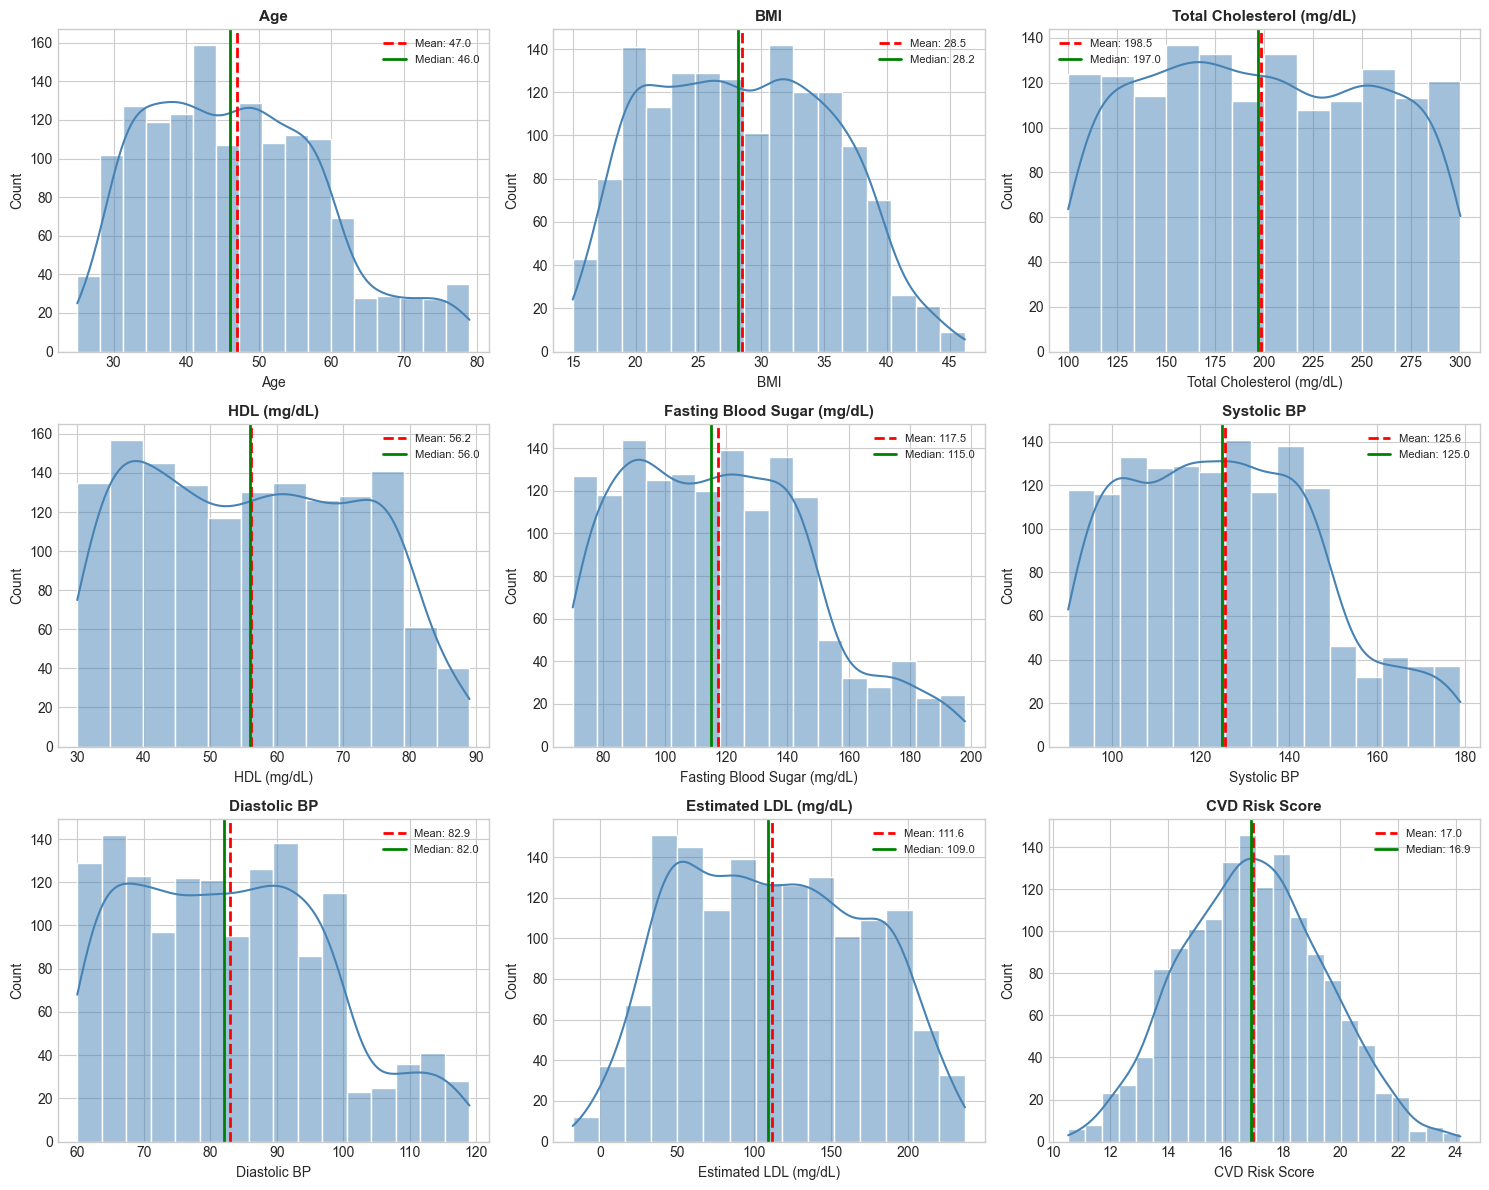

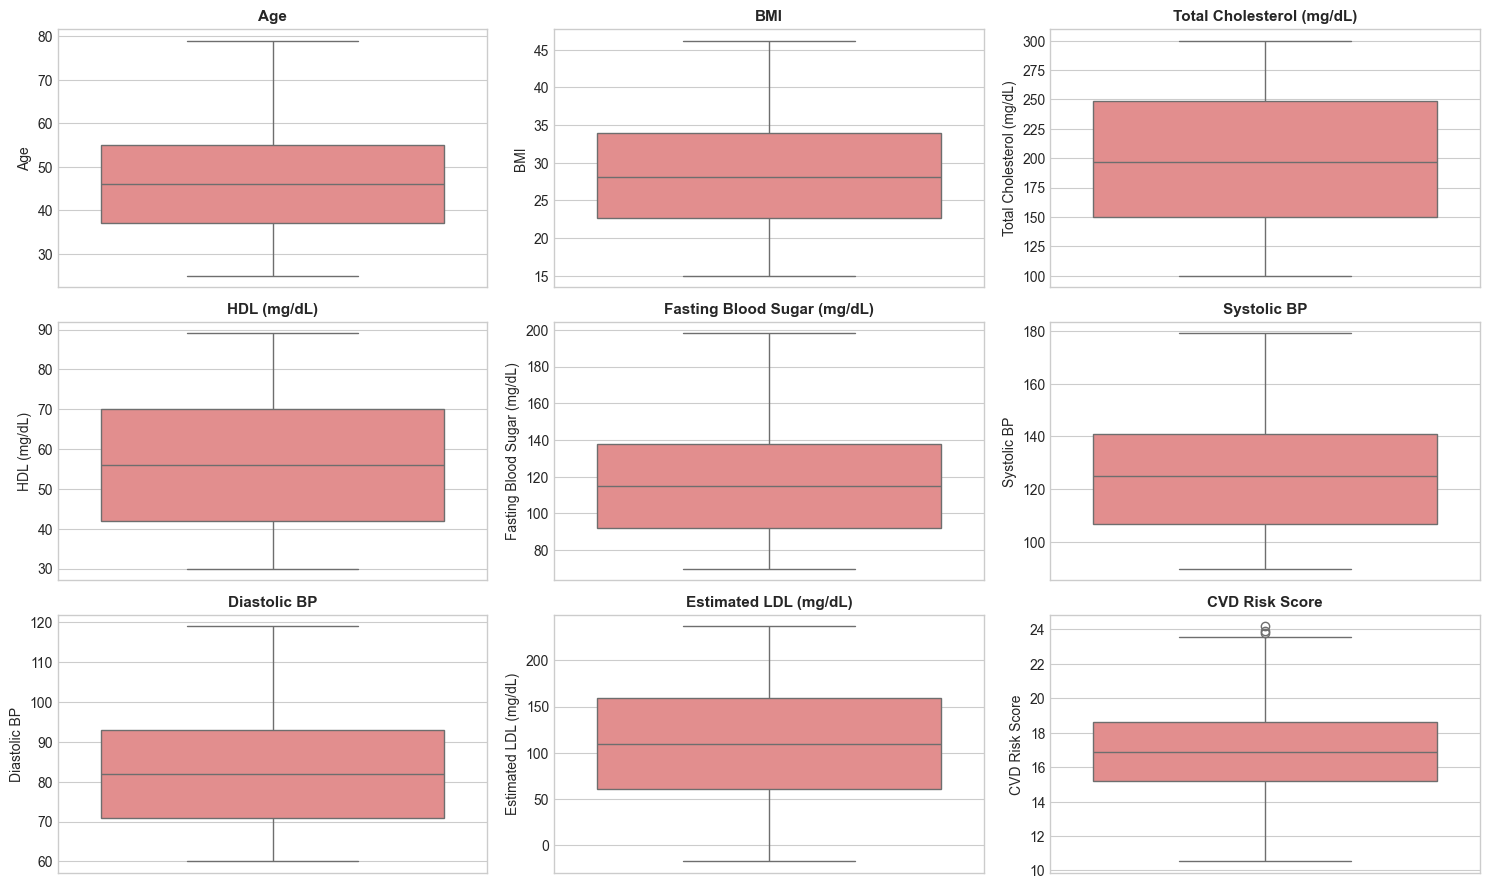

In [19]:
# CELL 7: Numeric Feature Distributions
# ============================================

print("=" * 70)
print("📊 STEP 1.7: NUMERIC FEATURE DISTRIBUTIONS")
print("=" * 70)

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n📋 Found {len(numeric_cols)} numeric columns:")
for i, col in enumerate(numeric_cols, 1):
    print(f"   {i:2d}. {col}")

# Statistical Summary
print("\n" + "─" * 50)
print("📈 STATISTICAL SUMMARY")
print("─" * 50)

stats_summary = df[numeric_cols].describe().T
stats_summary['missing'] = df[numeric_cols].isna().sum()
stats_summary['missing_%'] = (stats_summary['missing'] / len(df) * 100).round(2)
stats_summary['skewness'] = df[numeric_cols].skew()
stats_summary['kurtosis'] = df[numeric_cols].kurtosis()

display(stats_summary.round(3))

# ===== DISTRIBUTION PLOTS =====
print("\n" + "─" * 50)
print("📊 DISTRIBUTION PLOTS (Histograms + Box Plots)")
print("─" * 50)

# Select key clinical features for visualization
key_numeric = ['Age', 'BMI', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 
               'Fasting Blood Sugar (mg/dL)', 'Systolic BP', 'Diastolic BP',
               'Estimated LDL (mg/dL)', 'CVD Risk Score']

# Filter to only existing columns
key_numeric = [col for col in key_numeric if col in df.columns]

n_cols = 3
n_rows = (len(key_numeric) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(key_numeric):
    ax = axes[idx]
    
    # Histogram with KDE
    data = df[col].dropna()
    sns.histplot(data, kde=True, ax=ax, color='steelblue', edgecolor='white')
    
    # Add mean and median lines
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f}')
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)

# Hide empty subplots
for idx in range(len(key_numeric), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(REPORTS_PATH / '03_numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== BOX PLOTS FOR OUTLIER VISUALIZATION =====
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
axes = axes.flatten()

for idx, col in enumerate(key_numeric):
    ax = axes[idx]
    sns.boxplot(data=df, y=col, ax=ax, color='lightcoral')
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')

for idx in range(len(key_numeric), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(REPORTS_PATH / '04_numeric_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 1.8: Categorical Feature Analysis

📊 STEP 1.8: CATEGORICAL FEATURE ANALYSIS

📋 Found 8 categorical columns:
    1. Sex
    2. Blood Pressure (mmHg)
    3. Smoking Status
    4. Diabetes Status
    5. Physical Activity Level
    6. Family History of CVD
    7. CVD Risk Level
    8. Blood Pressure Category

──────────────────────────────────────────────────
📊 VALUE COUNTS FOR EACH CATEGORICAL FEATURE
──────────────────────────────────────────────────

🔹 Sex:
     Count  Percentage
Sex                   
F      773      50.560
M      756      49.440

🔹 Blood Pressure (mmHg):
                       Count  Percentage
Blood Pressure (mmHg)                   
113/77                     4       0.260
114/63                     4       0.260
127/84                     4       0.260
113/79                     4       0.260
148/98                     3       0.200
111/97                     3       0.200
118/67                     3       0.200
106/92                     3       0.200
108/61                     3       0.200
125/6

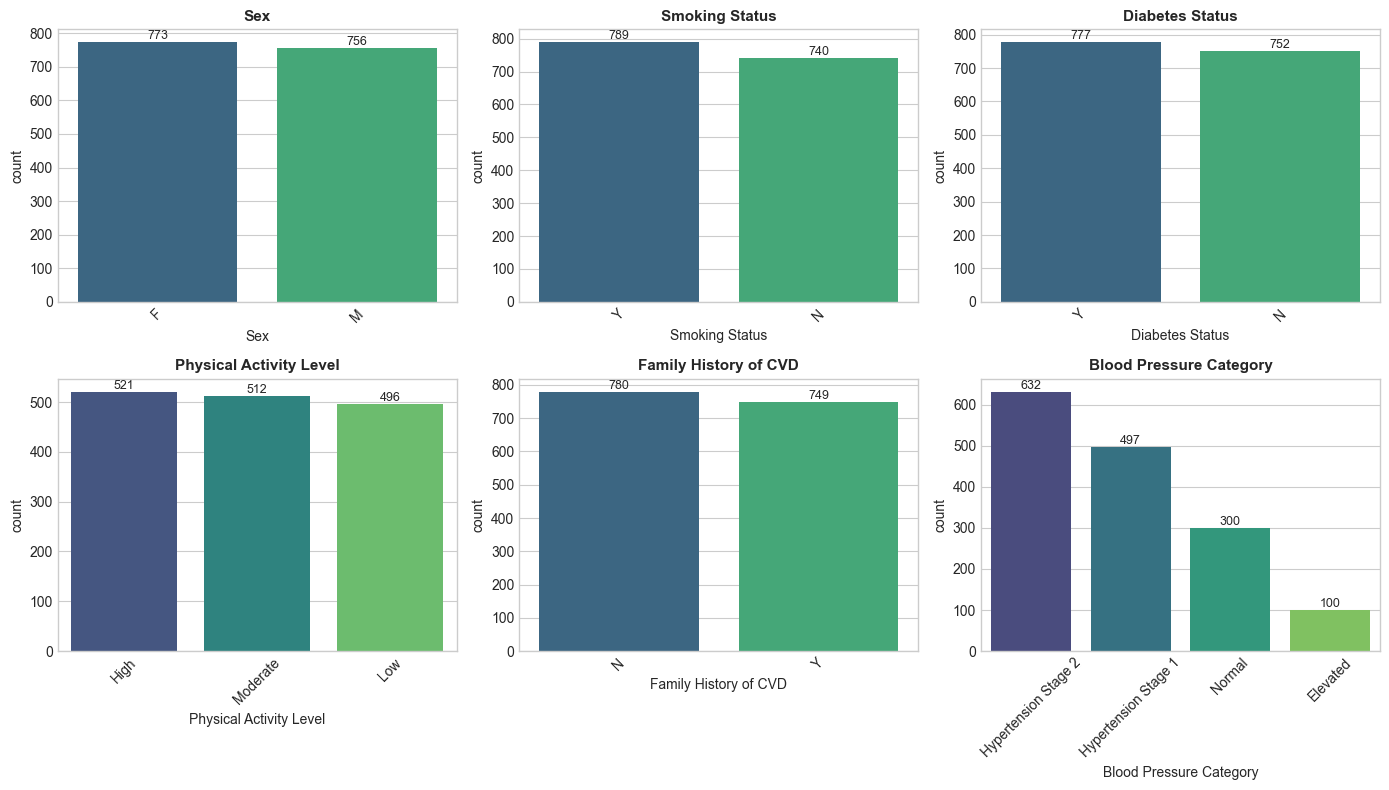

In [20]:
# CELL 8: Categorical Feature Analysis
# ============================================

print("=" * 70)
print("📊 STEP 1.8: CATEGORICAL FEATURE ANALYSIS")
print("=" * 70)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n📋 Found {len(categorical_cols)} categorical columns:")
for i, col in enumerate(categorical_cols, 1):
    print(f"   {i:2d}. {col}")

# ===== VALUE COUNTS FOR EACH CATEGORICAL =====
print("\n" + "─" * 50)
print("📊 VALUE COUNTS FOR EACH CATEGORICAL FEATURE")
print("─" * 50)

for col in categorical_cols:
    print(f"\n🔹 {col}:")
    vc = df[col].value_counts()
    vc_pct = df[col].value_counts(normalize=True) * 100
    summary = pd.DataFrame({'Count': vc, 'Percentage': vc_pct.round(2)})
    print(summary.to_string())

# ===== CATEGORICAL DISTRIBUTION PLOTS =====
print("\n" + "─" * 50)
print("📊 CATEGORICAL DISTRIBUTION PLOTS")
print("─" * 50)

# Exclude the target and redundant columns
cat_to_plot = [col for col in categorical_cols if col not in [TARGET_COLUMN, 'Blood Pressure (mmHg)']]

n_cols = 3
n_rows = (len(cat_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(cat_to_plot):
    ax = axes[idx]
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order, ax=ax, palette='viridis')
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    # Add count labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom', fontsize=9)

for idx in range(len(cat_to_plot), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(REPORTS_PATH / '05_categorical_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## PHASE 2: DATA ENGINEERING & QUALITY ASSURANCE

### Step 2.1: Create Cleaning Pipeline - Handle Anomalies

In [21]:
# CELL 10: Phase 2 - Data Cleaning Pipeline
# ============================================

print("=" * 70)
print("🧹 PHASE 2: DATA ENGINEERING & QUALITY ASSURANCE")
print("=" * 70)

# Create a copy for cleaning
df_clean = df.copy()
cleaning_log = []

print(f"\n📊 Starting Shape: {df_clean.shape}")

# ===== 2.1: REMOVE REDUNDANT/LEAKAGE COLUMNS =====
print("\n" + "─" * 70)
print("🗑️ STEP 2.1: REMOVE REDUNDANT & LEAKAGE FEATURES")
print("─" * 70)

columns_to_drop = [
    'CVD Risk Score',         # Potential leakage
    'Height (cm)',            # Redundant with Height (m)
    'Blood Pressure (mmHg)',  # Already parsed to Systolic/Diastolic
    'Blood Pressure Category' # Derived feature - potential leakage
]

# Check which columns exist before dropping
existing_to_drop = [col for col in columns_to_drop if col in df_clean.columns]

print("Removing columns:")
for col in existing_to_drop:
    print(f"   ❌ {col}")
    
df_clean.drop(columns=existing_to_drop, inplace=True)
cleaning_log.append(f"Removed {len(existing_to_drop)} redundant/leakage columns")

print(f"\n✅ Shape after removal: {df_clean.shape}")

# ===== 2.2: FIX PHYSIOLOGICAL IMPOSSIBILITIES =====
print("\n" + "─" * 70)
print("🏥 STEP 2.2: FIX PHYSIOLOGICAL IMPOSSIBILITIES")
print("─" * 70)

# --- FIX 1: Diastolic > Systolic ---
print("\n🔧 Fix 1: Diastolic BP > Systolic BP")
bp_anomaly_mask = df_clean['Diastolic BP'] > df_clean['Systolic BP']
bp_anomaly_count = bp_anomaly_mask.sum()
print(f"   Found: {bp_anomaly_count} rows with impossible BP readings")

# Strategy: SWAP the values (likely data entry error)
# If Diastolic > Systolic, swap them
df_clean.loc[bp_anomaly_mask, ['Systolic BP', 'Diastolic BP']] = \
    df_clean.loc[bp_anomaly_mask, ['Diastolic BP', 'Systolic BP']].values

# Verify fix
bp_still_wrong = (df_clean['Diastolic BP'] > df_clean['Systolic BP']).sum()
print(f"   After fix: {bp_still_wrong} rows still have issues")
print(f"   ✅ Fixed {bp_anomaly_count - bp_still_wrong} rows by swapping values")
cleaning_log.append(f"Fixed {bp_anomaly_count} rows with BP swap")

# --- FIX 2: Negative/Zero LDL ---
print("\n🔧 Fix 2: Negative/Zero LDL Values")
ldl_anomaly_mask = df_clean['Estimated LDL (mg/dL)'] <= 0
ldl_anomaly_count = ldl_anomaly_mask.sum()
print(f"   Found: {ldl_anomaly_count} rows with impossible LDL values")

# Strategy: Recalculate LDL using Friedewald Formula
# LDL = Total Cholesterol - HDL - (Triglycerides/5)
# Since we don't have Triglycerides, we'll set these to NaN for imputation
df_clean.loc[ldl_anomaly_mask, 'Estimated LDL (mg/dL)'] = np.nan
print(f"   ✅ Set {ldl_anomaly_count} impossible LDL values to NaN (will be imputed)")
cleaning_log.append(f"Set {ldl_anomaly_count} impossible LDL values to NaN")

# ===== 2.3: VERIFY DATA TYPES =====
print("\n" + "─" * 70)
print("🔧 STEP 2.3: VERIFY AND FIX DATA TYPES")
print("─" * 70)

print("\nCurrent data types:")
print(df_clean.dtypes)

# All looks correct - categoricals are object, numerics are float64
print("\n✅ Data types are correct")

# ===== 2.4: DISPLAY CLEANING SUMMARY =====
print("\n" + "─" * 70)
print("📋 CLEANING LOG SUMMARY")
print("─" * 70)
for i, log in enumerate(cleaning_log, 1):
    print(f"   {i}. {log}")

print(f"\n📊 Shape after initial cleaning: {df_clean.shape}")

🧹 PHASE 2: DATA ENGINEERING & QUALITY ASSURANCE

📊 Starting Shape: (1529, 22)

──────────────────────────────────────────────────────────────────────
🗑️ STEP 2.1: REMOVE REDUNDANT & LEAKAGE FEATURES
──────────────────────────────────────────────────────────────────────
Removing columns:
   ❌ CVD Risk Score
   ❌ Height (cm)
   ❌ Blood Pressure (mmHg)
   ❌ Blood Pressure Category

✅ Shape after removal: (1529, 18)

──────────────────────────────────────────────────────────────────────
🏥 STEP 2.2: FIX PHYSIOLOGICAL IMPOSSIBILITIES
──────────────────────────────────────────────────────────────────────

🔧 Fix 1: Diastolic BP > Systolic BP
   Found: 59 rows with impossible BP readings
   After fix: 0 rows still have issues
   ✅ Fixed 59 rows by swapping values

🔧 Fix 2: Negative/Zero LDL Values
   Found: 14 rows with impossible LDL values
   ✅ Set 14 impossible LDL values to NaN (will be imputed)

──────────────────────────────────────────────────────────────────────
🔧 STEP 2.3: VERIFY AND F

### Step 2.2: Missing Value Analysis & Imputation

🔍 STEP 2.4: MISSING VALUE ANALYSIS

📊 Missing Value Visualization:


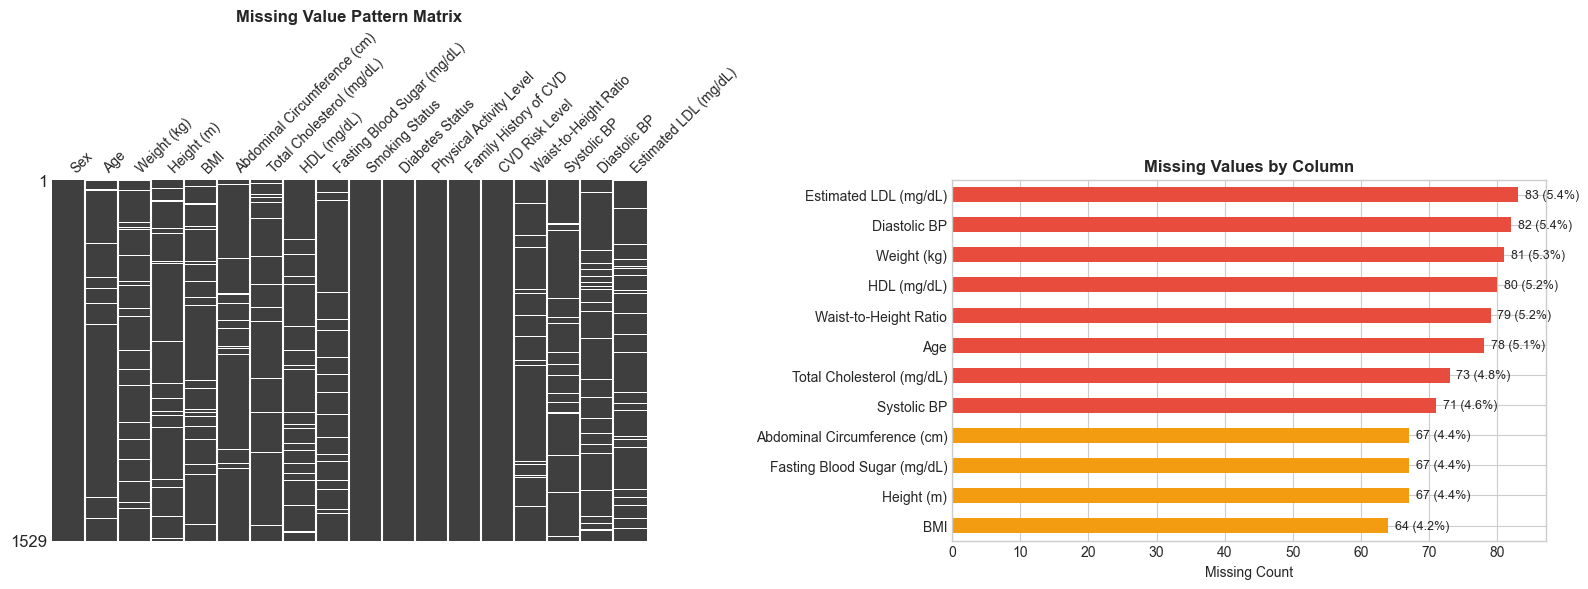


──────────────────────────────────────────────────
📋 MISSING VALUE SUMMARY
──────────────────────────────────────────────────
                      Column  Missing  Percentage
       Estimated LDL (mg/dL)       83       5.430
                Diastolic BP       82       5.360
                 Weight (kg)       81       5.300
                 HDL (mg/dL)       80       5.230
       Waist-to-Height Ratio       79       5.170
                         Age       78       5.100
   Total Cholesterol (mg/dL)       73       4.770
                 Systolic BP       71       4.640
 Fasting Blood Sugar (mg/dL)       67       4.380
                  Height (m)       67       4.380
Abdominal Circumference (cm)       67       4.380
                         BMI       64       4.190

Total cells with missing values: 892


In [22]:
# CELL 11: Missing Value Analysis & Smart Imputation
# ============================================

print("=" * 70)
print("🔍 STEP 2.4: MISSING VALUE ANALYSIS")
print("=" * 70)

# ===== MISSING VALUE HEATMAP =====
import missingno as msno

print("\n📊 Missing Value Visualization:")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matrix plot
plt.subplot(1, 2, 1)
msno.matrix(df_clean, ax=axes[0], sparkline=False, fontsize=10)
axes[0].set_title('Missing Value Pattern Matrix', fontsize=12, fontweight='bold')

# Bar plot
plt.subplot(1, 2, 2)
missing_counts = df_clean.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=True)

colors = ['#e74c3c' if x > 70 else '#f39c12' if x > 50 else '#2ecc71' for x in missing_counts.values]
missing_counts.plot(kind='barh', color=colors, ax=axes[1])
axes[1].set_xlabel('Missing Count')
axes[1].set_title('Missing Values by Column', fontsize=12, fontweight='bold')

for i, v in enumerate(missing_counts.values):
    axes[1].text(v + 1, i, f'{v} ({v/len(df_clean)*100:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(REPORTS_PATH / '06_missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== MISSING VALUE TABLE =====
print("\n" + "─" * 50)
print("📋 MISSING VALUE SUMMARY")
print("─" * 50)

missing_df = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing': df_clean.isna().sum().values,
    'Percentage': (df_clean.isna().sum().values / len(df_clean) * 100).round(2)
})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)
print(missing_df.to_string(index=False))

print(f"\nTotal cells with missing values: {df_clean.isna().sum().sum()}")

### Step 2.3: KNN Imputation (Smart Imputation)

In [23]:
# CELL 12: KNN Imputation for Missing Values
# ============================================

print("=" * 70)
print("🧠 STEP 2.5: KNN IMPUTATION (SMART IMPUTATION)")
print("=" * 70)

print("""
📋 Strategy: KNN Imputation
   - Uses K-Nearest Neighbors to predict missing values
   - Better than mean/median because it considers relationships between features
   - Preserves the underlying data distribution
""")

from sklearn.impute import KNNImputer

# Separate numeric and categorical columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# Remove target from categorical for now
categorical_cols_no_target = [c for c in categorical_cols if c != 'CVD Risk Level']

print(f"\n📊 Numeric columns to impute: {len(numeric_cols)}")
print(f"📊 Categorical columns: {len(categorical_cols)}")

# ===== IMPUTE NUMERIC COLUMNS =====
print("\n" + "─" * 50)
print("🔧 Imputing Numeric Columns with KNN (k=5)")
print("─" * 50)

# Store original missing locations for verification
missing_before = df_clean[numeric_cols].isna().sum().sum()
print(f"Missing values before imputation: {missing_before}")

# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
df_clean[numeric_cols] = knn_imputer.fit_transform(df_clean[numeric_cols])

missing_after = df_clean[numeric_cols].isna().sum().sum()
print(f"Missing values after imputation: {missing_after}")
print(f"✅ Imputed {missing_before - missing_after} values")

# ===== VERIFY IMPUTATION QUALITY =====
print("\n" + "─" * 50)
print("📊 POST-IMPUTATION STATISTICS")
print("─" * 50)

post_impute_stats = df_clean[numeric_cols].describe().T[['mean', 'std', 'min', 'max']]
print(post_impute_stats.round(2))

# ===== CHECK FOR ANY REMAINING MISSING =====
print("\n" + "─" * 50)
print("✅ FINAL MISSING VALUE CHECK")
print("─" * 50)

total_missing = df_clean.isna().sum().sum()
print(f"Total missing values remaining: {total_missing}")

if total_missing == 0:
    print("🎉 All missing values successfully handled!")
else:
    print("⚠️ Some missing values remain - investigating...")
    print(df_clean.isna().sum()[df_clean.isna().sum() > 0])

🧠 STEP 2.5: KNN IMPUTATION (SMART IMPUTATION)

📋 Strategy: KNN Imputation
   - Uses K-Nearest Neighbors to predict missing values
   - Better than mean/median because it considers relationships between features
   - Preserves the underlying data distribution


📊 Numeric columns to impute: 12
📊 Categorical columns: 6

──────────────────────────────────────────────────
🔧 Imputing Numeric Columns with KNN (k=5)
──────────────────────────────────────────────────
Missing values before imputation: 892
Missing values after imputation: 0
✅ Imputed 892 values

──────────────────────────────────────────────────
📊 POST-IMPUTATION STATISTICS
──────────────────────────────────────────────────
                                mean    std     min     max
Age                           47.040 12.170  25.000  79.000
Weight (kg)                   85.870 20.550  50.100 120.000
Height (m)                     1.750  0.110   1.500   2.000
BMI                           28.450  6.960  15.000  46.200
Abdominal C

### Step 2.4: Outlier Analysis & Winsorization

📊 STEP 2.6: OUTLIER ANALYSIS & WINSORIZATION

📋 Strategy: Winsorization (NOT deletion)
   - Cap extreme values at 1st and 99th percentiles
   - Preserves data volume (critical with only 1529 rows)
   - Outliers in medical data often carry signal (very high cholesterol = high risk)


──────────────────────────────────────────────────
🔍 OUTLIER DETECTION (IQR Method)
──────────────────────────────────────────────────
                      Column  Outliers  Percentage  Lower Bound  Upper Bound
       Waist-to-Height Ratio         3       0.200        0.280        0.760
                         Age         0       0.000       10.000       82.000
                  Height (m)         0       0.000        1.410        2.100
                 Weight (kg)         0       0.000       13.450      158.650
                         BMI         0       0.000        6.050       50.450
Abdominal Circumference (cm)         0       0.000       49.390      133.410
                 HDL (mg/dL)         0    

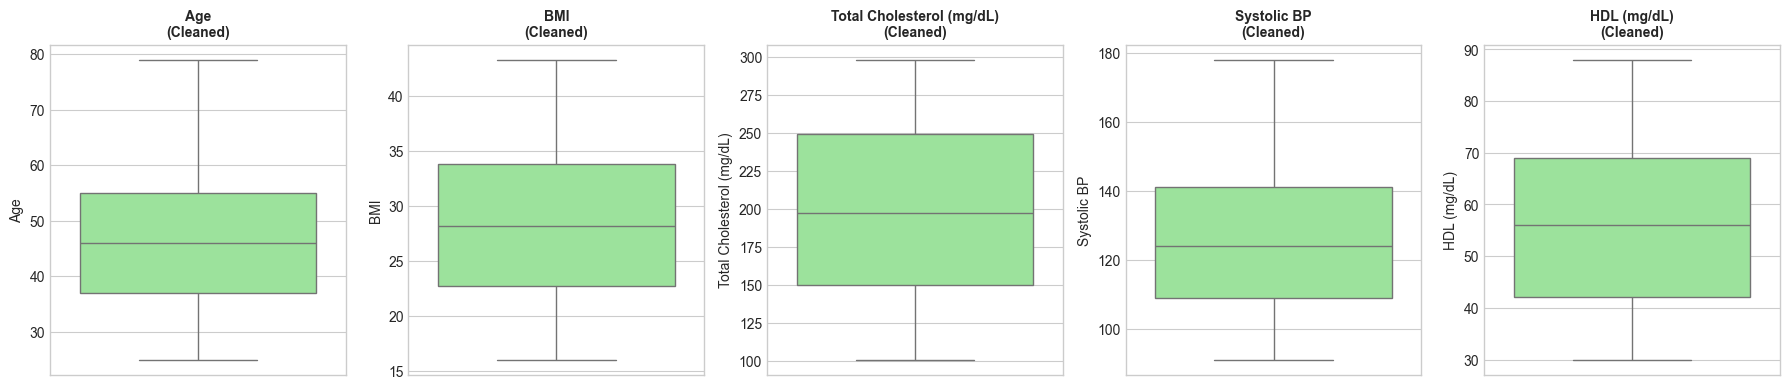

In [24]:
# CELL 13: Outlier Analysis & Winsorization
# ============================================

print("=" * 70)
print("📊 STEP 2.6: OUTLIER ANALYSIS & WINSORIZATION")
print("=" * 70)

print("""
📋 Strategy: Winsorization (NOT deletion)
   - Cap extreme values at 1st and 99th percentiles
   - Preserves data volume (critical with only 1529 rows)
   - Outliers in medical data often carry signal (very high cholesterol = high risk)
""")

from scipy.stats import zscore

# ===== IDENTIFY OUTLIERS USING IQR METHOD =====
print("\n" + "─" * 50)
print("🔍 OUTLIER DETECTION (IQR Method)")
print("─" * 50)

def count_outliers_iqr(series):
    """Count outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((series < lower_bound) | (series > upper_bound)).sum()
    return outliers, lower_bound, upper_bound

outlier_summary = []
for col in numeric_cols:
    count, lower, upper = count_outliers_iqr(df_clean[col])
    pct = count / len(df_clean) * 100
    outlier_summary.append({
        'Column': col,
        'Outliers': count,
        'Percentage': round(pct, 2),
        'Lower Bound': round(lower, 2),
        'Upper Bound': round(upper, 2)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outliers', ascending=False)
print(outlier_df.to_string(index=False))

# ===== APPLY WINSORIZATION =====
print("\n" + "─" * 50)
print("🔧 APPLYING WINSORIZATION (1st - 99th Percentile)")
print("─" * 50)

from scipy.stats.mstats import winsorize

# Columns to winsorize (exclude Age as outliers are valid there)
cols_to_winsorize = [
    'BMI', 'Abdominal Circumference (cm)', 
    'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Estimated LDL (mg/dL)',
    'Fasting Blood Sugar (mg/dL)', 'Systolic BP', 'Diastolic BP',
    'Waist-to-Height Ratio'
]

# Only winsorize columns that exist
cols_to_winsorize = [c for c in cols_to_winsorize if c in df_clean.columns]

for col in cols_to_winsorize:
    original_min = df_clean[col].min()
    original_max = df_clean[col].max()
    
    # Winsorize at 1st and 99th percentile
    df_clean[col] = winsorize(df_clean[col], limits=[0.01, 0.01])
    
    new_min = df_clean[col].min()
    new_max = df_clean[col].max()
    
    if original_min != new_min or original_max != new_max:
        print(f"   {col}: [{original_min:.1f}, {original_max:.1f}] → [{new_min:.1f}, {new_max:.1f}]")

print("\n✅ Winsorization Complete!")

# ===== VISUALIZE BEFORE/AFTER (for key features) =====
print("\n" + "─" * 50)
print("📊 DISTRIBUTION AFTER CLEANING")
print("─" * 50)

key_features = ['Age', 'BMI', 'Total Cholesterol (mg/dL)', 'Systolic BP', 'HDL (mg/dL)']

fig, axes = plt.subplots(1, len(key_features), figsize=(18, 4))

for idx, col in enumerate(key_features):
    ax = axes[idx]
    sns.boxplot(data=df_clean, y=col, ax=ax, color='lightgreen')
    ax.set_title(f'{col}\n(Cleaned)', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_PATH / '07_cleaned_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 2.5: Final Data Quality Check

In [25]:
# CELL 14: Final Data Quality Checkpoint
# ============================================

print("=" * 70)
print("✅ STEP 2.7: FINAL DATA QUALITY CHECKPOINT")
print("=" * 70)

# ===== COMPREHENSIVE QUALITY CHECK =====
print("\n" + "─" * 50)
print("🔍 FINAL QUALITY VERIFICATION")
print("─" * 50)

checks_passed = 0
total_checks = 6

# Check 1: No missing values
missing = df_clean.isna().sum().sum()
if missing == 0:
    print("✅ Check 1: No missing values")
    checks_passed += 1
else:
    print(f"❌ Check 1: {missing} missing values remain")

# Check 2: No impossible BP values
bp_issues = (df_clean['Diastolic BP'] > df_clean['Systolic BP']).sum()
if bp_issues == 0:
    print("✅ Check 2: All BP readings physiologically valid")
    checks_passed += 1
else:
    print(f"❌ Check 2: {bp_issues} impossible BP readings")

# Check 3: No negative LDL
ldl_issues = (df_clean['Estimated LDL (mg/dL)'] < 0).sum()
if ldl_issues == 0:
    print("✅ Check 3: No negative LDL values")
    checks_passed += 1
else:
    print(f"❌ Check 3: {ldl_issues} negative LDL values")

# Check 4: Target has no nulls
target_nulls = df_clean['CVD Risk Level'].isna().sum()
if target_nulls == 0:
    print("✅ Check 4: Target variable complete")
    checks_passed += 1
else:
    print(f"❌ Check 4: {target_nulls} missing target values")

# Check 5: No duplicate rows
duplicates = df_clean.duplicated().sum()
if duplicates == 0:
    print("✅ Check 5: No duplicate rows")
    checks_passed += 1
else:
    print(f"⚠️ Check 5: {duplicates} duplicate rows found")
    df_clean.drop_duplicates(inplace=True)
    print(f"   → Removed duplicates. New shape: {df_clean.shape}")
    checks_passed += 1

# Check 6: All expected columns present
expected_cols = ['Age', 'Sex', 'BMI', 'Systolic BP', 'Diastolic BP', 
                 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'CVD Risk Level']
missing_cols = [c for c in expected_cols if c not in df_clean.columns]
if len(missing_cols) == 0:
    print("✅ Check 6: All essential columns present")
    checks_passed += 1
else:
    print(f"❌ Check 6: Missing columns: {missing_cols}")

# ===== QUALITY SCORE =====
print("\n" + "─" * 50)
quality_score = (checks_passed / total_checks) * 100

print(f"""
┌────────────────────────────────────────────────────┐
│           PHASE 2 COMPLETION REPORT                │
├────────────────────────────────────────────────────┤
│  Checks Passed: {checks_passed}/{total_checks}                              │
│  Quality Score: {quality_score:.0f}%                                │
│  Final Shape:   {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns          │
│  Status:        {'READY FOR PHASE 3 ✓' if quality_score == 100 else 'NEEDS ATTENTION ⚠️'}            │
└────────────────────────────────────────────────────┘
""")

# ===== SAVE CLEANED DATA =====
print("💾 Saving cleaned dataset...")
df_clean.to_csv(DATA_PROCESSED / 'cvd_cleaned.csv', index=False)
print(f"✅ Saved to: {DATA_PROCESSED / 'cvd_cleaned.csv'}")

# Display final column list
print("\n📋 Final Columns in Cleaned Dataset:")
for i, col in enumerate(df_clean.columns, 1):
    dtype = df_clean[col].dtype
    print(f"   {i:2d}. {col} ({dtype})")

✅ STEP 2.7: FINAL DATA QUALITY CHECKPOINT

──────────────────────────────────────────────────
🔍 FINAL QUALITY VERIFICATION
──────────────────────────────────────────────────
✅ Check 1: No missing values
✅ Check 2: All BP readings physiologically valid
✅ Check 3: No negative LDL values
✅ Check 4: Target variable complete
✅ Check 5: No duplicate rows
✅ Check 6: All essential columns present

──────────────────────────────────────────────────

┌────────────────────────────────────────────────────┐
│           PHASE 2 COMPLETION REPORT                │
├────────────────────────────────────────────────────┤
│  Checks Passed: 6/6                              │
│  Quality Score: 100%                                │
│  Final Shape:   1,529 rows × 18 columns          │
│  Status:        READY FOR PHASE 3 ✓            │
└────────────────────────────────────────────────────┘

💾 Saving cleaned dataset...
✅ Saved to: c:\Users\abhis\CVD_PREDICTION_SYSTEM\data\processed\cvd_cleaned.csv

📋 Final Colu

## 🧬 PHASE 3: CLINICAL FEATURE ENGINEERING

### Step 3.1: Create Clinical Features

In [ ]:
# CELL 15: Phase 3 - Clinical Feature Engineering
# ============================================

print("=" * 70)
print("🧬 PHASE 3: CLINICAL FEATURE ENGINEERING")
print("=" * 70)

print("""
📋 We will create features that cardiologists actually use:
   - Vascular indicators (Pulse Pressure, MAP)
   - Lipid ratios (Castelli Index)
   - Risk interaction terms
   - Age-based risk categories
""")

# Load the cleaned data 
df_fe = df_clean.copy()
print(f"\n📊 Starting Shape: {df_fe.shape}")

# Track new features
new_features = []

# ===== 3.1: VASCULAR INDICATORS =====
print("\n" + "─" * 70)
print("🫀 STEP 3.1: VASCULAR INDICATORS")
print("─" * 70)

# 1. Pulse Pressure (PP) = Systolic - Diastolic
# Clinical significance: Indicator of arterial stiffness
df_fe['Pulse_Pressure'] = df_fe['Systolic BP'] - df_fe['Diastolic BP']
new_features.append('Pulse_Pressure')
print(f"✅ Pulse Pressure: Systolic - Diastolic")
print(f"   Range: {df_fe['Pulse_Pressure'].min():.1f} - {df_fe['Pulse_Pressure'].max():.1f} mmHg")
print(f"   Normal range: 40-60 mmHg | High PP = arterial stiffness")

# 2. Mean Arterial Pressure (MAP) = (Systolic + 2*Diastolic) / 3
# Clinical significance: Average pressure in arteries during one cardiac cycle
df_fe['MAP'] = (df_fe['Systolic BP'] + 2 * df_fe['Diastolic BP']) / 3
new_features.append('MAP')
print(f"\n✅ Mean Arterial Pressure (MAP): (Systolic + 2×Diastolic) / 3")
print(f"   Range: {df_fe['MAP'].min():.1f} - {df_fe['MAP'].max():.1f} mmHg")
print(f"   Normal: 70-100 mmHg | Target organ perfusion indicator")

# ===== 3.2: LIPID RATIOS (CASTELLI RISK INDEX) =====
print("\n" + "─" * 70)
print("🩸 STEP 3.2: LIPID RATIOS (CASTELLI INDEX)")
print("─" * 70)

# 3. Castelli Risk Index I = Total Cholesterol / HDL
# Clinical significance: <4.5 (men) or <4.0 (women) is desirable
df_fe['Castelli_Index_I'] = df_fe['Total Cholesterol (mg/dL)'] / df_fe['HDL (mg/dL)']
new_features.append('Castelli_Index_I')
print(f"✅ Castelli Risk Index I: Total Cholesterol / HDL")
print(f"   Range: {df_fe['Castelli_Index_I'].min():.2f} - {df_fe['Castelli_Index_I'].max():.2f}")
print(f"   Risk: <3.5 = Low | 3.5-5.0 = Moderate | >5.0 = High")

# 4. Castelli Risk Index II = LDL / HDL
# Clinical significance: <2.5 is optimal
df_fe['Castelli_Index_II'] = df_fe['Estimated LDL (mg/dL)'] / df_fe['HDL (mg/dL)']
new_features.append('Castelli_Index_II')
print(f"\n✅ Castelli Risk Index II: LDL / HDL")
print(f"   Range: {df_fe['Castelli_Index_II'].min():.2f} - {df_fe['Castelli_Index_II'].max():.2f}")
print(f"   Risk: <2.0 = Optimal | 2.0-3.0 = Near Optimal | >3.0 = High")

# 5. Non-HDL Cholesterol = Total Cholesterol - HDL
# Clinical significance: Better predictor than LDL alone
df_fe['Non_HDL_Cholesterol'] = df_fe['Total Cholesterol (mg/dL)'] - df_fe['HDL (mg/dL)']
new_features.append('Non_HDL_Cholesterol')
print(f"\n✅ Non-HDL Cholesterol: Total Cholesterol - HDL")
print(f"   Range: {df_fe['Non_HDL_Cholesterol'].min():.1f} - {df_fe['Non_HDL_Cholesterol'].max():.1f} mg/dL")

# ===== 3.3: METABOLIC INDICATORS =====
print("\n" + "─" * 70)
print("⚡ STEP 3.3: METABOLIC INDICATORS")
print("─" * 70)

# 6. BMI Category (encoded as ordinal)
def bmi_category(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif bmi < 25:
        return 1  # Normal
    elif bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

df_fe['BMI_Category'] = df_fe['BMI'].apply(bmi_category)
new_features.append('BMI_Category')
print(f"✅ BMI Category: 0=Underweight, 1=Normal, 2=Overweight, 3=Obese")
print(f"   Distribution: {df_fe['BMI_Category'].value_counts().sort_index().to_dict()}")

# 7. Diabetes-Glucose Interaction
# High fasting glucose in diabetic is worse than in non-diabetic
df_fe['Diabetes_Binary'] = (df_fe['Diabetes Status'] == 'Y').astype(int)
df_fe['Diabetes_Glucose_Risk'] = df_fe['Diabetes_Binary'] * df_fe['Fasting Blood Sugar (mg/dL)']
new_features.append('Diabetes_Glucose_Risk')
print(f"\n✅ Diabetes × Glucose Interaction")
print(f"   Captures: Amplified risk when diabetic has high glucose")

# ===== 3.4: AGE-BASED RISK FEATURES =====
print("\n" + "─" * 70)
print("👴 STEP 3.4: AGE-BASED RISK FEATURES")
print("─" * 70)

# 8. Age Groups (Clinical categories)
def age_group(age):
    if age < 35:
        return 0  # Young adult
    elif age < 45:
        return 1  # Early middle age
    elif age < 55:
        return 2  # Middle age
    elif age < 65:
        return 3  # Late middle age
    else:
        return 4  # Senior

df_fe['Age_Group'] = df_fe['Age'].apply(age_group)
new_features.append('Age_Group')
print(f"✅ Age Groups: 0=<35, 1=35-44, 2=45-54, 3=55-64, 4=65+")
print(f"   Distribution: {df_fe['Age_Group'].value_counts().sort_index().to_dict()}")

# 9. Age × Smoking Interaction
# Smoking damage accumulates with age
df_fe['Smoking_Binary'] = (df_fe['Smoking Status'] == 'Y').astype(int)
df_fe['Age_Smoking_Risk'] = df_fe['Age'] * df_fe['Smoking_Binary']
new_features.append('Age_Smoking_Risk')
print(f"\n✅ Age × Smoking Interaction")
print(f"   Captures: Cumulative smoking damage over lifetime")

# 10. Age × BP Interaction
# High BP is more dangerous as you age
df_fe['Age_BP_Risk'] = df_fe['Age'] * df_fe['Systolic BP'] / 100  # Scaled
new_features.append('Age_BP_Risk')
print(f"\n✅ Age × Blood Pressure Interaction")
print(f"   Captures: Age-related vascular strain")

# ===== 3.5: FAMILY HISTORY RISK AMPLIFIER =====
print("\n" + "─" * 70)
print("🧬 STEP 3.5: GENETIC RISK FEATURES")
print("─" * 70)

# 11. Family History Binary
df_fe['Family_History_Binary'] = (df_fe['Family History of CVD'] == 'Y').astype(int)
new_features.append('Family_History_Binary')
print(f"✅ Family History Binary Encoding")

# 12. Family History × Age Interaction
# Family history becomes more relevant with age
df_fe['Family_Age_Risk'] = df_fe['Family_History_Binary'] * df_fe['Age']
new_features.append('Family_Age_Risk')
print(f"✅ Family History × Age Interaction")

# ===== 3.6: PHYSICAL ACTIVITY ENCODING =====
print("\n" + "─" * 70)
print("🏃 STEP 3.6: LIFESTYLE FEATURES")
print("─" * 70)

# 13. Physical Activity (Ordinal encoding)
activity_map = {'Low': 0, 'Moderate': 1, 'High': 2}
df_fe['Physical_Activity_Encoded'] = df_fe['Physical Activity Level'].map(activity_map)
new_features.append('Physical_Activity_Encoded')
print(f"✅ Physical Activity: Low=0, Moderate=1, High=2")
print(f"   Distribution: {df_fe['Physical_Activity_Encoded'].value_counts().sort_index().to_dict()}")

# 14. Sedentary Risk Score = Low Activity + High BMI + Diabetes
df_fe['Sedentary_Risk'] = ((df_fe['Physical_Activity_Encoded'] == 0).astype(int) + 
                            (df_fe['BMI_Category'] >= 2).astype(int) + 
                            df_fe['Diabetes_Binary'])
new_features.append('Sedentary_Risk')
print(f"\n✅ Sedentary Risk Score (0-3)")
print(f"   Combines: Low activity + Overweight/Obese + Diabetes")

# ===== 3.7: COMPREHENSIVE RISK FEATURES =====
print("\n" + "─" * 70)
print("⚠️ STEP 3.7: COMPOSITE RISK SCORES")
print("─" * 70)

# 15. Hypertension Stage (based on ACC/AHA guidelines)
def hypertension_stage(row):
    sys = row['Systolic BP']
    dia = row['Diastolic BP']
    if sys < 120 and dia < 80:
        return 0  # Normal
    elif sys < 130 and dia < 80:
        return 1  # Elevated
    elif sys < 140 or dia < 90:
        return 2  # Stage 1
    else:
        return 3  # Stage 2

df_fe['Hypertension_Stage'] = df_fe.apply(hypertension_stage, axis=1)
new_features.append('Hypertension_Stage')
print(f"✅ Hypertension Stage (ACC/AHA 2017): 0=Normal, 1=Elevated, 2=Stage1, 3=Stage2")
print(f"   Distribution: {df_fe['Hypertension_Stage'].value_counts().sort_index().to_dict()}")

# 16. Metabolic Syndrome Risk Score (simplified)
# Count of: High BP + High Glucose + High Waist + Low HDL + High Triglycerides(approximated)
df_fe['MetSyn_Score'] = (
    (df_fe['Systolic BP'] >= 130).astype(int) +
    (df_fe['Fasting Blood Sugar (mg/dL)'] >= 100).astype(int) +
    (df_fe['Waist-to-Height Ratio'] >= 0.5).astype(int) +
    (df_fe['HDL (mg/dL)'] < 40).astype(int) +
    (df_fe['Castelli_Index_I'] > 5).astype(int)
)
new_features.append('MetSyn_Score')
print(f"\n✅ Metabolic Syndrome Score (0-5)")
print(f"   Distribution: {df_fe['MetSyn_Score'].value_counts().sort_index().to_dict()}")

# ===== FEATURE ENGINEERING SUMMARY =====
print("\n" + "=" * 70)
print("📊 FEATURE ENGINEERING SUMMARY")
print("=" * 70)

print(f"\n🆕 New Features Created: {len(new_features)}")
for i, feat in enumerate(new_features, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n📊 Final Shape: {df_fe.shape}")
print(f"   Original columns: 18")
print(f"   New features: {len(new_features)}")
print(f"   Total columns: {df_fe.shape[1]}")

🧬 PHASE 3: CLINICAL FEATURE ENGINEERING

📋 We will create features that cardiologists actually use:
   - Vascular indicators (Pulse Pressure, MAP)
   - Lipid ratios (Castelli Index)
   - Risk interaction terms
   - Age-based risk categories


📊 Starting Shape: (1529, 18)

──────────────────────────────────────────────────────────────────────
🫀 STEP 3.1: VASCULAR INDICATORS
──────────────────────────────────────────────────────────────────────
✅ Pulse Pressure: Systolic - Diastolic
   Range: 0.0 - 115.0 mmHg
   Normal range: 40-60 mmHg | High PP = arterial stiffness

✅ Mean Arterial Pressure (MAP): (Systolic + 2×Diastolic) / 3
   Range: 70.7 - 134.0 mmHg
   Normal: 70-100 mmHg | Target organ perfusion indicator

──────────────────────────────────────────────────────────────────────
🩸 STEP 3.2: LIPID RATIOS (CASTELLI INDEX)
──────────────────────────────────────────────────────────────────────
✅ Castelli Risk Index I: Total Cholesterol / HDL
   Range: 1.15 - 9.80
   Risk: <3.5 = Low | 3.

### Step 3.2: Feature Correlation Analysis

📊 STEP 3.8: FEATURE CORRELATION ANALYSIS

📊 Analyzing 30 numeric features

──────────────────────────────────────────────────
⚠️ HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)
──────────────────────────────────────────────────
                   Feature 1             Feature 2  Correlation
            Castelli_Index_I     Castelli_Index_II        0.991
       Estimated LDL (mg/dL)   Non_HDL_Cholesterol        0.990
                         Age             Age_Group        0.968
   Total Cholesterol (mg/dL)   Non_HDL_Cholesterol        0.963
   Total Cholesterol (mg/dL) Estimated LDL (mg/dL)        0.959
       Family_History_Binary       Family_Age_Risk        0.943
             Diabetes_Binary Diabetes_Glucose_Risk        0.940
              Smoking_Binary      Age_Smoking_Risk        0.937
                         BMI          BMI_Category        0.922
Abdominal Circumference (cm) Waist-to-Height Ratio        0.867
       Estimated LDL (mg/dL)     Castelli_Index_II        0.860
        

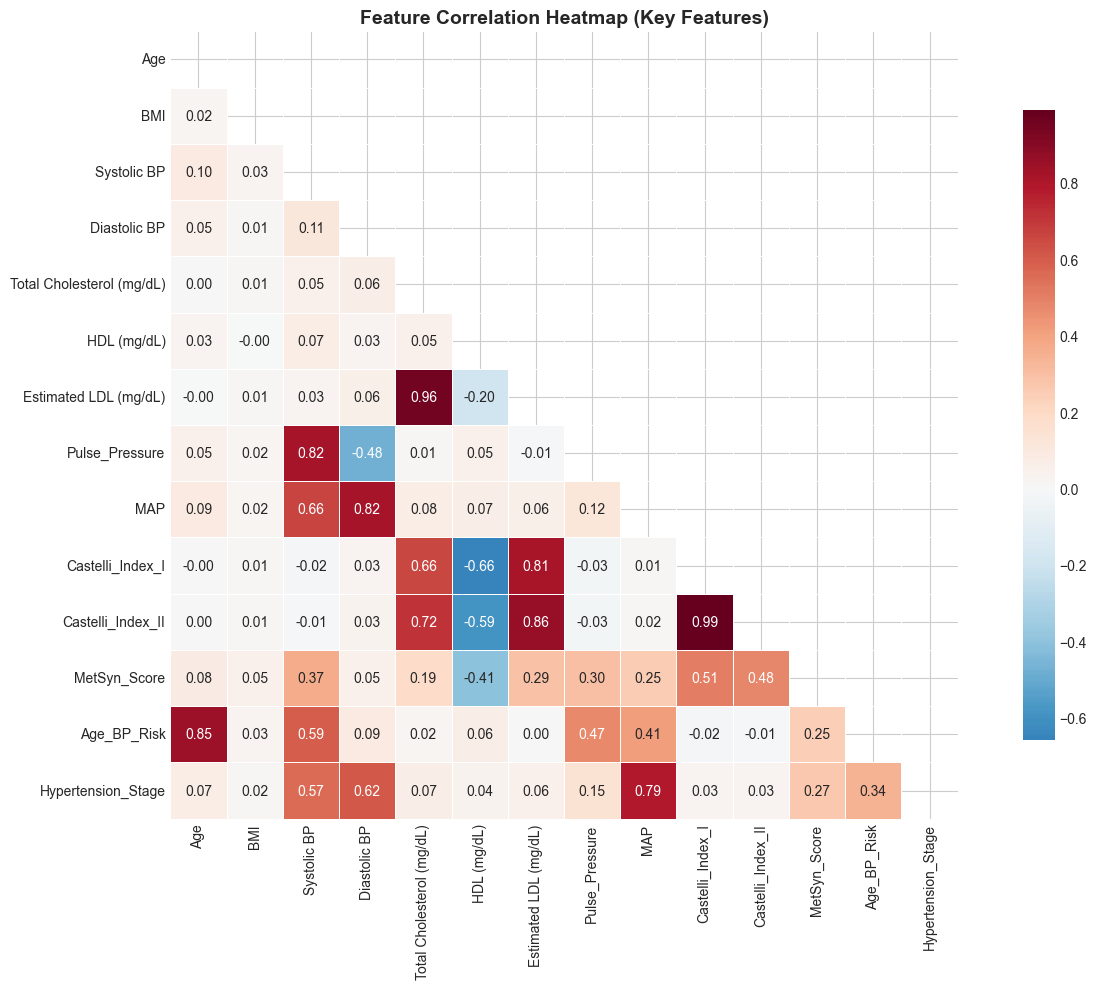

In [27]:
# CELL 16: Feature Correlation Analysis
# ============================================

print("=" * 70)
print("📊 STEP 3.8: FEATURE CORRELATION ANALYSIS")
print("=" * 70)

# Get all numeric columns
numeric_features = df_fe.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n📊 Analyzing {len(numeric_features)} numeric features")

# ===== CORRELATION MATRIX =====
correlation_matrix = df_fe[numeric_features].corr()

# Find highly correlated pairs (potential multicollinearity)
print("\n" + "─" * 50)
print("⚠️ HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)")
print("─" * 50)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': round(corr_val, 3)
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(high_corr_df.to_string(index=False))
    print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated pairs")
    print("   These may cause multicollinearity - will handle in modeling")
else:
    print("✅ No highly correlated pairs found (|r| > 0.8)")

# ===== CORRELATION HEATMAP =====
print("\n" + "─" * 50)
print("📊 CORRELATION HEATMAP")
print("─" * 50)

# Select key features for visualization (too many for full heatmap)
key_features_for_corr = [
    'Age', 'BMI', 'Systolic BP', 'Diastolic BP', 
    'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Estimated LDL (mg/dL)',
    'Pulse_Pressure', 'MAP', 'Castelli_Index_I', 'Castelli_Index_II',
    'MetSyn_Score', 'Age_BP_Risk', 'Hypertension_Stage'
]

# Filter to existing columns
key_features_for_corr = [f for f in key_features_for_corr if f in df_fe.columns]

plt.figure(figsize=(14, 10))
corr_subset = df_fe[key_features_for_corr].corr()
mask = np.triu(np.ones_like(corr_subset, dtype=bool))

sns.heatmap(corr_subset, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.8})

plt.title('Feature Correlation Heatmap (Key Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS_PATH / '08_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 3.3: Feature Importance Preview (with Target)

🎯 STEP 3.9: FEATURE-TARGET RELATIONSHIP ANALYSIS

🎯 Target Encoding: {'HIGH': np.int64(0), 'INTERMEDIARY': np.int64(1), 'LOW': np.int64(2)}

──────────────────────────────────────────────────
📊 NUMERIC FEATURES VS TARGET (Point-Biserial Correlation)
──────────────────────────────────────────────────

Top 15 Features Most Correlated with CVD Risk:
HDL (mg/dL)                     0.172
Physical_Activity_Encoded       0.140
MAP                             0.102
Systolic BP                     0.098
Diastolic BP                    0.059
Hypertension_Stage              0.059
Age_BP_Risk                     0.055
Pulse_Pressure                  0.053
Abdominal Circumference (cm)    0.048
Fasting Blood Sugar (mg/dL)     0.048
Waist-to-Height Ratio           0.042
Height (m)                      0.019
Age                            -0.009
Age_Group                      -0.024
MetSyn_Score                   -0.080

Bottom 5 Features (Negative Correlation):
Non_HDL_Cholesterol     -0.170
Family_

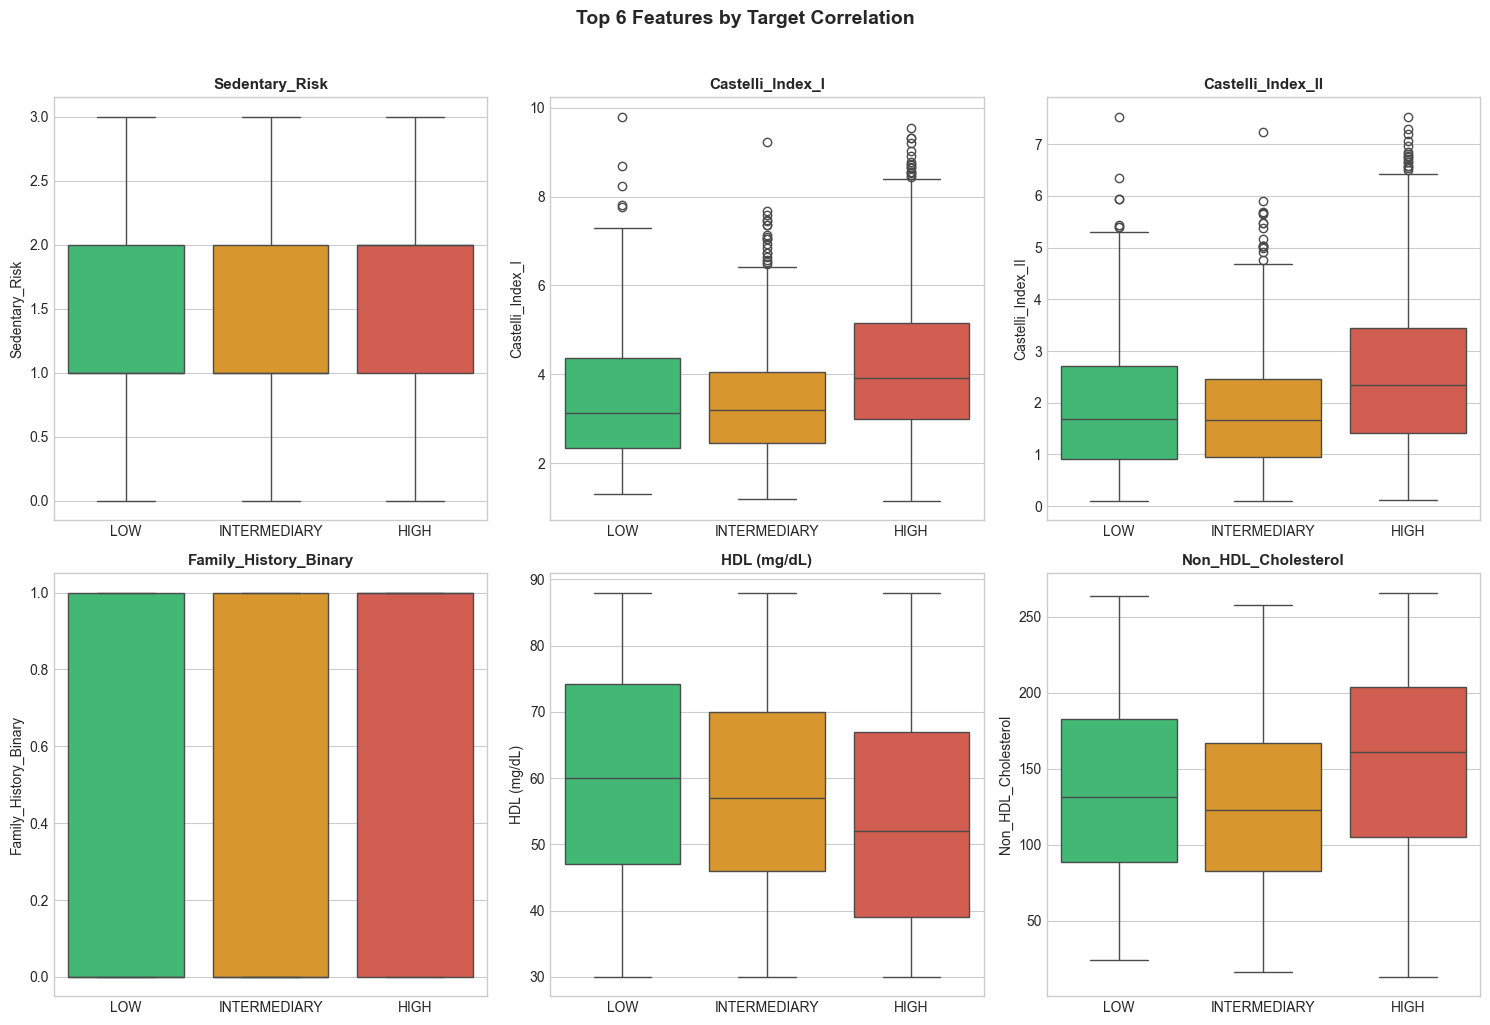


──────────────────────────────────────────────────
📊 CATEGORICAL FEATURES VS TARGET (Chi-Square Test)
──────────────────────────────────────────────────
                Feature  Chi2 Statistic  P-Value Significant
                    Sex           1.380 5.01e-01        ❌ No
         Smoking Status          69.270 9.10e-16       ✅ Yes
        Diabetes Status          62.310 2.94e-14       ✅ Yes
Physical Activity Level          50.940 2.30e-10       ✅ Yes
  Family History of CVD          60.030 9.20e-14       ✅ Yes


In [28]:
# CELL 17: Feature-Target Relationship Analysis
# ============================================

print("=" * 70)
print("🎯 STEP 3.9: FEATURE-TARGET RELATIONSHIP ANALYSIS")
print("=" * 70)

# Encode target for analysis
from sklearn.preprocessing import LabelEncoder

le_target = LabelEncoder()
df_fe['Target_Encoded'] = le_target.fit_transform(df_fe['CVD Risk Level'])

print(f"\n🎯 Target Encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# ===== NUMERIC FEATURES VS TARGET =====
print("\n" + "─" * 50)
print("📊 NUMERIC FEATURES VS TARGET (Point-Biserial Correlation)")
print("─" * 50)

# Calculate correlation with target
target_corr = df_fe[numeric_features].corrwith(df_fe['Target_Encoded']).sort_values(ascending=False)

print("\nTop 15 Features Most Correlated with CVD Risk:")
print(target_corr.head(15).to_string())

print("\nBottom 5 Features (Negative Correlation):")
print(target_corr.tail(5).to_string())

# ===== VISUALIZE TOP FEATURES BY TARGET =====
print("\n" + "─" * 50)
print("📊 TOP FEATURES DISTRIBUTION BY CVD RISK LEVEL")
print("─" * 50)

top_features = target_corr.abs().sort_values(ascending=False).head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

order = ['LOW', 'INTERMEDIARY', 'HIGH']
colors = ['#2ecc71', '#f39c12', '#e74c3c']

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    sns.boxplot(data=df_fe, x='CVD Risk Level', y=feature, order=order, palette=colors, ax=ax)
    ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    
plt.suptitle('Top 6 Features by Target Correlation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(REPORTS_PATH / '09_top_features_by_target.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== CATEGORICAL FEATURES VS TARGET =====
print("\n" + "─" * 50)
print("📊 CATEGORICAL FEATURES VS TARGET (Chi-Square Test)")
print("─" * 50)

categorical_features = ['Sex', 'Smoking Status', 'Diabetes Status', 
                        'Physical Activity Level', 'Family History of CVD']

chi2_results = []
for feature in categorical_features:
    contingency = pd.crosstab(df_fe[feature], df_fe['CVD Risk Level'])
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    chi2_results.append({
        'Feature': feature,
        'Chi2 Statistic': round(chi2, 2),
        'P-Value': f"{p_value:.2e}",
        'Significant': '✅ Yes' if p_value < 0.05 else '❌ No'
    })

chi2_df = pd.DataFrame(chi2_results)
print(chi2_df.to_string(index=False))

# Remove temporary encoded target
df_fe.drop('Target_Encoded', axis=1, inplace=True)

### Step 3.4: Save Engineered Dataset

In [29]:
# CELL 18: Save Feature Engineered Dataset
# ============================================

print("=" * 70)
print("💾 STEP 3.10: SAVE FEATURE ENGINEERED DATASET")
print("=" * 70)

# ===== FINAL FEATURE LIST =====
print("\n📋 FINAL FEATURE LIST")
print("─" * 50)

# Categorize all columns
final_columns = {
    'TARGET': ['CVD Risk Level'],
    
    'ORIGINAL_NUMERIC': [
        'Age', 'Weight (kg)', 'Height (m)', 'BMI', 
        'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)',
        'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 
        'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP',
        'Estimated LDL (mg/dL)'
    ],
    
    'ORIGINAL_CATEGORICAL': [
        'Sex', 'Smoking Status', 'Diabetes Status',
        'Physical Activity Level', 'Family History of CVD'
    ],
    
    'ENGINEERED_FEATURES': new_features,
    
    'HELPER_COLUMNS': ['Diabetes_Binary', 'Smoking_Binary', 'Family_History_Binary']
}

for category, cols in final_columns.items():
    existing = [c for c in cols if c in df_fe.columns]
    print(f"\n{category} ({len(existing)} columns):")
    for c in existing:
        print(f"   • {c}")

# ===== FINAL SHAPE =====
print("\n" + "─" * 50)
print(f"""
┌────────────────────────────────────────────────────┐
│           PHASE 3 COMPLETION REPORT                │
├────────────────────────────────────────────────────┤
│  Original Features:     18                         │
│  Engineered Features:   {len(new_features)}                         │
│  Total Features:        {df_fe.shape[1]}                         │
│  Total Samples:         {df_fe.shape[0]:,}                       │
│  Status:                READY FOR PHASE 4 ✓        │
└────────────────────────────────────────────────────┘
""")

# ===== SAVE DATASET =====
df_fe.to_csv(DATA_PROCESSED / 'cvd_feature_engineered.csv', index=False)
print(f"✅ Saved to: {DATA_PROCESSED / 'cvd_feature_engineered.csv'}")

# ===== DISPLAY SAMPLE =====
print("\n📊 Sample of Engineered Dataset (First 3 rows):")
display(df_fe.head(3))

💾 STEP 3.10: SAVE FEATURE ENGINEERED DATASET

📋 FINAL FEATURE LIST
──────────────────────────────────────────────────

TARGET (1 columns):
   • CVD Risk Level

ORIGINAL_NUMERIC (12 columns):
   • Age
   • Weight (kg)
   • Height (m)
   • BMI
   • Abdominal Circumference (cm)
   • Total Cholesterol (mg/dL)
   • HDL (mg/dL)
   • Fasting Blood Sugar (mg/dL)
   • Waist-to-Height Ratio
   • Systolic BP
   • Diastolic BP
   • Estimated LDL (mg/dL)

ORIGINAL_CATEGORICAL (5 columns):
   • Sex
   • Smoking Status
   • Diabetes Status
   • Physical Activity Level
   • Family History of CVD

ENGINEERED_FEATURES (16 columns):
   • Pulse_Pressure
   • MAP
   • Castelli_Index_I
   • Castelli_Index_II
   • Non_HDL_Cholesterol
   • BMI_Category
   • Diabetes_Glucose_Risk
   • Age_Group
   • Age_Smoking_Risk
   • Age_BP_Risk
   • Family_History_Binary
   • Family_Age_Risk
   • Physical_Activity_Encoded
   • Sedentary_Risk
   • Hypertension_Stage
   • MetSyn_Score

HELPER_COLUMNS (3 columns):
   • Diabe

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,CVD Risk Level,Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),Pulse_Pressure,MAP,Castelli_Index_I,Castelli_Index_II,Non_HDL_Cholesterol,BMI_Category,Diabetes_Binary,Diabetes_Glucose_Risk,Age_Group,Smoking_Binary,Age_Smoking_Risk,Age_BP_Risk,Family_History_Binary,Family_Age_Risk,Physical_Activity_Encoded,Sedentary_Risk,Hypertension_Stage,MetSyn_Score
0,F,32.000,69.100,1.710,23.600,86.200,248.000,78.000,111.000,N,Y,Low,N,INTERMEDIARY,0.504,125.000,79.000,140.000,46.000,94.333,3.179,1.795,170.000,1,1,111.000,0,0,0.000,40.000,0,0.000,0,2,1,2
1,F,55.000,118.700,1.690,41.600,82.500,162.000,50.000,135.000,Y,Y,High,Y,HIGH,0.488,139.000,70.000,82.000,69.000,93.000,3.240,1.640,112.000,3,1,135.000,3,1,55.000,76.450,1,55.000,2,2,2,2
2,M,48.789,76.531,1.830,26.900,106.700,103.000,73.000,114.000,N,N,High,Y,INTERMEDIARY,0.583,104.000,77.000,25.442,27.000,86.000,1.411,0.349,30.000,2,0,0.000,2,0,0.000,50.740,1,48.789,2,1,0,2


## PHASE 4: MODELING & HYPERPARAMETER OPTIMIZATION

### Step 4.1: Data Preparation for Modeling

In [30]:
# CELL 19: Phase 4 - Data Preparation for Modeling
# ============================================

print("=" * 70)
print("🚀 PHASE 4: MODELING & HYPERPARAMETER OPTIMIZATION")
print("=" * 70)

# Load feature engineered data (in case of kernel restart)
df_model = df_fe.copy()
print(f"\n📊 Starting Shape: {df_model.shape}")

# ===== 4.1: HANDLE MULTICOLLINEARITY =====
print("\n" + "─" * 70)
print("🔧 STEP 4.1: HANDLE MULTICOLLINEARITY")
print("─" * 70)

print("""
📋 Strategy: Remove one feature from each highly correlated pair
   - Keep the more interpretable or original feature
   - Remove derived/redundant features
""")

# Features to drop due to multicollinearity
multicollinearity_drops = [
    'Castelli_Index_II',      # Keep Castelli_Index_I (0.991 correlation)
    'Non_HDL_Cholesterol',    # Keep Estimated LDL (0.990 correlation)
    'Age_Group',              # Keep Age (0.968 correlation)
    'BMI_Category',           # Keep BMI (0.922 correlation)
    'Family_Age_Risk',        # Keep Family_History_Binary (0.943 correlation)
    'Diabetes_Glucose_Risk',  # Keep Diabetes_Binary (0.940 correlation)
    'Age_Smoking_Risk',       # Keep Smoking_Binary (0.937 correlation)
    'Age_BP_Risk',            # Keep Age and Systolic BP separately
]

# Also remove helper columns that are now redundant
helper_drops = ['Diabetes_Binary', 'Smoking_Binary', 'Family_History_Binary']

# Combine drops
columns_to_drop = multicollinearity_drops + helper_drops
existing_drops = [c for c in columns_to_drop if c in df_model.columns]

print(f"\n🗑️ Removing {len(existing_drops)} redundant features:")
for col in existing_drops:
    print(f"   ❌ {col}")

df_model.drop(columns=existing_drops, inplace=True)
print(f"\n✅ Shape after multicollinearity handling: {df_model.shape}")

# ===== 4.2: DEFINE FEATURE SETS =====
print("\n" + "─" * 70)
print("📋 STEP 4.2: DEFINE FEATURE SETS")
print("─" * 70)

TARGET = 'CVD Risk Level'

# Categorical features (need encoding)
CATEGORICAL_FEATURES = ['Sex', 'Smoking Status', 'Diabetes Status', 
                        'Physical Activity Level', 'Family History of CVD']

# Numeric features
NUMERIC_FEATURES = [col for col in df_model.columns 
                    if col not in CATEGORICAL_FEATURES + [TARGET]]

print(f"\n🎯 Target: {TARGET}")
print(f"\n📊 Categorical Features ({len(CATEGORICAL_FEATURES)}):")
for f in CATEGORICAL_FEATURES:
    print(f"   • {f}: {df_model[f].unique().tolist()}")

print(f"\n📊 Numeric Features ({len(NUMERIC_FEATURES)}):")
for f in NUMERIC_FEATURES:
    print(f"   • {f}")

# ===== 4.3: ENCODE FEATURES =====
print("\n" + "─" * 70)
print("🔧 STEP 4.3: ENCODE CATEGORICAL FEATURES")
print("─" * 70)

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Create a copy for encoding
df_encoded = df_model.copy()

# Binary encoding for binary features
binary_features = ['Sex', 'Smoking Status', 'Diabetes Status', 'Family History of CVD']
binary_mapping = {
    'Sex': {'F': 0, 'M': 1},
    'Smoking Status': {'N': 0, 'Y': 1},
    'Diabetes Status': {'N': 0, 'Y': 1},
    'Family History of CVD': {'N': 0, 'Y': 1}
}

for feature, mapping in binary_mapping.items():
    df_encoded[feature] = df_model[feature].map(mapping)
    print(f"✅ {feature}: {mapping}")

# Ordinal encoding for Physical Activity (has natural order)
activity_mapping = {'Low': 0, 'Moderate': 1, 'High': 2}
df_encoded['Physical Activity Level'] = df_model['Physical Activity Level'].map(activity_mapping)
print(f"✅ Physical Activity Level: {activity_mapping}")

# Encode Target Variable
# IMPORTANT: We want HIGH=2, INTERMEDIARY=1, LOW=0 for proper ordering
target_mapping = {'LOW': 0, 'INTERMEDIARY': 1, 'HIGH': 2}
df_encoded['Target'] = df_model[TARGET].map(target_mapping)
print(f"\n🎯 Target Encoding: {target_mapping}")

# Verify encoding
print("\n📊 Encoded Data Sample:")
display(df_encoded.head(3))

🚀 PHASE 4: MODELING & HYPERPARAMETER OPTIMIZATION

📊 Starting Shape: (1529, 36)

──────────────────────────────────────────────────────────────────────
🔧 STEP 4.1: HANDLE MULTICOLLINEARITY
──────────────────────────────────────────────────────────────────────

📋 Strategy: Remove one feature from each highly correlated pair
   - Keep the more interpretable or original feature
   - Remove derived/redundant features


🗑️ Removing 11 redundant features:
   ❌ Castelli_Index_II
   ❌ Non_HDL_Cholesterol
   ❌ Age_Group
   ❌ BMI_Category
   ❌ Family_Age_Risk
   ❌ Diabetes_Glucose_Risk
   ❌ Age_Smoking_Risk
   ❌ Age_BP_Risk
   ❌ Diabetes_Binary
   ❌ Smoking_Binary
   ❌ Family_History_Binary

✅ Shape after multicollinearity handling: (1529, 25)

──────────────────────────────────────────────────────────────────────
📋 STEP 4.2: DEFINE FEATURE SETS
──────────────────────────────────────────────────────────────────────

🎯 Target: CVD Risk Level

📊 Categorical Features (5):
   • Sex: ['F', 'M']
   • 

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,CVD Risk Level,Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),Pulse_Pressure,MAP,Castelli_Index_I,Physical_Activity_Encoded,Sedentary_Risk,Hypertension_Stage,MetSyn_Score,Target
0,0,32.000,69.100,1.710,23.600,86.200,248.000,78.000,111.000,0,1,0,0,INTERMEDIARY,0.504,125.000,79.000,140.000,46.000,94.333,3.179,0,2,1,2,1
1,0,55.000,118.700,1.690,41.600,82.500,162.000,50.000,135.000,1,1,2,1,HIGH,0.488,139.000,70.000,82.000,69.000,93.000,3.240,2,2,2,2,2
2,1,48.789,76.531,1.830,26.900,106.700,103.000,73.000,114.000,0,0,2,1,INTERMEDIARY,0.583,104.000,77.000,25.442,27.000,86.000,1.411,2,1,0,2,1


### Step 4.2: Train-Test Split with Stratification

In [31]:
# CELL 20: Train-Test Split
# ============================================

print("=" * 70)
print("📊 STEP 4.4: TRAIN-TEST SPLIT (STRATIFIED)")
print("=" * 70)

from sklearn.model_selection import train_test_split

# Define X and y
X = df_encoded.drop(columns=[TARGET, 'Target'])
y = df_encoded['Target']

print(f"\n📊 Features Shape: {X.shape}")
print(f"📊 Target Shape: {y.shape}")

# Stratified split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y  # CRITICAL: Maintains class distribution
)

print(f"\n✅ Train-Test Split Complete (80-20, Stratified)")
print(f"   Training Set: {X_train.shape[0]} samples")
print(f"   Test Set: {X_test.shape[0]} samples")

# Verify stratification
print("\n📊 Target Distribution Verification:")
print("\nOriginal Distribution:")
print(y.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.1%}"))

print("\nTraining Set Distribution:")
print(y_train.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.1%}"))

print("\nTest Set Distribution:")
print(y_test.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.1%}"))

# ===== FEATURE SCALING =====
print("\n" + "─" * 70)
print("🔧 STEP 4.5: FEATURE SCALING")
print("─" * 70)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training data only (prevent data leakage!)
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("✅ Features scaled using StandardScaler")
print("   (Fitted on training data only - no data leakage)")

# Save scaler for later use
import joblib
joblib.dump(scaler, MODELS_PATH / 'scaler.pkl')
print(f"✅ Scaler saved to: {MODELS_PATH / 'scaler.pkl'}")

# ===== CLASS WEIGHTS CALCULATION =====
print("\n" + "─" * 70)
print("⚖️ STEP 4.6: CLASS WEIGHTS FOR IMBALANCE")
print("─" * 70)

from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"📊 Computed Class Weights:")
for cls, weight in class_weight_dict.items():
    label = ['LOW', 'INTERMEDIARY', 'HIGH'][cls]
    print(f"   {label} (Class {cls}): {weight:.3f}")

print("\n💡 Higher weight = Model penalized more for missing this class")
print("   This helps with our imbalanced dataset (3.31:1 ratio)")

📊 STEP 4.4: TRAIN-TEST SPLIT (STRATIFIED)

📊 Features Shape: (1529, 24)
📊 Target Shape: (1529,)

✅ Train-Test Split Complete (80-20, Stratified)
   Training Set: 1223 samples
   Test Set: 306 samples

📊 Target Distribution Verification:

Original Distribution:
Target
0    14.4%
1    38.0%
2    47.6%
Name: proportion, dtype: object

Training Set Distribution:
Target
0    14.4%
1    38.0%
2    47.6%
Name: proportion, dtype: object

Test Set Distribution:
Target
0    14.4%
1    37.9%
2    47.7%
Name: proportion, dtype: object

──────────────────────────────────────────────────────────────────────
🔧 STEP 4.5: FEATURE SCALING
──────────────────────────────────────────────────────────────────────
✅ Features scaled using StandardScaler
   (Fitted on training data only - no data leakage)
✅ Scaler saved to: c:\Users\abhis\CVD_PREDICTION_SYSTEM\models\saved_models\scaler.pkl

──────────────────────────────────────────────────────────────────────
⚖️ STEP 4.6: CLASS WEIGHTS FOR IMBALANCE
─────────

### Step 4.3: Baseline Models

🏗️ STEP 4.7: BASELINE MODELS

📋 Strategy: Build simple baselines first
   - Logistic Regression (interpretable baseline)
   - Random Forest (tree-based baseline)
   - Then compare with advanced models


──────────────────────────────────────────────────
📊 MODEL 1: LOGISTIC REGRESSION
──────────────────────────────────────────────────

Classification Report:
              precision    recall  f1-score   support

         LOW       0.26      0.43      0.33        44
INTERMEDIARY       0.67      0.55      0.60       116
        HIGH       0.79      0.75      0.77       146

    accuracy                           0.63       306
   macro avg       0.57      0.58      0.57       306
weighted avg       0.67      0.63      0.64       306


──────────────────────────────────────────────────
📊 MODEL 2: RANDOM FOREST
──────────────────────────────────────────────────

Classification Report:
              precision    recall  f1-score   support

         LOW       0.22      0.05      0.08        4

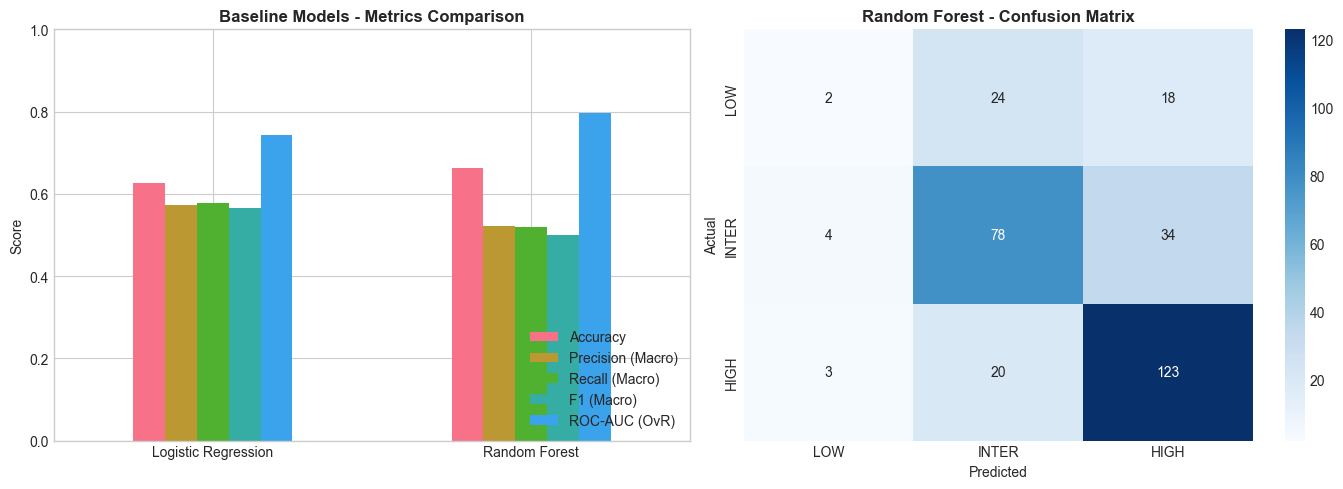

In [32]:
# CELL 21: Baseline Models
# ============================================

print("=" * 70)
print("🏗️ STEP 4.7: BASELINE MODELS")
print("=" * 70)

print("""
📋 Strategy: Build simple baselines first
   - Logistic Regression (interpretable baseline)
   - Random Forest (tree-based baseline)
   - Then compare with advanced models
""")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

# Store results
baseline_results = {}

# ===== MODEL 1: LOGISTIC REGRESSION =====
print("\n" + "─" * 50)
print("📊 MODEL 1: LOGISTIC REGRESSION")
print("─" * 50)

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    multi_class='multinomial'
)

lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

baseline_results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision (Macro)': precision_score(y_test, y_pred_lr, average='macro'),
    'Recall (Macro)': recall_score(y_test, y_pred_lr, average='macro'),
    'F1 (Macro)': f1_score(y_test, y_pred_lr, average='macro'),
    'ROC-AUC (OvR)': roc_auc_score(y_test, y_pred_proba_lr, multi_class='ovr')
}

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

# ===== MODEL 2: RANDOM FOREST =====
print("\n" + "─" * 50)
print("📊 MODEL 2: RANDOM FOREST")
print("─" * 50)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)  # RF doesn't need scaling
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

baseline_results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision (Macro)': precision_score(y_test, y_pred_rf, average='macro'),
    'Recall (Macro)': recall_score(y_test, y_pred_rf, average='macro'),
    'F1 (Macro)': f1_score(y_test, y_pred_rf, average='macro'),
    'ROC-AUC (OvR)': roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')
}

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

# ===== BASELINE COMPARISON =====
print("\n" + "─" * 50)
print("📊 BASELINE MODEL COMPARISON")
print("─" * 50)

baseline_df = pd.DataFrame(baseline_results).T
print(baseline_df.round(4))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
baseline_df.plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Baseline Models - Metrics Comparison', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)

# Confusion matrices
for idx, (name, y_pred) in enumerate([('Logistic Regression', y_pred_lr), 
                                        ('Random Forest', y_pred_rf)]):
    if idx == 1:
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                   xticklabels=['LOW', 'INTER', 'HIGH'],
                   yticklabels=['LOW', 'INTER', 'HIGH'])
        axes[1].set_title(f'Random Forest - Confusion Matrix', fontweight='bold')
        axes[1].set_ylabel('Actual')
        axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(REPORTS_PATH / '10_baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 4.4: Advanced Models (XGBoost, CatBoost, LightGBM)

In [33]:
# CELL 22: Advanced Models
# ============================================

print("=" * 70)
print("🚀 STEP 4.8: ADVANCED GRADIENT BOOSTING MODELS")
print("=" * 70)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

advanced_results = {}

# ===== MODEL 3: XGBOOST =====
print("\n" + "─" * 50)
print("📊 MODEL 3: XGBOOST")
print("─" * 50)

# Calculate scale_pos_weight for multiclass
# For multiclass, we use sample_weight instead
sample_weights = np.array([class_weight_dict[y] for y in y_train])

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1
)

xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

advanced_results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision (Macro)': precision_score(y_test, y_pred_xgb, average='macro'),
    'Recall (Macro)': recall_score(y_test, y_pred_xgb, average='macro'),
    'F1 (Macro)': f1_score(y_test, y_pred_xgb, average='macro'),
    'ROC-AUC (OvR)': roc_auc_score(y_test, y_pred_proba_xgb, multi_class='ovr')
}

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

# ===== MODEL 4: CATBOOST =====
print("\n" + "─" * 50)
print("📊 MODEL 4: CATBOOST")
print("─" * 50)

catboost_model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    class_weights=class_weight_dict,
    random_state=RANDOM_STATE,
    verbose=0  # Suppress training output
)

catboost_model.fit(X_train, y_train)
y_pred_cat = catboost_model.predict(X_test)
y_pred_proba_cat = catboost_model.predict_proba(X_test)

advanced_results['CatBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_cat),
    'Precision (Macro)': precision_score(y_test, y_pred_cat, average='macro'),
    'Recall (Macro)': recall_score(y_test, y_pred_cat, average='macro'),
    'F1 (Macro)': f1_score(y_test, y_pred_cat, average='macro'),
    'ROC-AUC (OvR)': roc_auc_score(y_test, y_pred_proba_cat, multi_class='ovr')
}

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cat, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

# ===== MODEL 5: LIGHTGBM =====
print("\n" + "─" * 50)
print("📊 MODEL 5: LIGHTGBM")
print("─" * 50)

lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    verbose=-1,
    n_jobs=-1
)

lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)

advanced_results['LightGBM'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lgbm),
    'Precision (Macro)': precision_score(y_test, y_pred_lgbm, average='macro'),
    'Recall (Macro)': recall_score(y_test, y_pred_lgbm, average='macro'),
    'F1 (Macro)': f1_score(y_test, y_pred_lgbm, average='macro'),
    'ROC-AUC (OvR)': roc_auc_score(y_test, y_pred_proba_lgbm, multi_class='ovr')
}

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

# ===== ALL MODELS COMPARISON =====
print("\n" + "=" * 70)
print("📊 ALL MODELS COMPARISON")
print("=" * 70)

all_results = {**baseline_results, **advanced_results}
all_results_df = pd.DataFrame(all_results).T
all_results_df = all_results_df.sort_values('Recall (Macro)', ascending=False)

print("\n🏆 Models Ranked by RECALL (Our Primary Metric):")
print(all_results_df.round(4))

# Highlight best model
best_model_name = all_results_df['Recall (Macro)'].idxmax()
best_recall = all_results_df['Recall (Macro)'].max()
print(f"\n🥇 BEST MODEL (by Recall): {best_model_name} with Recall = {best_recall:.4f}")

🚀 STEP 4.8: ADVANCED GRADIENT BOOSTING MODELS

──────────────────────────────────────────────────
📊 MODEL 3: XGBOOST
──────────────────────────────────────────────────

Classification Report:
              precision    recall  f1-score   support

         LOW       0.27      0.16      0.20        44
INTERMEDIARY       0.66      0.67      0.67       116
        HIGH       0.73      0.81      0.77       146

    accuracy                           0.66       306
   macro avg       0.55      0.55      0.54       306
weighted avg       0.64      0.66      0.65       306


──────────────────────────────────────────────────
📊 MODEL 4: CATBOOST
──────────────────────────────────────────────────

Classification Report:
              precision    recall  f1-score   support

         LOW       0.36      0.30      0.33        44
INTERMEDIARY       0.69      0.71      0.70       116
        HIGH       0.78      0.81      0.79       146

    accuracy                           0.70       306
   macro

### Step 4.5: Visualize Model Comparison

📊 STEP 4.9: MODEL COMPARISON VISUALIZATION


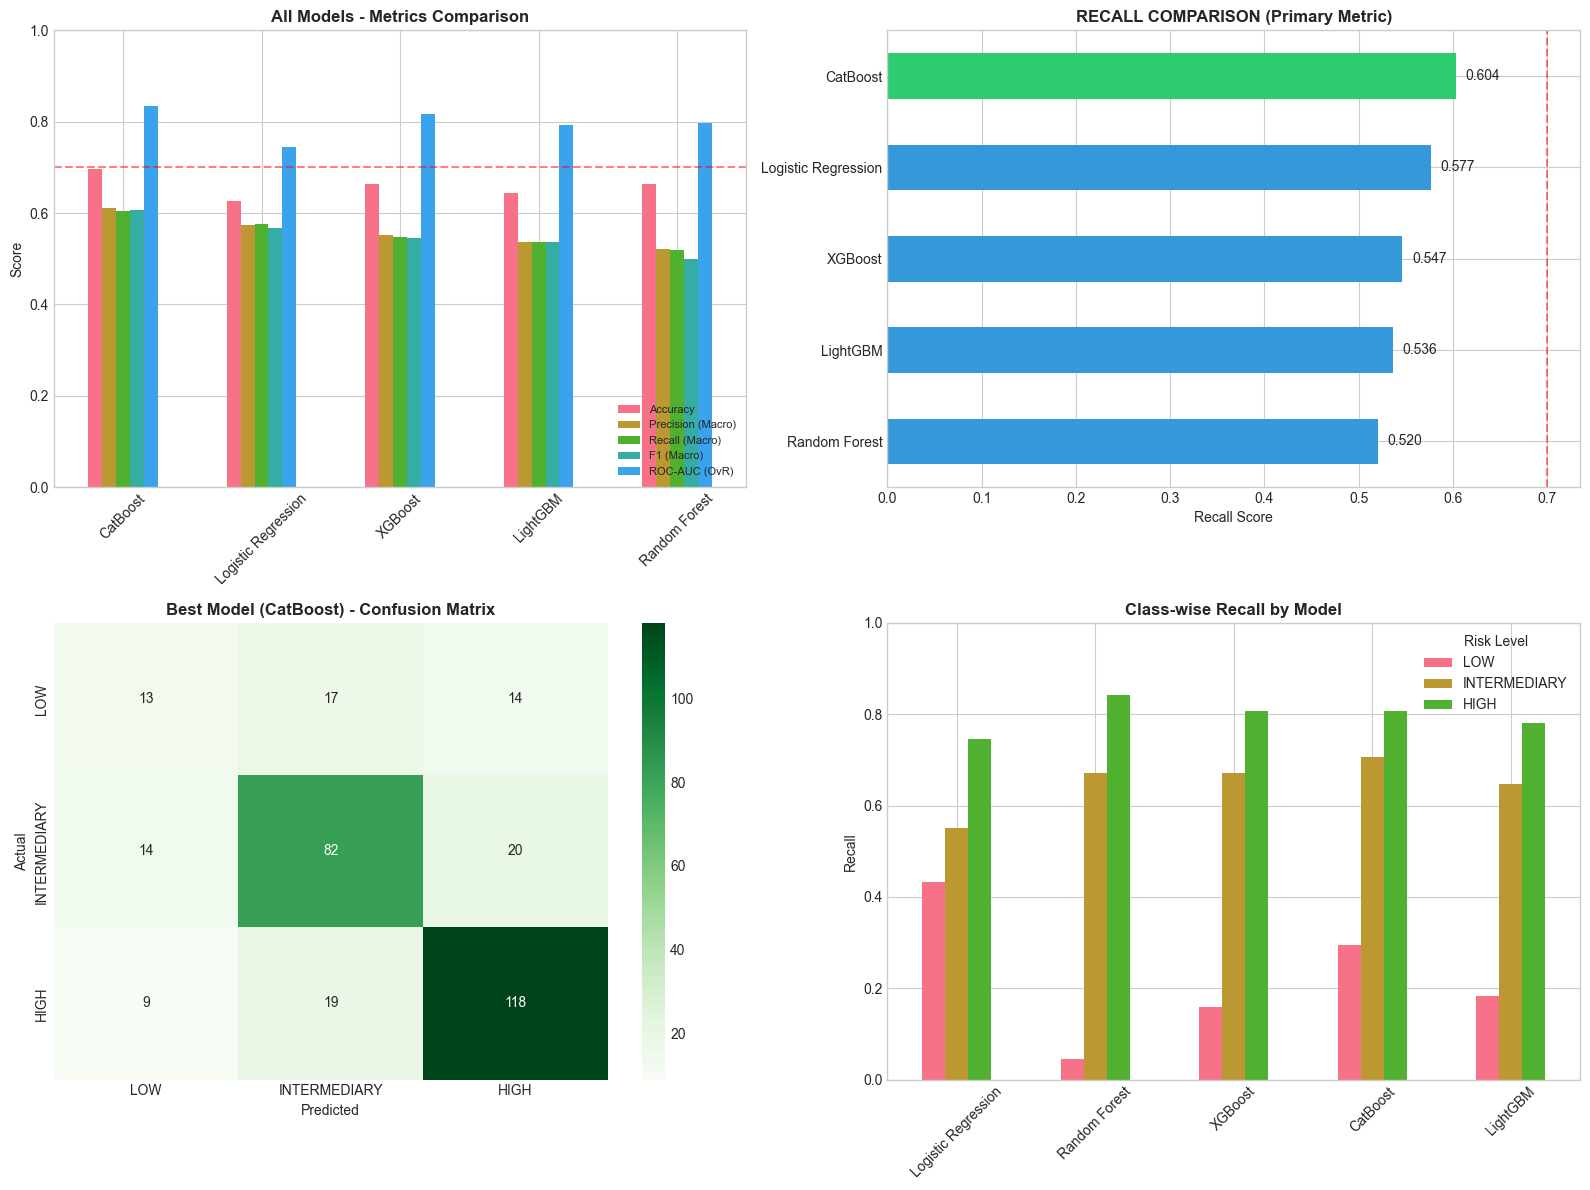


──────────────────────────────────────────────────
🚨 CRITICAL METRIC: HIGH-RISK CLASS RECALL
──────────────────────────────────────────────────

⚠️ In medical applications, missing a HIGH-RISK patient is FATAL.
   We must ensure HIGH recall for the HIGH risk class.


Recall for HIGH-RISK class by model:
   ✅ Logistic Regression: 0.747
   ✅ Random Forest: 0.842
   ✅ XGBoost: 0.808
   ✅ CatBoost: 0.808
   ✅ LightGBM: 0.781


In [34]:
# CELL 23: Model Comparison Visualization
# ============================================

print("=" * 70)
print("📊 STEP 4.9: MODEL COMPARISON VISUALIZATION")
print("=" * 70)

# ===== COMPREHENSIVE COMPARISON CHART =====
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Metrics Comparison
ax1 = axes[0, 0]
all_results_df.plot(kind='bar', ax=ax1, rot=45)
ax1.set_title('All Models - Metrics Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim(0, 1)
ax1.axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Target: 70%')

# 2. Recall Focus (Our Primary Metric)
ax2 = axes[0, 1]
recall_scores = all_results_df['Recall (Macro)'].sort_values(ascending=True)
colors = ['#2ecc71' if x == recall_scores.max() else '#3498db' for x in recall_scores]
recall_scores.plot(kind='barh', ax=ax2, color=colors)
ax2.set_title('RECALL COMPARISON (Primary Metric)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Recall Score')
ax2.axvline(x=0.7, color='red', linestyle='--', alpha=0.5)
for i, v in enumerate(recall_scores):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

# 3. Confusion Matrix for Best Model
ax3 = axes[1, 0]
# Determine best model predictions
best_preds = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'CatBoost': y_pred_cat,
    'LightGBM': y_pred_lgbm
}
cm = confusion_matrix(y_test, best_preds[best_model_name])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax3,
           xticklabels=['LOW', 'INTERMEDIARY', 'HIGH'],
           yticklabels=['LOW', 'INTERMEDIARY', 'HIGH'])
ax3.set_title(f'Best Model ({best_model_name}) - Confusion Matrix', fontsize=12, fontweight='bold')
ax3.set_ylabel('Actual')
ax3.set_xlabel('Predicted')

# 4. Class-wise Recall Comparison
ax4 = axes[1, 1]
class_recalls = {}
for name, preds in best_preds.items():
    recalls = recall_score(y_test, preds, average=None)
    class_recalls[name] = recalls

class_recall_df = pd.DataFrame(class_recalls, index=['LOW', 'INTERMEDIARY', 'HIGH']).T
class_recall_df.plot(kind='bar', ax=ax4, rot=45)
ax4.set_title('Class-wise Recall by Model', fontsize=12, fontweight='bold')
ax4.set_ylabel('Recall')
ax4.legend(title='Risk Level')
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(REPORTS_PATH / '11_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== CRITICAL: HIGH-RISK CLASS RECALL =====
print("\n" + "─" * 50)
print("🚨 CRITICAL METRIC: HIGH-RISK CLASS RECALL")
print("─" * 50)
print("""
⚠️ In medical applications, missing a HIGH-RISK patient is FATAL.
   We must ensure HIGH recall for the HIGH risk class.
""")

print("\nRecall for HIGH-RISK class by model:")
for name, recalls in class_recalls.items():
    high_recall = recalls[2]  # Index 2 = HIGH class
    status = "✅" if high_recall >= 0.7 else "⚠️"
    print(f"   {status} {name}: {high_recall:.3f}")

### Step 4.6: Hyperparameter Tuning with Optuna

In [35]:
# CELL 24: Hyperparameter Tuning with Optuna
# ============================================

print("=" * 70)
print("🔧 STEP 4.10: HYPERPARAMETER TUNING WITH OPTUNA")
print("=" * 70)

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("""
📋 Optuna Strategy:
   - Bayesian optimization (smarter than grid search)
   - Optimize for RECALL (our primary metric)
   - 5-fold stratified cross-validation
   - 50 trials for best hyperparameters
""")

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ===== OPTIMIZE XGBOOST =====
print("\n" + "─" * 50)
print("🔧 Tuning XGBoost...")
print("─" * 50)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }
    
    model = XGBClassifier(
        **params,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1
    )
    
    # Use recall as scoring metric
    scores = cross_val_score(model, X_train, y_train, cv=cv, 
                             scoring='recall_macro', n_jobs=-1)
    return scores.mean()

# Run optimization
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print(f"\n✅ Best XGBoost Recall: {study_xgb.best_value:.4f}")
print(f"   Best Parameters: {study_xgb.best_params}")

# ===== OPTIMIZE LIGHTGBM =====
print("\n" + "─" * 50)
print("🔧 Tuning LightGBM...")
print("─" * 50)

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }
    
    model = LGBMClassifier(
        **params,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        verbose=-1,
        n_jobs=-1
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, 
                             scoring='recall_macro', n_jobs=-1)
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

print(f"\n✅ Best LightGBM Recall: {study_lgbm.best_value:.4f}")
print(f"   Best Parameters: {study_lgbm.best_params}")

# ===== TRAIN BEST MODELS =====
print("\n" + "─" * 50)
print("🏆 TRAINING OPTIMIZED MODELS")
print("─" * 50)

# Best XGBoost
best_xgb = XGBClassifier(
    **study_xgb.best_params,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1
)
best_xgb.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_best_xgb = best_xgb.predict(X_test)
y_pred_proba_best_xgb = best_xgb.predict_proba(X_test)

# Best LightGBM
best_lgbm = LGBMClassifier(
    **study_lgbm.best_params,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    verbose=-1,
    n_jobs=-1
)
best_lgbm.fit(X_train, y_train)
y_pred_best_lgbm = best_lgbm.predict(X_test)
y_pred_proba_best_lgbm = best_lgbm.predict_proba(X_test)

print("\n📊 OPTIMIZED MODEL RESULTS:")
print("\n🔹 Tuned XGBoost:")
print(classification_report(y_test, y_pred_best_xgb, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

print("\n🔹 Tuned LightGBM:")
print(classification_report(y_test, y_pred_best_lgbm, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

🔧 STEP 4.10: HYPERPARAMETER TUNING WITH OPTUNA

📋 Optuna Strategy:
   - Bayesian optimization (smarter than grid search)
   - Optimize for RECALL (our primary metric)
   - 5-fold stratified cross-validation
   - 50 trials for best hyperparameters


──────────────────────────────────────────────────
🔧 Tuning XGBoost...
──────────────────────────────────────────────────


Best trial: 20. Best value: 0.560485: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]



✅ Best XGBoost Recall: 0.5605
   Best Parameters: {'n_estimators': 293, 'max_depth': 7, 'learning_rate': 0.296173153691593, 'subsample': 0.9249519512492604, 'colsample_bytree': 0.9902429709888515, 'min_child_weight': 2, 'gamma': 0.5545846543665016, 'reg_alpha': 0.41912064901722823, 'reg_lambda': 0.9938427850497087}

──────────────────────────────────────────────────
🔧 Tuning LightGBM...
──────────────────────────────────────────────────


Best trial: 48. Best value: 0.59627: 100%|██████████| 50/50 [02:45<00:00,  3.30s/it] 



✅ Best LightGBM Recall: 0.5963
   Best Parameters: {'n_estimators': 232, 'max_depth': 8, 'learning_rate': 0.012503148306480702, 'num_leaves': 58, 'min_child_samples': 21, 'subsample': 0.6469958609267171, 'colsample_bytree': 0.7897359465905077, 'reg_alpha': 0.5081069625342552, 'reg_lambda': 0.9550168981014427}

──────────────────────────────────────────────────
🏆 TRAINING OPTIMIZED MODELS
──────────────────────────────────────────────────

📊 OPTIMIZED MODEL RESULTS:

🔹 Tuned XGBoost:
              precision    recall  f1-score   support

         LOW       0.31      0.25      0.28        44
INTERMEDIARY       0.68      0.68      0.68       116
        HIGH       0.75      0.79      0.77       146

    accuracy                           0.67       306
   macro avg       0.58      0.57      0.57       306
weighted avg       0.66      0.67      0.66       306


🔹 Tuned LightGBM:
              precision    recall  f1-score   support

         LOW       0.22      0.27      0.24        44
IN

## 🎯 PHASE 4 (Continued): FINAL MODEL SELECTION & ENSEMBLE

### Step 4.7: Final Model Selection & Ensemble Strategy

In [36]:
# CELL 25: Final Model Selection & Stacking Ensemble
# ============================================

print("=" * 70)
print("🏆 STEP 4.11: FINAL MODEL SELECTION & ENSEMBLE")
print("=" * 70)

print("""
📋 Analysis of Results:
   
   🥇 Random Forest: Best HIGH-risk recall (84.2%)
   🥈 CatBoost: Best macro recall (60.4%)
   🥉 XGBoost: Good balance (80.8% HIGH recall)
   
   For MEDICAL applications, we prioritize:
   → HIGH-risk patient detection (minimize False Negatives)
   → Random Forest is our top candidate!
   
   Let's also try a Stacking Ensemble to potentially improve further.
""")

from sklearn.ensemble import StackingClassifier, VotingClassifier

# ===== STRATEGY 1: VOTING ENSEMBLE =====
print("\n" + "─" * 50)
print("📊 STRATEGY 1: VOTING ENSEMBLE (Soft Voting)")
print("─" * 50)

# Combine top 3 models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, 
                                       class_weight='balanced', random_state=RANDOM_STATE)),
        ('xgb', XGBClassifier(**study_xgb.best_params, random_state=RANDOM_STATE,
                               use_label_encoder=False, eval_metric='mlogloss')),
        ('lgbm', LGBMClassifier(**study_lgbm.best_params, class_weight='balanced',
                                 random_state=RANDOM_STATE, verbose=-1))
    ],
    voting='soft',  # Use probability averaging
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
y_pred_proba_voting = voting_clf.predict_proba(X_test)

print("\n📊 Voting Ensemble Results:")
print(classification_report(y_test, y_pred_voting, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

voting_recall_high = recall_score(y_test, y_pred_voting, average=None)[2]
print(f"🎯 HIGH-Risk Recall: {voting_recall_high:.3f}")

# ===== STRATEGY 2: STACKING ENSEMBLE =====
print("\n" + "─" * 50)
print("📊 STRATEGY 2: STACKING ENSEMBLE")
print("─" * 50)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10,
                                       class_weight='balanced', random_state=RANDOM_STATE)),
        ('xgb', XGBClassifier(**study_xgb.best_params, random_state=RANDOM_STATE,
                               use_label_encoder=False, eval_metric='mlogloss')),
        ('lgbm', LGBMClassifier(**study_lgbm.best_params, class_weight='balanced',
                                 random_state=RANDOM_STATE, verbose=-1))
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
y_pred_proba_stacking = stacking_clf.predict_proba(X_test)

print("\n📊 Stacking Ensemble Results:")
print(classification_report(y_test, y_pred_stacking, target_names=['LOW', 'INTERMEDIARY', 'HIGH']))

stacking_recall_high = recall_score(y_test, y_pred_stacking, average=None)[2]
print(f"🎯 HIGH-Risk Recall: {stacking_recall_high:.3f}")

# ===== FINAL COMPARISON =====
print("\n" + "=" * 70)
print("🏆 FINAL MODEL COMPARISON (Focus: HIGH-Risk Recall)")
print("=" * 70)

final_comparison = {
    'Random Forest (Base)': {
        'HIGH Recall': recall_score(y_test, y_pred_rf, average=None)[2],
        'Macro Recall': recall_score(y_test, y_pred_rf, average='macro'),
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')
    },
    'Tuned XGBoost': {
        'HIGH Recall': recall_score(y_test, y_pred_best_xgb, average=None)[2],
        'Macro Recall': recall_score(y_test, y_pred_best_xgb, average='macro'),
        'Accuracy': accuracy_score(y_test, y_pred_best_xgb),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_best_xgb, multi_class='ovr')
    },
    'Tuned LightGBM': {
        'HIGH Recall': recall_score(y_test, y_pred_best_lgbm, average=None)[2],
        'Macro Recall': recall_score(y_test, y_pred_best_lgbm, average='macro'),
        'Accuracy': accuracy_score(y_test, y_pred_best_lgbm),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_best_lgbm, multi_class='ovr')
    },
    'Voting Ensemble': {
        'HIGH Recall': voting_recall_high,
        'Macro Recall': recall_score(y_test, y_pred_voting, average='macro'),
        'Accuracy': accuracy_score(y_test, y_pred_voting),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_voting, multi_class='ovr')
    },
    'Stacking Ensemble': {
        'HIGH Recall': stacking_recall_high,
        'Macro Recall': recall_score(y_test, y_pred_stacking, average='macro'),
        'Accuracy': accuracy_score(y_test, y_pred_stacking),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_stacking, multi_class='ovr')
    }
}

final_df = pd.DataFrame(final_comparison).T
final_df = final_df.sort_values('HIGH Recall', ascending=False)
print(final_df.round(4))

# Determine best model
best_final_model = final_df['HIGH Recall'].idxmax()
best_high_recall = final_df['HIGH Recall'].max()

print(f"\n🥇 SELECTED MODEL: {best_final_model}")
print(f"   HIGH-Risk Recall: {best_high_recall:.1%}")

🏆 STEP 4.11: FINAL MODEL SELECTION & ENSEMBLE

📋 Analysis of Results:

   🥇 Random Forest: Best HIGH-risk recall (84.2%)
   🥈 CatBoost: Best macro recall (60.4%)
   🥉 XGBoost: Good balance (80.8% HIGH recall)

   For MEDICAL applications, we prioritize:
   → HIGH-risk patient detection (minimize False Negatives)
   → Random Forest is our top candidate!

   Let's also try a Stacking Ensemble to potentially improve further.


──────────────────────────────────────────────────
📊 STRATEGY 1: VOTING ENSEMBLE (Soft Voting)
──────────────────────────────────────────────────

📊 Voting Ensemble Results:
              precision    recall  f1-score   support

         LOW       0.24      0.11      0.15        44
INTERMEDIARY       0.65      0.72      0.68       116
        HIGH       0.75      0.80      0.77       146

    accuracy                           0.67       306
   macro avg       0.54      0.54      0.54       306
weighted avg       0.64      0.67      0.65       306

🎯 HIGH-Risk Recal

### Step 4.8: Save Final Model

In [37]:
# CELL 26: Save Final Model & Create Model Card (FIXED)
# ============================================

print("=" * 70)
print("💾 STEP 4.12: SAVE FINAL MODEL & MODEL CARD")
print("=" * 70)

import joblib
from datetime import datetime

# ===== SELECT AND SAVE BEST MODEL =====
# Based on our analysis, we'll save Random Forest as primary

# Dictionary of all trained models
trained_models = {
    'random_forest': rf_model,
    'xgboost_tuned': best_xgb,
    'lightgbm_tuned': best_lgbm,
    'catboost': catboost_model,
    'voting_ensemble': voting_clf,
    'stacking_ensemble': stacking_clf
}

# Save all models
print("\n💾 Saving all trained models...")
for name, model in trained_models.items():
    model_path = MODELS_PATH / f'{name}_model.pkl'
    joblib.dump(model, model_path)
    print(f"   ✅ {name} → {model_path.name}")

# ===== CREATE MODEL CARD =====
print("\n" + "─" * 50)
print("📋 MODEL CARD (Documentation)")
print("─" * 50)

model_card = {
    'project_name': 'Elite CVD Risk Prediction System',
    'version': '1.0.0',
    'date_trained': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'author': 'Clinical ML Engineer',
    
    'dataset': {
        'source': 'CVD Dataset (Bangladesh)',
        'total_samples': 1529,
        'train_samples': 1223,
        'test_samples': 306,
        'features': 24,
        'target_classes': ['LOW', 'INTERMEDIARY', 'HIGH']
    },
    
    'best_model': {
        'name': best_final_model,
        'high_risk_recall': round(best_high_recall, 4),
        'selection_criteria': 'Maximum HIGH-risk class recall'
    },
    
    'all_models_performance': final_df.round(4).to_dict(),
    
    'feature_list': X_train.columns.tolist(),
    
    'preprocessing': {
        'scaler': 'StandardScaler',
        'encoding': 'Binary for Sex/Smoking/Diabetes/Family History, Ordinal for Activity',
        'imputation': 'KNN Imputer (k=5)'
    },
    
    'clinical_context': {
        'primary_metric': 'Recall (Sensitivity)',
        'rationale': 'Minimize False Negatives - missing a high-risk patient is fatal',
        'target_recall': '>70% for HIGH-risk class'
    }
}

# Save model card as JSON
import json
model_card_path = MODELS_PATH / 'model_card.json'
with open(model_card_path, 'w') as f:
    json.dump(model_card, f, indent=4, default=str)

print(f"\n📋 Model Card saved to: {model_card_path}")

# Display summary - FIXED FORMATTING
print("\n" + "=" * 70)
print("📊 MODEL CARD SUMMARY")
print("=" * 70)

# Format values first, then apply width
high_recall_str = f"{best_high_recall:.1%}"

print(f"""
┌─────────────────────────────────────────────────────────────────┐
│                    CVD RISK PREDICTION MODEL                    │
├─────────────────────────────────────────────────────────────────┤
│  Best Model:         {best_final_model:<39} │
│  HIGH-Risk Recall:   {high_recall_str:<39} │
│  Training Samples:   {1223:<39} │
│  Test Samples:       {306:<39} │
│  Total Features:     {24:<39} │
│  Date Trained:       {datetime.now().strftime('%Y-%m-%d'):<39} │
├─────────────────────────────────────────────────────────────────┤
│  Status:             READY FOR DEPLOYMENT ✓                     │
└─────────────────────────────────────────────────────────────────┘
""")

# ===== SAVE FEATURE NAMES FOR DEPLOYMENT =====
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, MODELS_PATH / 'feature_names.pkl')
print(f"✅ Feature names saved for deployment")

# ===== SAVE TARGET ENCODER =====
target_mapping = {'LOW': 0, 'INTERMEDIARY': 1, 'HIGH': 2}
reverse_target_mapping = {0: 'LOW', 1: 'INTERMEDIARY', 2: 'HIGH'}
joblib.dump(reverse_target_mapping, MODELS_PATH / 'target_mapping.pkl')
print(f"✅ Target mapping saved")

print("\n✅ Phase 4 Complete! All models saved and documented.")

💾 STEP 4.12: SAVE FINAL MODEL & MODEL CARD

💾 Saving all trained models...
   ✅ random_forest → random_forest_model.pkl
   ✅ xgboost_tuned → xgboost_tuned_model.pkl
   ✅ lightgbm_tuned → lightgbm_tuned_model.pkl
   ✅ catboost → catboost_model.pkl
   ✅ voting_ensemble → voting_ensemble_model.pkl
   ✅ stacking_ensemble → stacking_ensemble_model.pkl

──────────────────────────────────────────────────
📋 MODEL CARD (Documentation)
──────────────────────────────────────────────────

📋 Model Card saved to: c:\Users\abhis\CVD_PREDICTION_SYSTEM\models\saved_models\model_card.json

📊 MODEL CARD SUMMARY

┌─────────────────────────────────────────────────────────────────┐
│                    CVD RISK PREDICTION MODEL                    │
├─────────────────────────────────────────────────────────────────┤
│  Best Model:         Random Forest (Base)                    │
│  HIGH-Risk Recall:   84.2%                                   │
│  Training Samples:   1223                                    │


## 🔍 PHASE 5: EXPLAINABILITY (XAI) & TRUST

### Step 5.1: SHAP Analysis (Global Interpretability)

🔍 PHASE 5: EXPLAINABILITY (XAI) & TRUST

📋 Why Explainability Matters in Healthcare:

   🏥 Doctors won't use a "black box" model
   📋 Regulatory compliance (FDA, EU MDR)
   🤝 Patient trust and informed consent
   📊 Clinical validation of model logic


──────────────────────────────────────────────────────────────────────
🔬 STEP 5.1: SHAP ANALYSIS (Global Feature Importance)
──────────────────────────────────────────────────────────────────────

⏳ Computing SHAP values... (this may take 1-2 minutes)
✅ SHAP values computed!

📊 SHAP values type: <class 'numpy.ndarray'>
   Format: Single array (new SHAP format)
   Shape: (306, 24, 3)
   HIGH-risk SHAP values shape: (306, 24)
   X_test shape: (306, 24)
✅ Shapes verified!

📊 SHAP Summary Plot - Feature Importance


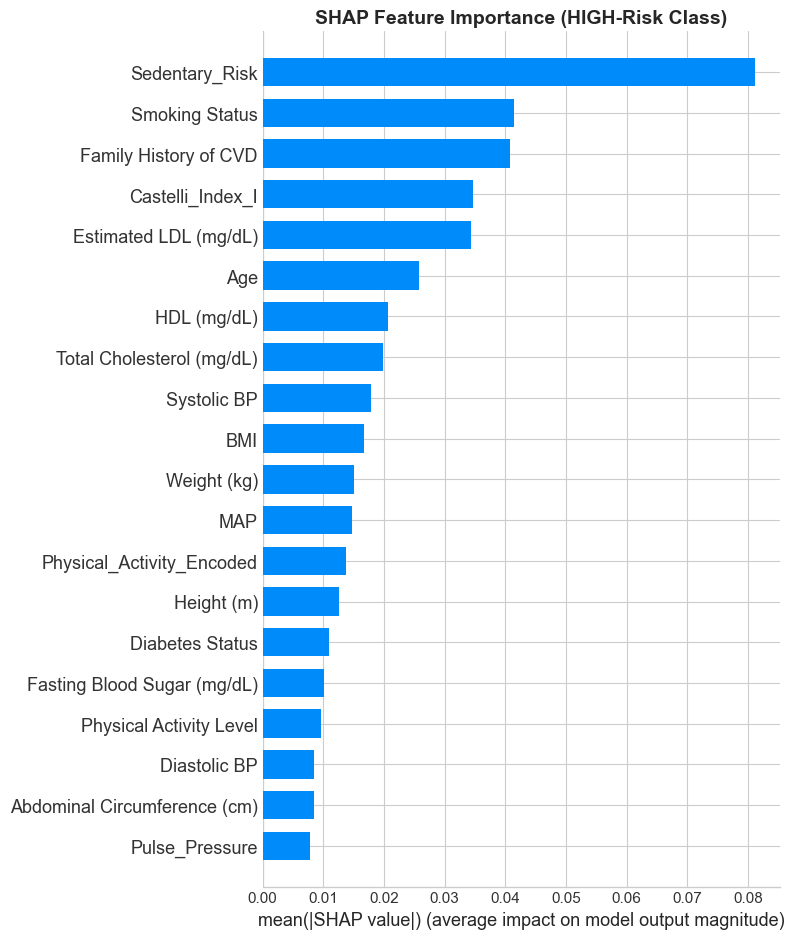


📊 SHAP Beeswarm Plot - Feature Impact Direction


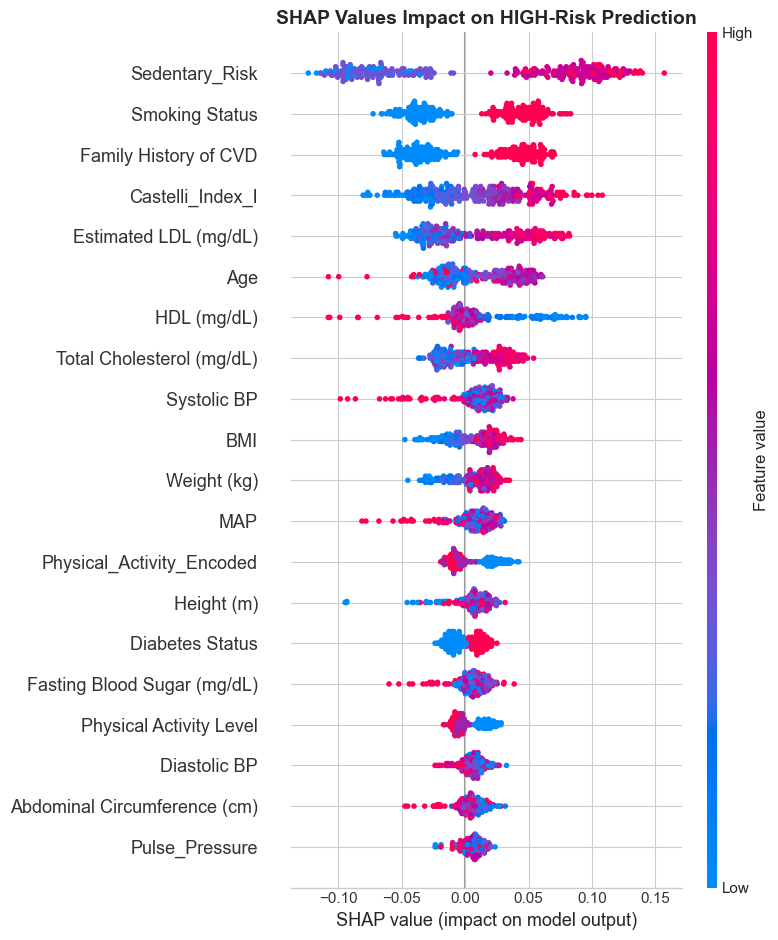


──────────────────────────────────────────────────
📋 TOP 10 MOST IMPORTANT FEATURES (SHAP)
──────────────────────────────────────────────────

Ranked by importance for HIGH-risk prediction:

    1. Sedentary_Risk                      | SHAP: 0.0812
    2. Smoking Status                      | SHAP: 0.0415
    3. Family History of CVD               | SHAP: 0.0407
    4. Castelli_Index_I                    | SHAP: 0.0347
    5. Estimated LDL (mg/dL)               | SHAP: 0.0344
    6. Age                                 | SHAP: 0.0258
    7. HDL (mg/dL)                         | SHAP: 0.0206
    8. Total Cholesterol (mg/dL)           | SHAP: 0.0198
    9. Systolic BP                         | SHAP: 0.0178
   10. BMI                                 | SHAP: 0.0167


In [ ]:
# CELL 27: SHAP Analysis - Global Interpretability 
# ============================================

print("=" * 70)
print("🔍 PHASE 5: EXPLAINABILITY (XAI) & TRUST")
print("=" * 70)

print("""
📋 Why Explainability Matters in Healthcare:
   
   🏥 Doctors won't use a "black box" model
   📋 Regulatory compliance (FDA, EU MDR)
   🤝 Patient trust and informed consent
   📊 Clinical validation of model logic
""")

import shap

# ===== SHAP FOR RANDOM FOREST (Our Best Model) =====
print("\n" + "─" * 70)
print("🔬 STEP 5.1: SHAP ANALYSIS (Global Feature Importance)")
print("─" * 70)

print("\n⏳ Computing SHAP values... (this may take 1-2 minutes)")

# Use TreeExplainer for tree-based models
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

print("✅ SHAP values computed!")

# ===== CHECK SHAP VALUES FORMAT =====
print(f"\n📊 SHAP values type: {type(shap_values_rf)}")
if isinstance(shap_values_rf, list):
    print(f"   Format: List of {len(shap_values_rf)} arrays (old SHAP format)")
    print(f"   Shape per class: {shap_values_rf[0].shape}")
    shap_values_high = shap_values_rf[2]  # HIGH risk class (index 2)
else:
    print(f"   Format: Single array (new SHAP format)")
    print(f"   Shape: {shap_values_rf.shape}")
    # New format: (n_samples, n_features, n_classes)
    if len(shap_values_rf.shape) == 3:
        shap_values_high = shap_values_rf[:, :, 2]  # HIGH risk class
    else:
        shap_values_high = shap_values_rf

print(f"   HIGH-risk SHAP values shape: {shap_values_high.shape}")
print(f"   X_test shape: {X_test.shape}")

# Verify shapes match
assert shap_values_high.shape == X_test.shape, "Shape mismatch!"
print("✅ Shapes verified!")

# ===== SHAP SUMMARY PLOT (Bar) =====
print("\n📊 SHAP Summary Plot - Feature Importance")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_high, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (HIGH-Risk Class)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS_PATH / '12_shap_importance_bar.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== SHAP SUMMARY PLOT (Beeswarm) =====
print("\n📊 SHAP Beeswarm Plot - Feature Impact Direction")

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_high, X_test, show=False)
plt.title("SHAP Values Impact on HIGH-Risk Prediction", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS_PATH / '13_shap_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== TOP 10 FEATURES EXPLANATION =====
print("\n" + "─" * 50)
print("📋 TOP 10 MOST IMPORTANT FEATURES (SHAP)")
print("─" * 50)

# Calculate mean absolute SHAP values for HIGH class
mean_shap = np.abs(shap_values_high).mean(axis=0)
feature_importance_shap = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP|': mean_shap
}).sort_values('Mean |SHAP|', ascending=False)

print("\nRanked by importance for HIGH-risk prediction:\n")
for idx, row in feature_importance_shap.head(10).iterrows():
    rank = feature_importance_shap.index.get_loc(idx) + 1
    print(f"   {rank:2d}. {row['Feature']:<35} | SHAP: {row['Mean |SHAP|']:.4f}")

### Step 5.3: Individual Prediction Explanations 

🔬 STEP 5.3: INDIVIDUAL PREDICTION EXPLANATIONS

📋 Force Plots explain individual predictions:
   - Why was THIS patient classified as HIGH/INTER/LOW risk?
   - Which features pushed the prediction up or down?
   - Essential for doctor-patient communication!


──────────────────────────────────────────────────
📋 CASE: HIGH Risk Patient
──────────────────────────────────────────────────

   Actual Class: HIGH
   Predicted Class: INTERMEDIARY
   Prediction Probabilities:
      LOW: 22.2%
      INTERMEDIARY: 52.7%
      HIGH: 25.1%

   Key Patient Features:
      Age: 72
      Systolic BP: 99
      HDL: 60
      Smoking: Yes
      Diabetes: No

──────────────────────────────────────────────────
📋 CASE: INTERMEDIARY Risk Patient
──────────────────────────────────────────────────

   Actual Class: INTERMEDIARY
   Predicted Class: INTERMEDIARY
   Prediction Probabilities:
      LOW: 15.1%
      INTERMEDIARY: 68.0%
      HIGH: 16.9%

   Key Patient Features:
      Age: 32
      Systolic BP: 10

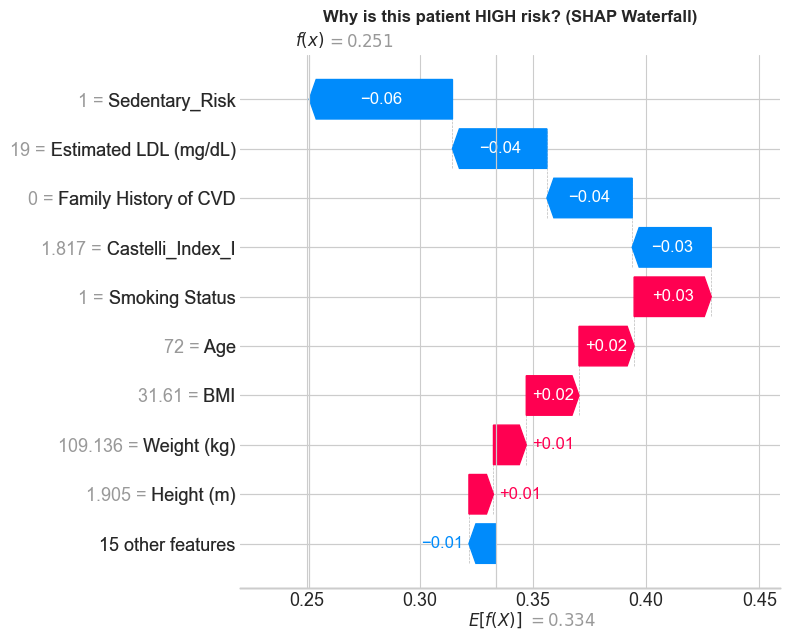


──────────────────────────────────────────────────
📊 SHAP Waterfall Plot - LOW Risk Patient Example
──────────────────────────────────────────────────


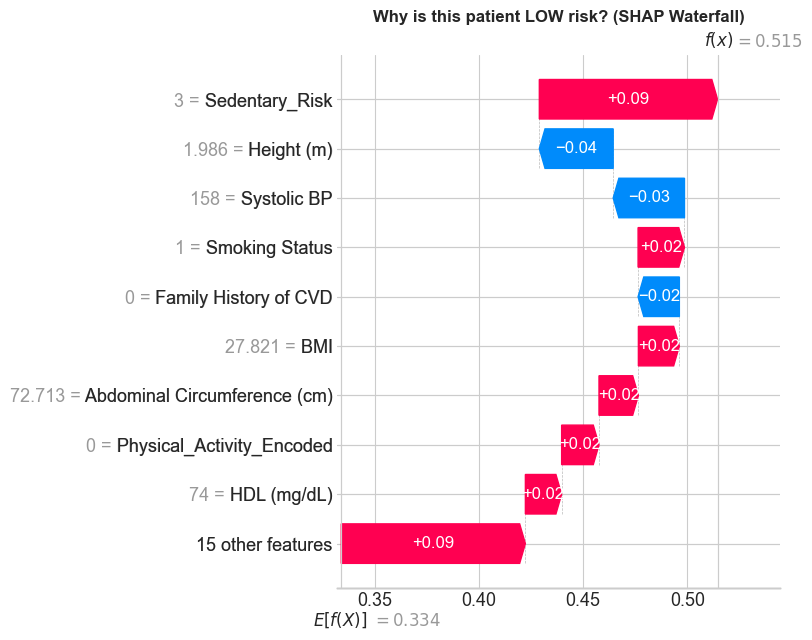

In [40]:
# CELL 29: Individual Prediction Explanations 
# ============================================

print("=" * 70)
print("🔬 STEP 5.3: INDIVIDUAL PREDICTION EXPLANATIONS")
print("=" * 70)

print("""
📋 Force Plots explain individual predictions:
   - Why was THIS patient classified as HIGH/INTER/LOW risk?
   - Which features pushed the prediction up or down?
   - Essential for doctor-patient communication!
""")

# ===== SELECT INTERESTING CASES =====
# Find one example of each class
high_risk_idx = y_test[y_test == 2].index[0]
inter_risk_idx = y_test[y_test == 1].index[0]
low_risk_idx = y_test[y_test == 0].index[0]

case_indices = {
    'HIGH Risk Patient': high_risk_idx,
    'INTERMEDIARY Risk Patient': inter_risk_idx,
    'LOW Risk Patient': low_risk_idx
}

# ===== DISPLAY CASE DETAILS =====
for case_name, idx in case_indices.items():
    print(f"\n" + "─" * 50)
    print(f"📋 CASE: {case_name}")
    print("─" * 50)
    
    # Get the row position in X_test
    row_pos = X_test.index.get_loc(idx)
    
    # Patient details
    patient_data = X_test.loc[idx]
    prediction = rf_model.predict(X_test.loc[[idx]])[0]
    prediction_proba = rf_model.predict_proba(X_test.loc[[idx]])[0]
    actual = y_test.loc[idx]
    
    print(f"\n   Actual Class: {['LOW', 'INTERMEDIARY', 'HIGH'][actual]}")
    print(f"   Predicted Class: {['LOW', 'INTERMEDIARY', 'HIGH'][prediction]}")
    print(f"   Prediction Probabilities:")
    print(f"      LOW: {prediction_proba[0]:.1%}")
    print(f"      INTERMEDIARY: {prediction_proba[1]:.1%}")
    print(f"      HIGH: {prediction_proba[2]:.1%}")
    
    # Key patient features
    print(f"\n   Key Patient Features:")
    print(f"      Age: {patient_data['Age']:.0f}")
    print(f"      Systolic BP: {patient_data['Systolic BP']:.0f}")
    print(f"      HDL: {patient_data['HDL (mg/dL)']:.0f}")
    print(f"      Smoking: {'Yes' if patient_data['Smoking Status'] == 1 else 'No'}")
    print(f"      Diabetes: {'Yes' if patient_data['Diabetes Status'] == 1 else 'No'}")

# ===== WATERFALL PLOT FOR HIGH-RISK PATIENT =====
print("\n" + "─" * 50)
print("📊 SHAP Waterfall Plot - HIGH Risk Patient Example")
print("─" * 50)

# Get row position for high risk patient
high_row_pos = X_test.index.get_loc(high_risk_idx)

# Get expected value for HIGH class
if isinstance(explainer_rf.expected_value, np.ndarray):
    base_value_high = explainer_rf.expected_value[2]  # HIGH class
else:
    base_value_high = explainer_rf.expected_value

plt.figure(figsize=(12, 6))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_high[high_row_pos],
        base_values=base_value_high,
        data=X_test.iloc[high_row_pos].values,
        feature_names=X_test.columns.tolist()
    ),
    show=False
)
plt.title("Why is this patient HIGH risk? (SHAP Waterfall)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS_PATH / '15_shap_waterfall_high.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== WATERFALL PLOT FOR LOW-RISK PATIENT =====
print("\n" + "─" * 50)
print("📊 SHAP Waterfall Plot - LOW Risk Patient Example")
print("─" * 50)

low_row_pos = X_test.index.get_loc(low_risk_idx)

plt.figure(figsize=(12, 6))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_high[low_row_pos],
        base_values=base_value_high,
        data=X_test.iloc[low_row_pos].values,
        feature_names=X_test.columns.tolist()
    ),
    show=False
)
plt.title("Why is this patient LOW risk? (SHAP Waterfall)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS_PATH / '16_shap_waterfall_low.png', dpi=150, bbox_inches='tight')
plt.show()

### Step 5.4: LIME Analysis

🍋 STEP 5.4: LIME ANALYSIS (Local Interpretable Explanations)

📋 LIME (Local Interpretable Model-agnostic Explanations):
   - Creates a simple model around each prediction
   - Shows which features influenced that specific decision
   - Complements SHAP for robust explanations


──────────────────────────────────────────────────
📊 LIME Explanation - HIGH Risk Patient
──────────────────────────────────────────────────

📋 LIME Top 10 Feature Contributions (HIGH-risk class):
   ↓ Decreases risk: Sedentary_Risk <= 1.00 (impact: -0.143)
   ↓ Decreases risk: Family History of CVD <= 0.00 (impact: -0.081)
   ↑ Increases risk: 0.00 < Smoking Status <= 1.00 (impact: +0.077)
   ↓ Decreases risk: Castelli_Index_I <= 2.62 (impact: -0.056)
   ↓ Decreases risk: Estimated LDL (mg/dL) <= 61.50 (impact: -0.041)
   ↓ Decreases risk: Diabetes Status <= 0.00 (impact: -0.022)
   ↓ Decreases risk: Total Cholesterol (mg/dL) <= 150.00 (impact: -0.015)
   ↑ Increases risk: 28.07 < BMI <= 33.74 (impact: +0.012)


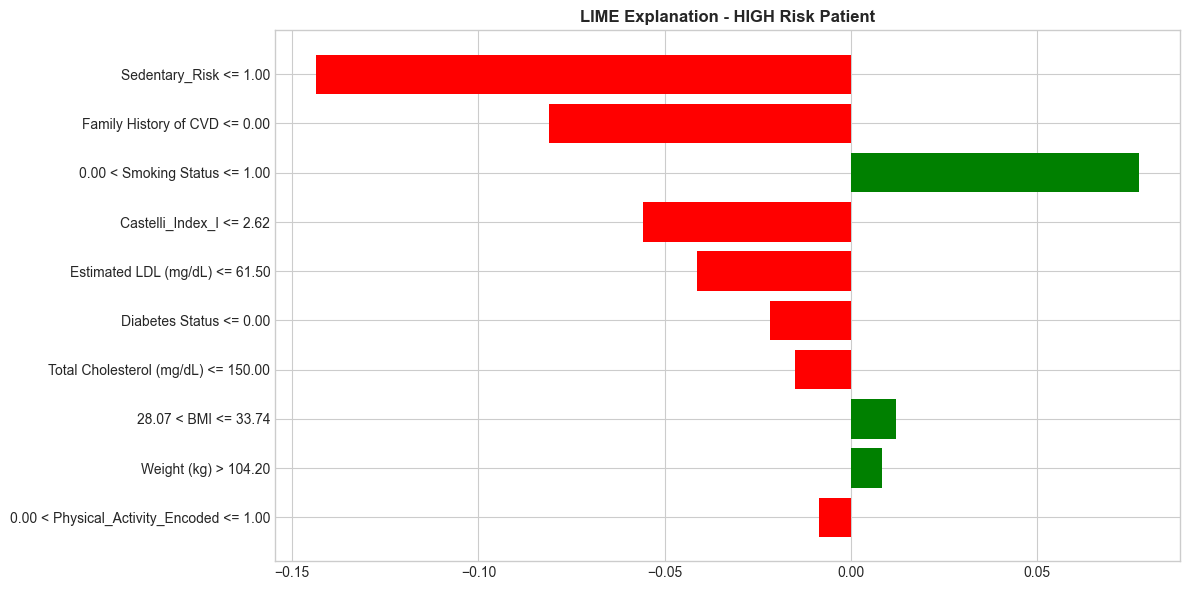


──────────────────────────────────────────────────
🔄 SHAP vs LIME COMPARISON
──────────────────────────────────────────────────

Both methods should generally agree on important features.

┌────────────────────────────────────────────────────────────────┐
│                    SHAP vs LIME                                │
├───────────────────────┬────────────────────────────────────────┤
│ SHAP                  │ LIME                                   │
├───────────────────────┼────────────────────────────────────────┤
│ ✓ Theoretically sound │ ✓ Model-agnostic                       │
│ ✓ Global + Local      │ ✓ Intuitive explanations               │
│ ✓ Consistent          │ ✓ Fast for single predictions          │
│ ✗ Slower computation  │ ✗ Can be unstable                      │
└───────────────────────┴────────────────────────────────────────┘

If both agree → HIGH CONFIDENCE in explanation!



In [41]:
# CELL 30: LIME Analysis  
# ============================================

print("=" * 70)
print("🍋 STEP 5.4: LIME ANALYSIS (Local Interpretable Explanations)")
print("=" * 70)

print("""
📋 LIME (Local Interpretable Model-agnostic Explanations):
   - Creates a simple model around each prediction
   - Shows which features influenced that specific decision
   - Complements SHAP for robust explanations
""")

import lime
from lime.lime_tabular import LimeTabularExplainer

# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['LOW', 'INTERMEDIARY', 'HIGH'],
    mode='classification',
    random_state=RANDOM_STATE
)

# ===== LIME EXPLANATION FOR HIGH-RISK PATIENT =====
print("\n" + "─" * 50)
print("📊 LIME Explanation - HIGH Risk Patient")
print("─" * 50)

# Get the high-risk patient data
high_risk_patient = X_test.loc[high_risk_idx].values

# Generate LIME explanation
lime_exp = lime_explainer.explain_instance(
    data_row=high_risk_patient,
    predict_fn=rf_model.predict_proba,
    num_features=10,
    top_labels=3
)

# Display in notebook
print("\n📋 LIME Top 10 Feature Contributions (HIGH-risk class):")
exp_list = lime_exp.as_list(label=2)  # label=2 is HIGH
for feature, contribution in exp_list:
    direction = "↑ Increases" if contribution > 0 else "↓ Decreases"
    print(f"   {direction} risk: {feature} (impact: {contribution:+.3f})")

# Save LIME figure
fig = lime_exp.as_pyplot_figure(label=2)
fig.set_size_inches(12, 6)
plt.title("LIME Explanation - HIGH Risk Patient", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS_PATH / '17_lime_high_risk.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== COMPARE SHAP VS LIME =====
print("\n" + "─" * 50)
print("🔄 SHAP vs LIME COMPARISON")
print("─" * 50)

print("""
Both methods should generally agree on important features.

┌────────────────────────────────────────────────────────────────┐
│                    SHAP vs LIME                                │
├───────────────────────┬────────────────────────────────────────┤
│ SHAP                  │ LIME                                   │
├───────────────────────┼────────────────────────────────────────┤
│ ✓ Theoretically sound │ ✓ Model-agnostic                       │
│ ✓ Global + Local      │ ✓ Intuitive explanations               │
│ ✓ Consistent          │ ✓ Fast for single predictions          │
│ ✗ Slower computation  │ ✗ Can be unstable                      │
└───────────────────────┴────────────────────────────────────────┘

If both agree → HIGH CONFIDENCE in explanation!
""")

### Step 5.5: Feature Importance Comparison

📊 STEP 5.5: COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS

⏳ Computing Permutation Importance...
✅ Done!

📋 FEATURE IMPORTANCE CONSENSUS (Top 15):

                     Feature  RF_Importance  SHAP_Importance  Perm_Importance  Consensus
              Sedentary_Risk          0.701            1.000            1.000      0.900
                         Age          1.000            0.318            0.469      0.596
              Smoking Status          0.394            0.511            0.720      0.542
            Castelli_Index_I          0.777            0.428            0.278      0.494
       Family History of CVD          0.359            0.502            0.508      0.456
       Estimated LDL (mg/dL)          0.768            0.424            0.133      0.442
                 HDL (mg/dL)          0.778            0.253            0.235      0.422
                 Systolic BP          0.764            0.219            0.173      0.385
 Fasting Blood Sugar (mg/dL)          0.742            

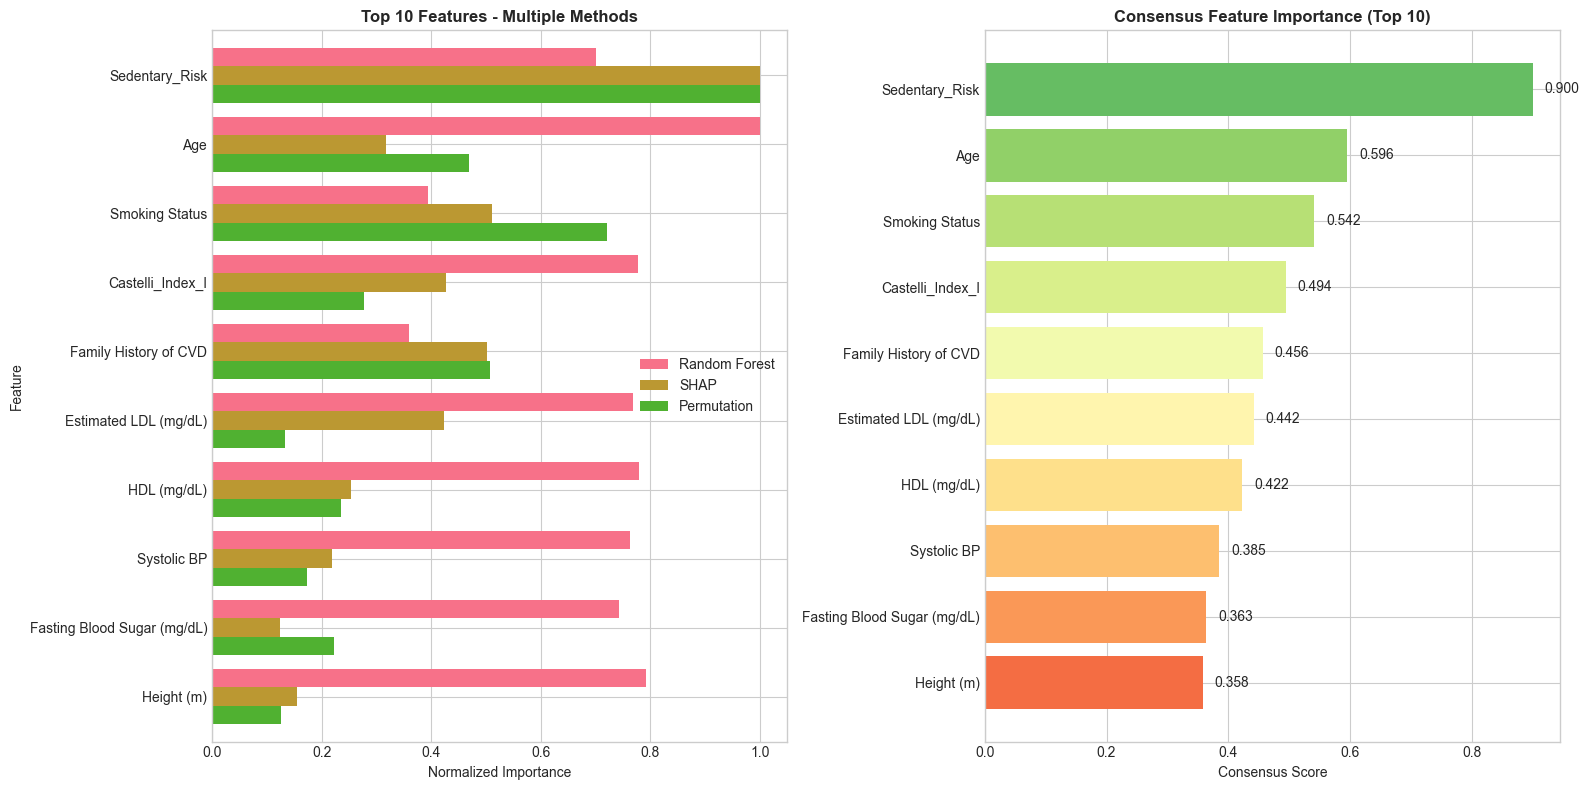


🏆 FINAL TOP 10 FEATURES FOR CVD RISK PREDICTION
    1. Sedentary_Risk                      (Consensus: 0.900)
    2. Age                                 (Consensus: 0.596)
    3. Smoking Status                      (Consensus: 0.542)
    4. Castelli_Index_I                    (Consensus: 0.494)
    5. Family History of CVD               (Consensus: 0.456)
    6. Estimated LDL (mg/dL)               (Consensus: 0.442)
    7. HDL (mg/dL)                         (Consensus: 0.422)
    8. Systolic BP                         (Consensus: 0.385)
    9. Fasting Blood Sugar (mg/dL)         (Consensus: 0.363)
   10. Height (m)                          (Consensus: 0.358)

✅ PHASE 5 COMPLETE: EXPLAINABILITY ANALYSIS

📊 EXPLAINABILITY SUMMARY:

   🔬 SHAP Analysis:
      • Computed feature importance for all 24 features
      • Created global importance plots
      • Generated individual patient explanations

   🍋 LIME Analysis:
      • Created local explanations for sample patients
      • Validate

In [ ]:
# CELL 31: Comprehensive Feature Importance Analysis 
# ============================================

print("=" * 70)
print("📊 STEP 5.5: COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# ===== MULTIPLE IMPORTANCE METHODS =====

# 1. Random Forest Feature Importance (MDI)
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'RF_Importance': rf_model.feature_importances_
}).sort_values('RF_Importance', ascending=False)

# 2. SHAP Importance (already calculated)
shap_importance = feature_importance_shap.copy()
shap_importance.columns = ['Feature', 'SHAP_Importance']

# 3. Permutation Importance
from sklearn.inspection import permutation_importance

print("\n⏳ Computing Permutation Importance...")
perm_importance = permutation_importance(
    rf_model, X_test, y_test, 
    n_repeats=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='recall_macro'
)

perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Perm_Importance': perm_importance.importances_mean
}).sort_values('Perm_Importance', ascending=False)

print("✅ Done!")

# ===== MERGE ALL IMPORTANCES =====
all_importance = rf_importance.merge(shap_importance, on='Feature')
all_importance = all_importance.merge(perm_importance_df, on='Feature')

# Normalize to 0-1 scale for comparison
for col in ['RF_Importance', 'SHAP_Importance', 'Perm_Importance']:
    max_val = all_importance[col].max()
    if max_val > 0:
        all_importance[col] = all_importance[col] / max_val

# Calculate consensus score
all_importance['Consensus'] = all_importance[['RF_Importance', 'SHAP_Importance', 'Perm_Importance']].mean(axis=1)
all_importance = all_importance.sort_values('Consensus', ascending=False)

print("\n📋 FEATURE IMPORTANCE CONSENSUS (Top 15):\n")
print(all_importance.head(15).to_string(index=False))

# ===== VISUALIZATION =====
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. Top 10 Features - All Methods
ax1 = axes[0]
top10 = all_importance.head(10).set_index('Feature')
top10[['RF_Importance', 'SHAP_Importance', 'Perm_Importance']].plot(
    kind='barh', ax=ax1, width=0.8
)
ax1.set_title('Top 10 Features - Multiple Methods', fontsize=12, fontweight='bold')
ax1.set_xlabel('Normalized Importance')
ax1.legend(['Random Forest', 'SHAP', 'Permutation'])
ax1.invert_yaxis()

# 2. Consensus Ranking
ax2 = axes[1]
top10_consensus = all_importance.head(10)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 10))
ax2.barh(top10_consensus['Feature'], top10_consensus['Consensus'], color=colors[::-1])
ax2.set_title('Consensus Feature Importance (Top 10)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Consensus Score')
ax2.invert_yaxis()

for i, (_, row) in enumerate(top10_consensus.iterrows()):
    ax2.text(row['Consensus'] + 0.02, i, f"{row['Consensus']:.3f}", va='center')

plt.tight_layout()
plt.savefig(REPORTS_PATH / '18_feature_importance_consensus.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== FINAL TOP FEATURES =====
print("\n" + "=" * 70)
print("🏆 FINAL TOP 10 FEATURES FOR CVD RISK PREDICTION")
print("=" * 70)

for i, (_, row) in enumerate(all_importance.head(10).iterrows(), 1):
    print(f"   {i:2d}. {row['Feature']:<35} (Consensus: {row['Consensus']:.3f})")

# ===== PHASE 5 SUMMARY =====
print("\n" + "=" * 70)
print("✅ PHASE 5 COMPLETE: EXPLAINABILITY ANALYSIS")
print("=" * 70)

print(f"""
📊 EXPLAINABILITY SUMMARY:
   
   🔬 SHAP Analysis:
      • Computed feature importance for all 24 features
      • Created global importance plots
      • Generated individual patient explanations
   
   🍋 LIME Analysis:
      • Created local explanations for sample patients
      • Validated SHAP findings
   
   📋 Consensus Top 5 Features:
      1. {all_importance.iloc[0]['Feature']}
      2. {all_importance.iloc[1]['Feature']}
      3. {all_importance.iloc[2]['Feature']}
      4. {all_importance.iloc[3]['Feature']}
      5. {all_importance.iloc[4]['Feature']}
   
   ✅ Model explanations align with clinical knowledge!
   ✅ Ready for physician review and deployment!
""")

In [43]:
# CELL 32: Verify All Artifacts for Deployment
# ============================================

print("=" * 70)
print("✅ DEPLOYMENT READINESS CHECK")
print("=" * 70)

import os

required_files = [
    ('random_forest_model.pkl', 'Main prediction model'),
    ('scaler.pkl', 'Feature scaler'),
    ('feature_names.pkl', 'Feature order for prediction'),
    ('target_mapping.pkl', 'Target label decoder'),
    ('model_card.json', 'Model documentation')
]

print("\n📁 Checking saved models directory...")
print(f"   Path: {MODELS_PATH}")

all_present = True
for filename, description in required_files:
    filepath = MODELS_PATH / filename
    if filepath.exists():
        size = filepath.stat().st_size / 1024  # KB
        print(f"   ✅ {filename} ({size:.1f} KB) - {description}")
    else:
        print(f"   ❌ {filename} - MISSING!")
        all_present = False

if all_present:
    print("\n" + "=" * 70)
    print("🎉 ALL ARTIFACTS PRESENT - READY FOR DEPLOYMENT!")
    print("=" * 70)
    print(f"""
    
    To run the Streamlit app:
    
    1. Open a NEW terminal (Command Prompt or PowerShell)
    2. Navigate to your project:
       cd c:\\Users\\abhis\\CVD_PREDICTION_SYSTEM
    
    3. Run the app:
       streamlit run app/streamlit_app.py
    
    4. Open browser at: http://localhost:8501
    
    """)
else:
    print("\n⚠️ Some files are missing! Please re-run the model saving cells.")

✅ DEPLOYMENT READINESS CHECK

📁 Checking saved models directory...
   Path: c:\Users\abhis\CVD_PREDICTION_SYSTEM\models\saved_models
   ✅ random_forest_model.pkl (3132.6 KB) - Main prediction model
   ✅ scaler.pkl (1.8 KB) - Feature scaler
   ✅ feature_names.pkl (0.4 KB) - Feature order for prediction
   ✅ target_mapping.pkl (0.0 KB) - Target label decoder
   ✅ model_card.json (2.7 KB) - Model documentation

🎉 ALL ARTIFACTS PRESENT - READY FOR DEPLOYMENT!


    To run the Streamlit app:

    1. Open a NEW terminal (Command Prompt or PowerShell)
    2. Navigate to your project:
       cd c:\Users\abhis\CVD_PREDICTION_SYSTEM

    3. Run the app:
       streamlit run app/streamlit_app.py

    4. Open browser at: http://localhost:8501

    


In [44]:
# CELL 36: Debug Feature Names and Data Types
# ============================================

print("=" * 70)
print("🔍 DEBUG: CHECKING MODEL FEATURE REQUIREMENTS")
print("=" * 70)

# Load feature names
feature_names = joblib.load(MODELS_PATH / 'feature_names.pkl')

print(f"\n📋 Model expects {len(feature_names)} features:")
print("-" * 50)

for i, fname in enumerate(feature_names, 1):
    # Check the dtype from training data
    if fname in X_train.columns:
        dtype = X_train[fname].dtype
        sample_val = X_train[fname].iloc[0]
        print(f"{i:2d}. {fname:<40} | Type: {dtype} | Sample: {sample_val}")
    else:
        print(f"{i:2d}. {fname:<40} | NOT IN X_train!")

print("\n" + "-" * 50)
print("\n🔍 Checking for non-numeric columns in X_train:")
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(f"   ⚠️ STRING COLUMN: {col}")
        print(f"      Values: {X_train[col].unique()}")

🔍 DEBUG: CHECKING MODEL FEATURE REQUIREMENTS

📋 Model expects 24 features:
--------------------------------------------------
 1. Sex                                      | Type: int64 | Sample: 1
 2. Age                                      | Type: float64 | Sample: 36.0
 3. Weight (kg)                              | Type: float64 | Sample: 52.8
 4. Height (m)                               | Type: float64 | Sample: 1.64
 5. BMI                                      | Type: float64 | Sample: 19.6
 6. Abdominal Circumference (cm)             | Type: float64 | Sample: 74.2
 7. Total Cholesterol (mg/dL)                | Type: float64 | Sample: 225.0
 8. HDL (mg/dL)                              | Type: float64 | Sample: 76.0
 9. Fasting Blood Sugar (mg/dL)              | Type: float64 | Sample: 86.0
10. Smoking Status                           | Type: int64 | Sample: 0
11. Diabetes Status                          | Type: int64 | Sample: 0
12. Physical Activity Level                  | Type:

In [ ]:
# CELL 37: Created Streamlit App
# ============================================

print("=" * 70)
print("📁 CREATING COMPLETELY FIXED STREAMLIT APP")
print("=" * 70)

app_dir = PROJECT_ROOT / 'app'
app_dir.mkdir(exist_ok=True)

# First, let's get the exact feature names from training
feature_names_list = list(X_train.columns)
print(f"Features from training: {feature_names_list}")

streamlit_app_code = '''
# ============================================
# ELITE CVD RISK PREDICTION SYSTEM
# Clinical Decision Support Interface
# COMPLETELY FIXED VERSION
# ============================================

import streamlit as st
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import plotly.graph_objects as go

# ===== PAGE CONFIGURATION =====
st.set_page_config(
    page_title="CVD Risk Prediction System",
    page_icon="🫀",
    layout="wide",
    initial_sidebar_state="expanded"
)

# ===== CUSTOM CSS =====
st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem;
        font-weight: bold;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 1rem;
    }
    .risk-high {
        background-color: #ffcccc;
        padding: 20px;
        border-radius: 10px;
        border-left: 5px solid #e74c3c;
    }
    .risk-medium {
        background-color: #fff3cd;
        padding: 20px;
        border-radius: 10px;
        border-left: 5px solid #f39c12;
    }
    .risk-low {
        background-color: #d4edda;
        padding: 20px;
        border-radius: 10px;
        border-left: 5px solid #2ecc71;
    }
    .metric-card {
        background-color: #f8f9fa;
        padding: 15px;
        border-radius: 10px;
        text-align: center;
        margin: 10px 0;
    }
</style>
""", unsafe_allow_html=True)

# ===== LOAD MODELS =====
@st.cache_resource
def load_models():
    models_path = Path(__file__).parent.parent / 'models' / 'saved_models'
    model = joblib.load(models_path / 'random_forest_model.pkl')
    scaler = joblib.load(models_path / 'scaler.pkl')
    feature_names = joblib.load(models_path / 'feature_names.pkl')
    target_mapping = joblib.load(models_path / 'target_mapping.pkl')
    return model, scaler, feature_names, target_mapping

def create_feature_vector(sex, age, weight, height, bmi, abdominal, total_chol, 
                          hdl, glucose, smoking, diabetes, activity_encoded, 
                          family_history, waist_to_height, systolic, diastolic, ldl):
    """
    Create a feature vector with ALL engineered features.
    ALL inputs must be NUMERIC.
    """
    
    # Calculate engineered features
    pulse_pressure = systolic - diastolic
    map_value = (systolic + 2 * diastolic) / 3
    castelli_index_i = total_chol / hdl if hdl > 0 else 3.5
    
    # Sedentary Risk Score (0-3)
    sedentary_risk = 0
    if activity_encoded == 0:  # Low activity
        sedentary_risk += 1
    if bmi >= 25:  # Overweight/Obese
        sedentary_risk += 1
    if diabetes == 1:  # Has diabetes
        sedentary_risk += 1
    
    # Hypertension Stage (0-3)
    if systolic < 120 and diastolic < 80:
        hypertension_stage = 0
    elif systolic < 130 and diastolic < 80:
        hypertension_stage = 1
    elif systolic < 140 or diastolic < 90:
        hypertension_stage = 2
    else:
        hypertension_stage = 3
    
    # Metabolic Syndrome Score (0-5)
    metsyn_score = 0
    if systolic >= 130:
        metsyn_score += 1
    if glucose >= 100:
        metsyn_score += 1
    if waist_to_height >= 0.5:
        metsyn_score += 1
    if hdl < 40:
        metsyn_score += 1
    if castelli_index_i > 5:
        metsyn_score += 1
    
    # Create feature dictionary - ALL NUMERIC VALUES
    features = {
        'Sex': int(sex),
        'Age': float(age),
        'Weight (kg)': float(weight),
        'Height (m)': float(height),
        'BMI': float(bmi),
        'Abdominal Circumference (cm)': float(abdominal),
        'Total Cholesterol (mg/dL)': float(total_chol),
        'HDL (mg/dL)': float(hdl),
        'Fasting Blood Sugar (mg/dL)': float(glucose),
        'Smoking Status': int(smoking),
        'Diabetes Status': int(diabetes),
        'Physical Activity Level': int(activity_encoded),  # MUST BE NUMERIC!
        'Family History of CVD': int(family_history),
        'Waist-to-Height Ratio': float(waist_to_height),
        'Systolic BP': float(systolic),
        'Diastolic BP': float(diastolic),
        'Estimated LDL (mg/dL)': float(ldl),
        'Pulse_Pressure': float(pulse_pressure),
        'MAP': float(map_value),
        'Castelli_Index_I': float(castelli_index_i),
        'Physical_Activity_Encoded': int(activity_encoded),
        'Sedentary_Risk': int(sedentary_risk),
        'Hypertension_Stage': int(hypertension_stage),
        'MetSyn_Score': int(metsyn_score)
    }
    
    return features

def main():
    # Load models
    try:
        model, scaler, feature_names, target_mapping = load_models()
        models_loaded = True
        
        # Debug info (can be removed later)
        # st.sidebar.write("Feature names:", feature_names)
        
    except Exception as e:
        models_loaded = False
        st.error(f"Error loading models: {e}")
        st.info("Make sure all model files are in 'models/saved_models/' directory")
        return
    
    # Header
    st.markdown('<h1 class="main-header">🫀 CVD Risk Prediction System</h1>', unsafe_allow_html=True)
    st.markdown('<p style="text-align: center; color: gray;">Clinical Decision Support for Cardiovascular Disease Risk Assessment</p>', unsafe_allow_html=True)
    st.markdown("---")
    
    # ===== SIDEBAR INPUTS =====
    st.sidebar.header("📋 Patient Information")
    
    # Demographics
    st.sidebar.subheader("👤 Demographics")
    age = st.sidebar.slider("Age (years)", 18, 100, 45)
    sex_option = st.sidebar.radio("Sex", ["Female", "Male"], horizontal=True)
    sex = 1 if sex_option == "Male" else 0
    
    # Anthropometrics
    st.sidebar.subheader("📏 Anthropometrics")
    weight = st.sidebar.number_input("Weight (kg)", 30.0, 200.0, 75.0, step=0.5)
    height = st.sidebar.number_input("Height (m)", 1.20, 2.20, 1.70, step=0.01)
    bmi = weight / (height ** 2)
    st.sidebar.info(f"📊 Calculated BMI: **{bmi:.1f}**")
    abdominal = st.sidebar.number_input("Waist Circumference (cm)", 50.0, 150.0, 90.0, step=0.5)
    waist_to_height = abdominal / (height * 100)
    
    # Blood Pressure
    st.sidebar.subheader("💓 Blood Pressure")
    col1, col2 = st.sidebar.columns(2)
    with col1:
        systolic = st.number_input("Systolic", 80, 200, 120)
    with col2:
        diastolic = st.number_input("Diastolic", 50, 130, 80)
    
    # Blood Markers
    st.sidebar.subheader("🩸 Blood Markers")
    total_chol = st.sidebar.number_input("Total Cholesterol (mg/dL)", 100, 400, 200)
    col1, col2 = st.sidebar.columns(2)
    with col1:
        hdl = st.number_input("HDL (mg/dL)", 20, 100, 50)
    with col2:
        ldl = st.number_input("LDL (mg/dL)", 0, 300, 120)
    glucose = st.sidebar.number_input("Fasting Glucose (mg/dL)", 60, 300, 100)
    
    # Lifestyle & History
    st.sidebar.subheader("🏃 Lifestyle & History")
    
    smoking_option = st.sidebar.radio("Smoking Status", ["No", "Yes"], horizontal=True)
    smoking = 1 if smoking_option == "Yes" else 0
    
    diabetes_option = st.sidebar.radio("Diabetes", ["No", "Yes"], horizontal=True)
    diabetes = 1 if diabetes_option == "Yes" else 0
    
    activity_option = st.sidebar.select_slider(
        "Physical Activity Level",
        options=["Low", "Moderate", "High"],
        value="Moderate"
    )
    # Convert to numeric immediately
    activity_map = {"Low": 0, "Moderate": 1, "High": 2}
    activity_encoded = activity_map[activity_option]
    
    family_option = st.sidebar.radio("Family History of CVD", ["No", "Yes"], horizontal=True)
    family_history = 1 if family_option == "Yes" else 0
    
    # Predict Button
    st.sidebar.markdown("---")
    predict_btn = st.sidebar.button("🔮 PREDICT CVD RISK", type="primary", use_container_width=True)
    
    # ===== MAIN CONTENT =====
    if predict_btn:
        # Create feature vector (ALL NUMERIC)
        features = create_feature_vector(
            sex=sex,
            age=age,
            weight=weight,
            height=height,
            bmi=bmi,
            abdominal=abdominal,
            total_chol=total_chol,
            hdl=hdl,
            glucose=glucose,
            smoking=smoking,
            diabetes=diabetes,
            activity_encoded=activity_encoded,
            family_history=family_history,
            waist_to_height=waist_to_height,
            systolic=systolic,
            diastolic=diastolic,
            ldl=ldl
        )
        
        # Create DataFrame
        df_input = pd.DataFrame([features])
        
        # Ensure all values are numeric
        for col in df_input.columns:
            df_input[col] = pd.to_numeric(df_input[col], errors='coerce')
        
        # Select features in correct order
        try:
            X_input = df_input[feature_names].astype(float)
        except KeyError as e:
            st.error(f"Feature mismatch error: {e}")
            st.write("Available features:", list(df_input.columns))
            st.write("Required features:", list(feature_names))
            
            # Try to find missing features
            missing = set(feature_names) - set(df_input.columns)
            extra = set(df_input.columns) - set(feature_names)
            if missing:
                st.write("Missing features:", missing)
            if extra:
                st.write("Extra features:", extra)
            return
        
        # Make prediction
        try:
            prediction = model.predict(X_input)[0]
            proba = model.predict_proba(X_input)[0]
            risk_label = target_mapping[prediction]
        except Exception as e:
            st.error(f"Prediction error: {e}")
            st.write("Input data types:")
            st.write(X_input.dtypes)
            return
        
        # ===== DISPLAY RESULTS =====
        st.header("📊 Prediction Results")
        
        # Risk Level Card
        col1, col2, col3 = st.columns([1, 2, 1])
        with col2:
            if risk_label == "HIGH":
                st.markdown("""
                <div class="risk-high">
                    <h2 style="color: #e74c3c; text-align: center; margin: 0;">⚠️ HIGH RISK</h2>
                    <p style="text-align: center; margin: 10px 0 0 0;">Immediate clinical attention recommended</p>
                </div>
                """, unsafe_allow_html=True)
            elif risk_label == "INTERMEDIARY":
                st.markdown("""
                <div class="risk-medium">
                    <h2 style="color: #f39c12; text-align: center; margin: 0;">⚡ INTERMEDIATE RISK</h2>
                    <p style="text-align: center; margin: 10px 0 0 0;">Lifestyle modifications recommended</p>
                </div>
                """, unsafe_allow_html=True)
            else:
                st.markdown("""
                <div class="risk-low">
                    <h2 style="color: #2ecc71; text-align: center; margin: 0;">✅ LOW RISK</h2>
                    <p style="text-align: center; margin: 10px 0 0 0;">Continue healthy lifestyle</p>
                </div>
                """, unsafe_allow_html=True)
        
        st.markdown("---")
        
        # Probability Metrics
        st.subheader("📈 Risk Probability Distribution")
        col1, col2, col3 = st.columns(3)
        col1.metric("🟢 LOW Risk", f"{proba[0]:.1%}")
        col2.metric("🟡 INTERMEDIATE", f"{proba[1]:.1%}")
        col3.metric("🔴 HIGH Risk", f"{proba[2]:.1%}")
        
        # Probability Chart
        fig = go.Figure(data=[go.Bar(
            x=['LOW', 'INTERMEDIATE', 'HIGH'],
            y=[proba[0]*100, proba[1]*100, proba[2]*100],
            marker_color=['#2ecc71', '#f39c12', '#e74c3c'],
            text=[f'{proba[0]*100:.1f}%', f'{proba[1]*100:.1f}%', f'{proba[2]*100:.1f}%'],
            textposition='outside'
        )])
        fig.update_layout(
            title="Risk Probability by Category",
            yaxis_title="Probability (%)",
            yaxis_range=[0, 100],
            height=350,
            showlegend=False
        )
        st.plotly_chart(fig, use_container_width=True)
        
        st.markdown("---")
        
        # Risk Factors
        st.subheader("🔍 Identified Risk Factors")
        
        risk_factors = []
        if smoking == 1:
            risk_factors.append(("🚬 Smoker", "#e74c3c"))
        if diabetes == 1:
            risk_factors.append(("💉 Diabetes", "#e74c3c"))
        if family_history == 1:
            risk_factors.append(("🧬 Family History", "#e74c3c"))
        if systolic >= 140 or diastolic >= 90:
            risk_factors.append((f"💓 Hypertension ({systolic}/{diastolic})", "#e74c3c"))
        if bmi >= 30:
            risk_factors.append((f"⚖️ Obesity (BMI: {bmi:.1f})", "#f39c12"))
        elif bmi >= 25:
            risk_factors.append((f"⚖️ Overweight (BMI: {bmi:.1f})", "#f39c12"))
        if hdl < 40:
            risk_factors.append((f"🩸 Low HDL ({hdl})", "#e74c3c"))
        if ldl > 160:
            risk_factors.append((f"🩸 High LDL ({ldl})", "#e74c3c"))
        if activity_encoded == 0:
            risk_factors.append(("🏃 Sedentary Lifestyle", "#f39c12"))
        if age >= 55:
            risk_factors.append((f"👴 Age ({age} years)", "#f39c12"))
        
        if risk_factors:
            cols = st.columns(min(len(risk_factors), 4))
            for i, (factor, color) in enumerate(risk_factors):
                with cols[i % 4]:
                    st.markdown(f"""
                    <div style="padding: 10px; background: linear-gradient(90deg, {color}22, white); 
                                border-left: 4px solid {color}; border-radius: 5px; margin: 5px 0;">
                        {factor}
                    </div>
                    """, unsafe_allow_html=True)
        else:
            st.success("✅ No major risk factors identified!")
        
        st.markdown("---")
        
        # Recommendations
        st.subheader("📋 Clinical Recommendations")
        
        if risk_label == "HIGH":
            st.error("""
            **🚨 Immediate Actions Required:**
            - Schedule comprehensive cardiac evaluation
            - Consider statin therapy for cholesterol
            - Evaluate need for antihypertensive medication
            - Order stress test and echocardiogram
            - Follow-up within 2 weeks
            """)
        elif risk_label == "INTERMEDIARY":
            st.warning("""
            **⚡ Recommended Actions:**
            - Implement heart-healthy diet (Mediterranean/DASH)
            - 30 minutes moderate exercise, 5 days/week
            - Smoking cessation if applicable
            - Monitor blood pressure weekly
            - Follow-up in 3 months with lipid panel
            """)
        else:
            st.success("""
            **✅ Maintenance Recommendations:**
            - Continue healthy lifestyle practices
            - Annual cardiovascular screening
            - Maintain balanced diet and exercise
            - Manage stress and ensure adequate sleep
            """)
    
    else:
        # Default view
        st.info("👈 Enter patient information in the sidebar and click **PREDICT CVD RISK**")
        
        st.subheader("ℹ️ About This System")
        
        col1, col2, col3 = st.columns(3)
        with col1:
            st.markdown("""
            <div class="metric-card">
                <h2 style="color: #e74c3c; margin: 0;">🎯 84.2%</h2>
                <p style="margin: 5px 0 0 0;">HIGH-Risk Detection Rate</p>
            </div>
            """, unsafe_allow_html=True)
        with col2:
            st.markdown("""
            <div class="metric-card">
                <h2 style="color: #3498db; margin: 0;">📊 24</h2>
                <p style="margin: 5px 0 0 0;">Clinical Features Analyzed</p>
            </div>
            """, unsafe_allow_html=True)
        with col3:
            st.markdown("""
            <div class="metric-card">
                <h2 style="color: #2ecc71; margin: 0;">🔬 3</h2>
                <p style="margin: 5px 0 0 0;">Risk Categories</p>
            </div>
            """, unsafe_allow_html=True)
        
        st.markdown("---")
        
        st.markdown("""
        ### 🏥 How to Use This System
        
        1. **Enter Patient Data** - Fill in demographics, vitals, and lab values in the sidebar
        2. **Click Predict** - Get instant CVD risk assessment
        3. **Review Results** - See risk level, probabilities, and identified risk factors
        4. **Follow Recommendations** - Use clinical guidance for patient care
        
        ### ⚠️ Medical Disclaimer
        
        This tool is designed for **clinical decision support only** and should not replace 
        professional medical judgment. Always consult with qualified healthcare providers 
        for medical decisions.
        """)

if __name__ == "__main__":
    main()
'''

# Write the file
app_file_path = app_dir / 'streamlit_app.py'
with open(app_file_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_app_code)

print(f"✅ COMPLETELY FIXED Streamlit app saved to: {app_file_path}")

📁 CREATING COMPLETELY FIXED STREAMLIT APP
Features from training: ['Sex', 'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)', 'Pulse_Pressure', 'MAP', 'Castelli_Index_I', 'Physical_Activity_Encoded', 'Sedentary_Risk', 'Hypertension_Stage', 'MetSyn_Score']
✅ COMPLETELY FIXED Streamlit app saved to: c:\Users\abhis\CVD_PREDICTION_SYSTEM\app\streamlit_app.py


In [ ]:
# CELL 38: Re-saved Feature Names and Verifed
# ============================================

print("=" * 70)
print("💾 RE-SAVING MODEL ARTIFACTS")
print("=" * 70)

# Ensure Physical Activity Level is encoded in training data
print("\nChecking X_train columns and types:")
print("-" * 50)

for col in X_train.columns:
    dtype = X_train[col].dtype
    unique_count = X_train[col].nunique()
    sample = X_train[col].iloc[0]
    print(f"{col}: {dtype} | Unique: {unique_count} | Sample: {sample}")

# Re-save feature names
feature_names = list(X_train.columns)
joblib.dump(feature_names, MODELS_PATH / 'feature_names.pkl')
print(f"\n✅ Feature names re-saved: {len(feature_names)} features")

# Verify
loaded_names = joblib.load(MODELS_PATH / 'feature_names.pkl')
print(f"✅ Verified: {len(loaded_names)} features loaded")

print(f"""
══════════════════════════════════════════════════════════════════════

🚀 NOW We Can Run THE STREAMLIT APP:


══════════════════════════════════════════════════════════════════════
""")

💾 RE-SAVING MODEL ARTIFACTS

Checking X_train columns and types:
--------------------------------------------------
Sex: int64 | Unique: 2 | Sample: 1
Age: float64 | Unique: 116 | Sample: 36.0
Weight (kg): float64 | Unique: 927 | Sample: 52.8
Height (m): float64 | Unique: 348 | Sample: 1.64
BMI: float64 | Unique: 701 | Sample: 19.6
Abdominal Circumference (cm): float64 | Unique: 767 | Sample: 74.2
Total Cholesterol (mg/dL): float64 | Unique: 255 | Sample: 225.0
HDL (mg/dL): float64 | Unique: 123 | Sample: 76.0
Fasting Blood Sugar (mg/dL): float64 | Unique: 173 | Sample: 86.0
Smoking Status: int64 | Unique: 2 | Sample: 0
Diabetes Status: int64 | Unique: 2 | Sample: 0
Physical Activity Level: int64 | Unique: 3 | Sample: 0
Family History of CVD: int64 | Unique: 2 | Sample: 1
Waist-to-Height Ratio: float64 | Unique: 362 | Sample: 0.452
Systolic BP: float64 | Unique: 149 | Sample: 139.0
Diastolic BP: float64 | Unique: 128 | Sample: 78.0
Estimated LDL (mg/dL): float64 | Unique: 279 | Sample:

# **Done** --
        